## Modelado de opiniones y su impacto en la generación de consensos y disensos en una plataforma de CrowdSourcing

El objetivo de la simulación es dilucidar el funcionamiento de las dinámicas de opinión en una plataforma de CrowdSourcing donde las personas expresan sus opiniones y votan las expresadas por otros bajo una serie de condiciones especificadas por el contexto de la plataforma.

In [1]:
import random, numpy as np, pandas as pd, matplotlib.pyplot as plt, time, math, scipy, seaborn as sns, warnings, matplotlib, plotly.graph_objects as go
from scipy.stats import multivariate_normal
from scipy.spatial import distance
from pandas import Series, DataFrame
from uuid import uuid4
# pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore")

start = time.time()

TamañoDeLaMuestra = [100, 200]  # [100, 200, 500, 1000, 10000] # Cantidad de agentes que quiero en la muestra.

# Agentes

## Agente

Agente es una clase que cuenta con los siguientes atributos:

* **Oi** = Contiene la opinion de cada agente. Va a ser siempre numerico pero dependiendo la simulacion puede ser un solo numero (real) o un vector de varios numeros (reales), independientemente de como se generan que siempre lo hacen a partir de la realizacion de algun tipo de distribucion conocida en un espacio univariado o multivariado.  
* **ID** = Es un numero entero de identificacion unico para cada sujeto.
* **IdeasVistas** = Es una lista que contiene los IDs de las ideas que va a ver este agente.  
* **IdeasVotadas** = Es una lista que contiene los IDs de las ideas que va a ver este agente.
* **Valencias** = Es una lista que contiene el valor que toma el voto de este agente.
* **Tipo** = Es el tipo de distribucion que se utilizo para asignarle la opinion.
* **Media** = Es la media de la distribucion.
* **DE** = Es el desvio estandar de la distribucion.

In [2]:
class Agente (object):
    def __init__ (self, tipo, media, ID, de = 0.5, dimensiones = 3):
        self.Oi = self.set_Oi (tipo, media, de, dimensiones)
        self.ID = ID
        self.IdeasVistas = []
        self.IdeasVotadas = []
        self.Valencias = []
        self.Tipo = tipo
        self.Media = media
        self.DE = de
        self.PreferenciaPositiva = np.random.binomial(QIdeasAVotar, np.random.beta(6,2,1), 1)[0]

    def set_Oi (self, tipo, media, de, dimensiones):
        # Asume que se le da el tipo de distribucion ['uniforme', 'univariada', 'multivariada'], 
        # la media (que debe ser una lista con un numero entero), el desvio estandar (normalmente fijo en 0.50), 
        # y la cantidad de dimensiones para el caso de la multivariada (normalmente fijado en 3).
        # En base a eso devuelve una lista con la/s opinion/es del agente.
        
        if tipo not in ['uniforme', 'univariada', 'multivariada']:
            raise Exception("El tipo de opinion solo puede ser ""uniforme"", ""univariada"" o ""multivariada")
        
        elif isinstance(media, list) == False:
            raise Exception("El argumento media solo acepta listas")
        
        opinion = []
        mediasu = []
        
        if tipo == "uniforme":
            if len(media) != 2:
                raise Exception("La media del tipo uniforme debe contener un start y un end")
            opinion.append (random.uniform (media[0],media[1]))
            mediasu += media 
            
        if tipo == "univariada":
            if len(media) != 1:
                raise Exception("La media de la univariada no puede contener mas de un numero")
            opinion = np.random.normal (media,de)
            mediasu = media
                    
        if tipo == "multivariada":
            if len(media) == 1:
                for i in range (dimensiones):
                     mediasu += media
                a = multivariate_normal.rvs(mediasu, de)
                opinion = a.tolist()
                    
            else:
                a = multivariate_normal.rvs(media, de)
                opinion = a.tolist()
                mediasu = media
   
        return opinion

    def append_IdeasVistas (self, IdeaVista):
        self.IdeasVistas.append (IdeaVista)

    def append_IdeasVotadas (self, IdeaVotada):
        self.IdeasVotadas.append (IdeaVotada)   

    def append_Valencias (self, Valencias):
        self.Valencias.append (Valencias) 

    def ListaVotos (self, VotosPos, VotosNeg):
        # Asume que se le da dos numeros enteros, correspondientes a los votos positivos y negativos
        # que se le piden al agente y en base a eso devuelve una lista en la cual los 1 representan 
        # los votos positivos y los -1 los negativos.
        
        votos = VotosPos * [1] + VotosNeg * [-1]
        return votos

    def comparar (self, idea): 
        # Asume que se le da una lista con la/s opinion/es de otro agente (Oj) y la compara con la del agente (Oi).
        # Devuelve la distancia entre ellas.
        
        if len(idea) > 1:
            Distancia = distance.euclidean(self.Oi,idea)
        else:
            Distancia = abs(self.Oi[0]-idea[0])
        return Distancia
    
    def get_Oi (self):
        return self.Oi
    
    def get_IdeasVistas (self):
        return self.IdeasVistas

    def get_ID (self):
        return self.ID

    def get_Tipo (self):
        return self.Tipo
    
    def get_Media (self):
        return self.Media
    
    def get_DE (self):
        return self.DE
    
    def get_PreferenciaPositiva (self):
        return self.PreferenciaPositiva

    def clean_IdeasVistas (self):
        self.IdeasVistas = []

### Agente Nulo

In [3]:
class AgenteNulo (Agente):
    # El agente nulo se caracteriza por la votacion aleatoria.
    
    def votar (self, ideas): 
        # Asume que se le da un dataframe con las opiniones de otros agentes (distribuidas uniformemente) 
        # y vota aleatoriamente. Devuelve un dataframe con el tipo de voto asignado a cada index (que 
        # representa el orden en el que los agentes ingresaron a la plataforma)
        
        self.IdeasVistas.append (ideas)
        Votara = ideas.sample (n = QIdeasAVotar)
        votos = self.ListaVotos(VotosPos, VotosNeg)
        vota = []
        for i in Votara.index:
            vota.append (i)
        self.IdeasVotadas.append (vota)
        self.Valencias.append (votos)
        devuelve = pd.DataFrame(votos, vota)
        return devuelve

## Agente Determinista

In [4]:
class AgenteDeterminista (Agente):
    # El agente Determinista se caracteriza por la votacion determinada por la distancia.
    # Es decir votara la/s idea/s mas cercanas positivamente, y la/s mas lejanas negativamente.

    def votar(self, ideas):
        #Calculo distancias
        ideas['distancias'] = [self.comparar(x) for x in ideas.iloc[:,1]]
        #Ordeno de menor a mayor
        ideas.sort_values('distancias', inplace = True)
        
        #Chequeo si hay 1 o mas votos positivos
        if self.get_PreferenciaPositiva() > 0:
            votos_positivos = ideas.iloc[-self.get_PreferenciaPositiva():, 0] #Selecciono ideas con minima distancia
        else: #Si hay menos de 1 voto positivo no selecciono nada
            votos_positivos = ideas.iloc[:0,0] #Esta llamada es analoga a la de votos negativos con 0
        
        #Selecciono ideas con maxima distancia
        votos_negativos = ideas.iloc[:QIdeasAVotar-self.get_PreferenciaPositiva(), 0]
        
        #Agrego las ideas votadas
        for vota in pd.concat([votos_positivos,votos_negativos]):
            self.IdeasVotadas.append(vota)
        
        #Agrego las valencias con que se votaron
        for votos in range(len(votos_positivos)):
            self.Valencias.append(1)
        for votos in range(len(votos_negativos)):
            self.Valencias.append(-1)
        
        return(
        pd.DataFrame([1]*len(votos_positivos) + [-1]*len(votos_negativos), pd.concat([votos_positivos,votos_negativos]))
        )


## Agente Probabilistico

In [5]:
class AgenteProbabilistico (AgenteDeterminista):
    # El agente Probabilistico se caracteriza por la votacion dada por la probabilidad de elegir la idea
    # inversamente proporcional a la distancia para el caso positivo, o proporcional a la distancia
    # para el caso negativo.
    
    def algvotar (self, ideas, tipo):
        # Asume que se le da un dataframe con las opiniones de otros agentes (distribuidas uniformemente)
        # calcula las distancias y vota acorde a la probabilidad. Devuelve la ID de la idea que haya sido seleccionada.
        
        Wm = ideas.copy()
        for i in Wm.index:
            Wm.at [i,'Distancia'] = self.comparar (Wm.at[i,'Opinion'])
        if tipo == "Positivo":
            for i in Wm.index:
                Wm.at [i,'Distancia'] = abs(1 - Wm.at [i,'Distancia'])
            SumaDistancias = Wm["Distancia"].sum()
            for i in Wm.index:
                Wm.at [i,'Probabilidad'] = abs(Wm.at [i,'Distancia']) / SumaDistancias
            vota = np.random.choice(Wm.index.values.tolist(), 1, p=  Wm["Probabilidad"].values.tolist())
            
        if tipo == "Negativo":
            SumaDistancias = Wm["Distancia"].sum()
            for i in Wm.index:
                Wm.at [i,'Probabilidad'] = Wm.at [i,'Distancia'] / SumaDistancias
            vota = np.random.choice(Wm.index.values.tolist(), 1, p=  Wm["Probabilidad"].values.tolist())
            
        return vota # Me devuelve la id de la idea a votar

    def votar (self, ideas):
        # Asume que se le da un dataframe con las opiniones de otros agentes (distribuidas uniformemente) 
        # y vota probabilisticamente, con una probabilidad inversamente proporcional a la distancia para 
        # el caso positivo, o proporcional a la distancia para el caso negativo (lo cual estara 
        # determinado por la funcion algvotar). Devuelve un dataframe con el tipo de voto asignado a cada 
        # index (que representa el orden en el que los agentes ingresaron a la plataforma).
        
        self.IdeasVistas.append (ideas)
        ideas2 = ideas.copy ()
        vota = []
        votos = self.ListaVotos(VotosPos, VotosNeg)
        for i in votos:
            if i == 1:
                va = int (self.algvotar (ideas2, "Positivo"))
                ideas2.drop (va, inplace=True)
                vota.append (va)
            if i == -1:
                va = int(self.algvotar (ideas2, "Negativo"))
                ideas2.drop (va, inplace=True)
                vota.append (va)
        self.IdeasVotadas.append (vota)
        self.Valencias.append (votos)
        devuelve = pd.DataFrame(votos, vota)
        return devuelve

### Metodos se seleccion de ideas

Esta funcion define la manera en que se va a controlar las ideas que le van a ser presentadas a un agente. Existen dos metodos con que se pueden seleccionar las ideas dependiendo del argumento `tipo` pasado a la funcion.

* Metodo uno (`tipo = 'menos vistas'`): Comprende elegir aquellas ideas que tengan menor cantidad de vistas
* Metodo dos (`tipo = 'ratio'`): Comprende elegir en partes iguales, la mitad de las ideas segun la cantidad de vistas igual que con el metodo uno y la otra mitad de las ideas segun el ratio de votos positivos y cantidad de vistas.   

Ambos metodos pueden controlarse con la misma funcion con un solo parametro que sea un numero del 0 al 1 e indique la proporcion de ideas que se van a seleccionar con determinado criterio. Por ejemplo si el numero indica la proporcion de ideas que se van a seleccionar con el criterio de ratio, un 0 indica que todas las ideas van a ser seleccionadas con el otro criterio que es tener menos vistas. Un 1 indicaria lo contrario, que todas las ideas van a ser seleccionadsa con el metodo de ratio. 

Para eso primero se genera una funcion que vaya a hacer el filtrado y la seleccion tomando como argumentos el dataframe de ideas (`lista`), la cantidad de ideas a elegir basadonse en el ratio (`prop_ratio`) y la cantidad para elegir basandose en menor cantidad de vistas (`prop_vistas`).

In [6]:
 def metodo_de_filtrado(lista, prop_ratio, prop_vistas):
        #Se filtran las variables segun ambos criterios
        ideas_menos_vistas = lista.sort_values(by='Vistas', inplace=False).iloc[:prop_vistas, :2]
        #Se sacan las ideas ya seleccionadas por vistas para no repetir
        nueva_lista = lista[-lista['ID'].isin(ideas_menos_vistas.iloc[:,0].values)] 
        ideas_mayor_ratio = nueva_lista.sort_values(by='Ratio', ascending=False, inplace=False).iloc[:prop_ratio, :2]
        #Se unen los dos dataframes
        OpinionesParaVotar = pd.concat([ideas_menos_vistas, ideas_mayor_ratio])
        #Se devuelve el resultado
        return(OpinionesParaVotar)

In [7]:
def metodo_de_seleccion(lista, prop = 0.5):
    
    prop_ratio = prop*QOpinionesExpuestas
    prop_vistas = QOpinionesExpuestas-prop_ratio
    
    if int(prop_ratio) == prop_ratio: #Si la proporcion es divisible por la cantidad de ideas
        #Se transforman las variables en enteros para usarse para indexar
        prop_ratio = int(prop_ratio)
        prop_vistas = int(prop_vistas)
        return(
            metodo_de_filtrado(lista, prop_ratio, prop_vistas)
        )
    
    else: #Si la proporcion no es divisible
        #Se samplea la cantidad de ideas a elegir segun ratio con una binomial con probabilidad igual a prop
        prop_ratio = np.random.binomial(QOpinionesExpuestas, prop, 1)[0] 
        #El complemento son las ideas elegidas segun vistas
        prop_vistas = QOpinionesExpuestas-prop_ratio
        return(
            metodo_de_filtrado(lista, prop_ratio, prop_vistas)
        )

#### Variables de entorno

Para el contexto de la simulacion es necesario definir algunas variables que van a determinar el contexto de la plataforma en la cual los agentes van a interactuar. Estas variables son:

* `QOpinionesExpuestas` = La cantidad de opiniones que va a ver cada agente. 
* `QVecesMuestroOpinion` = La cantidad minima de veces que quiero que se muestre alguna opinion, toda opinion de esta manera tiene que mostrarse al menos esta cantidad de veces. 
* `VotosPos` = Cuantos votos positivos tiene disponible cada agente.
* `VotosNeg` = Cuantos votos negativos tiene disponible cada agente.
* `QIdeasAVotar` = La cantidad total de ideas que un agente va a votar lo cual esta dado por la suma de la cantidad de votos negativos y positivos disponible para cada agente. 

In [8]:
QOpinionesExpuestas = 10 
QVecesMuestroOpinion = 20000
VotosPos = 2
VotosNeg = 1
# En el modelo actual no importa como ponga los valores en tanto votos pos o votos neg.
QIdeasAVotar = VotosPos + VotosNeg
id_inicial = 0
Sigma = 0.5

## I. Modelo Nulo

### Uniforme Nulo

Se crea un diccionario para albergar a todos los agentes que van a componer la muestra. Para crear el diccionario se itera sobre el rango del tamaño de la muestra a usar (estando los distintos tamaños definidos en una lista) y se genera un nuevo elemento del diccionario (una instancia de la clase correspondiente a algun tipo de agente) con un indice igual al ID del sujeto. 

#### Variables de la muestra

Para la muestra de la simulacion es necesario definir algunas variables que van a determinar el tipo de distribucion que tendra la opinion de los agentes. Estas variables son:

* `Tipo` = Representa la distirbucion que va a tomar la opinion del sujeto,  puede ser  'uniforme', ' univariada' o 'multivariada'.
* `Media` = Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas 

In [9]:
Tipo = 'uniforme' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [-1,1]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas

#### Creo la muestra

In [10]:
id_inicial = 0
Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteNulo (Tipo, Media, id_inicial)
    id_inicial += 1

#### Simulacion

Para la simulacion es necesario definir algunas variables. Estas variables son:

* `Muestra_Simulacion` = Es una copia de la muestra completa que se utilizara para esta simulacion en especifico. 
* `DataSave` = Es un array que almacenara la ID del sujeto, su opinion, la cantidad de votos (positivos y negativos), la cantidad de vistas, y el ratio (Vistas/Votos).
* `MinutoAMinuto` = Es un array que almacena lo que va sucediendo paso por paso en la simulacion.
* `OpinanNoVotan` y `TiempoSimulacion` son dos variables que sirven a modo funcional de la simulacion.

In [11]:
Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
UniformeNulo = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoUniformeNulo = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        UniformeNulo.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = UniformeNulo[UniformeNulo.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        UniformeNulo.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota
        for i in VotoActual.index:
            if VotoActual.at[i, 0] == 1:
                UniformeNulo.at [i,'VotosPos'] = UniformeNulo.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            if VotoActual.at[i, 0] == -1:
                UniformeNulo.at [i,'VotosNeg'] = UniformeNulo.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            UniformeNulo.at [i,'Vistas'] = UniformeNulo.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            UniformeNulo.at [i, 'Ratio'] = UniformeNulo.at[i, 'VotosPos'] / UniformeNulo.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoUniformeNulo.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoUniformeNulo.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

### Univariada Nulo

In [12]:
id_inicial = 0
Tipo = 'univariada' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [0]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas

Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteNulo (Tipo, Media, id_inicial)
    id_inicial += 1

Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
UnivariadaNulo = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoUnivariadaNulo = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        UnivariadaNulo.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = UnivariadaNulo[UnivariadaNulo.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        UnivariadaNulo.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            
            if VotoActual.at[i, 0] == 1:
                UnivariadaNulo.at [i,'VotosPos'] = UnivariadaNulo.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.at[i, 0] == -1:
                UnivariadaNulo.at [i,'VotosNeg'] = UnivariadaNulo.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            UnivariadaNulo.at [i,'Vistas'] = UnivariadaNulo.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            UnivariadaNulo.at [i, 'Ratio'] = UnivariadaNulo.at[i, 'VotosPos'] / UnivariadaNulo.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoUnivariadaNulo.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoUnivariadaNulo.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

### Multivariada Nulo

In [13]:
id_inicial = 0
Tipo = 'multivariada' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [0]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas

Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteNulo (Tipo, Media, id_inicial)
    id_inicial += 1
    
Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
MultivariadaNulo = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoMultivariadaNulo = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        MultivariadaNulo.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = MultivariadaNulo[MultivariadaNulo.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        MultivariadaNulo.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            
            if VotoActual.at[i, 0] == 1:
                MultivariadaNulo.at [i,'VotosPos'] = MultivariadaNulo.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.at[i, 0] == -1:
                MultivariadaNulo.at [i,'VotosNeg'] = MultivariadaNulo.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            MultivariadaNulo.at [i,'Vistas'] = MultivariadaNulo.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            MultivariadaNulo.at [i, 'Ratio'] = MultivariadaNulo.at[i, 'VotosPos'] / MultivariadaNulo.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoMultivariadaNulo.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoMultivariadaNulo.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

## II. Modelo Determinista

### Uniforme Determinista

In [16]:
id_inicial = 0
Tipo = 'uniforme' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [-1,1]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas

Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteDeterminista (Tipo, Media, id_inicial)
    id_inicial += 1

Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
UniformeDeterminista = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoUniformeDeterminista = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        UniformeDeterminista.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = UniformeDeterminista[UniformeDeterminista.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        UniformeDeterminista.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            if VotoActual.at[i, 0] == 1:
                UniformeDeterminista.at [i,'VotosPos'] = UniformeDeterminista.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.at[i, 0] == -1:
                UniformeDeterminista.at [i,'VotosNeg'] = UniformeDeterminista.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            UniformeDeterminista.at [i,'Vistas'] = UniformeDeterminista.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            UniformeDeterminista.at [i, 'Ratio'] = UniformeDeterminista.at[i, 'VotosPos'] / UniformeDeterminista.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoUniformeDeterminista.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoUniformeDeterminista.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

### Univariada Determinista

In [17]:
id_inicial = 0
Tipo = 'univariada' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [0]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas

Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteDeterminista (Tipo, Media, id_inicial)
    id_inicial += 1

Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
UnivariadaDeterminista = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoUnivariadaDeterminista = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        UnivariadaDeterminista.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = UnivariadaDeterminista[UnivariadaDeterminista.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        UnivariadaDeterminista.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            
            if VotoActual.at[i, 0] == 1:
                UnivariadaDeterminista.at [i,'VotosPos'] = UnivariadaDeterminista.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.at[i, 0] == -1:
                UnivariadaDeterminista.at [i,'VotosNeg'] = UnivariadaDeterminista.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            UnivariadaDeterminista.at [i,'Vistas'] = UnivariadaDeterminista.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            UnivariadaDeterminista.at [i, 'Ratio'] = UnivariadaDeterminista.at[i, 'VotosPos'] / UnivariadaDeterminista.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoUnivariadaDeterminista.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoUnivariadaDeterminista.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

### Multivariada Determinista

In [18]:
id_inicial = 0
Tipo = 'multivariada' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [0]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas

Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteDeterminista (Tipo, Media, id_inicial)
    id_inicial += 1

Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
MultivariadaDeterminista = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoMultivariadaDeterminista = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        MultivariadaDeterminista.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = MultivariadaDeterminista[MultivariadaDeterminista.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        MultivariadaDeterminista.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            
            if VotoActual.at[i, 0] == 1:
                MultivariadaDeterminista.at [i,'VotosPos'] = MultivariadaDeterminista.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.at[i, 0] == -1:
                MultivariadaDeterminista.at [i,'VotosNeg'] = MultivariadaDeterminista.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            MultivariadaDeterminista.at [i,'Vistas'] = MultivariadaDeterminista.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            MultivariadaDeterminista.at [i, 'Ratio'] = MultivariadaDeterminista.at[i, 'VotosPos'] / MultivariadaDeterminista.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoMultivariadaDeterminista.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoMultivariadaDeterminista.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

## III. Modelo Probabilistico

### Uniforme Probabilistica

In [21]:
id_inicial = 0
Tipo = 'uniforme' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [-1,1]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas

Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteProbabilistico (Tipo, Media, id_inicial)
    id_inicial += 1

Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
UniformeProbabilistica = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoUniformeProbabilistica = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        UniformeProbabilistica.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = UniformeProbabilistica[UniformeProbabilistica.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        UniformeProbabilistica.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            
            if VotoActual.at[i, 0] == 1:
                UniformeProbabilistica.at [i,'VotosPos'] = UniformeProbabilistica.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.at[i, 0] == -1:
                UniformeProbabilistica.at [i,'VotosNeg'] = UniformeProbabilistica.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            UniformeProbabilistica.at [i,'Vistas'] = UniformeProbabilistica.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            UniformeProbabilistica.at [i, 'Ratio'] = UniformeProbabilistica.at[i, 'VotosPos'] / UniformeProbabilistica.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoUniformeProbabilistica.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoUniformeProbabilistica.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

### Univariada Probabilistica

In [22]:
id_inicial = 0
Tipo = 'univariada' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [0]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas

Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteProbabilistico (Tipo, Media, id_inicial)
    id_inicial += 1

Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
UnivariadaProbabilistica = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoUnivariadaProbabilistica = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        UnivariadaProbabilistica.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = UnivariadaProbabilistica[UnivariadaProbabilistica.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        UnivariadaProbabilistica.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            
            if VotoActual.at[i, 0] == 1:
                UnivariadaProbabilistica.at [i,'VotosPos'] = UnivariadaProbabilistica.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.at[i, 0] == -1:
                UnivariadaProbabilistica.at [i,'VotosNeg'] = UnivariadaProbabilistica.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            UnivariadaProbabilistica.at [i,'Vistas'] = UnivariadaProbabilistica.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            UnivariadaProbabilistica.at [i, 'Ratio'] = UnivariadaProbabilistica.at[i, 'VotosPos'] / UnivariadaProbabilistica.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoUnivariadaProbabilistica.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoUnivariadaProbabilistica.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

### Multivariada Probabilistica

In [23]:
id_inicial = 0
Tipo = 'multivariada' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [0]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas

Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteProbabilistico (Tipo, Media, id_inicial)
    id_inicial += 1

Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
MultivariadaProbabilistica = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoMultivariadaProbabilistica = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        MultivariadaProbabilistica.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = MultivariadaProbabilistica[MultivariadaProbabilistica.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        MultivariadaProbabilistica.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            
            if VotoActual.at[i, 0] == 1:
                MultivariadaProbabilistica.at [i,'VotosPos'] = MultivariadaProbabilistica.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.at[i, 0] == -1:
                MultivariadaProbabilistica.at [i,'VotosNeg'] = MultivariadaProbabilistica.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            MultivariadaProbabilistica.at [i,'Vistas'] = MultivariadaProbabilistica.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            MultivariadaProbabilistica.at [i, 'Ratio'] = MultivariadaProbabilistica.at[i, 'VotosPos'] / MultivariadaProbabilistica.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoMultivariadaProbabilistica.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoMultivariadaProbabilistica.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

## IV. Univariada y Mezclas, Modelo Nulo

### Univariada Nulo

### Univariada Nulo Mezcla Distancia 2

In [26]:
id_inicial = 0
Tipo = 'univariada' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [0]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas
Distancia = 2

id_inicial = 0
Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteNulo (Tipo, list(np.random.choice([0-(Sigma*(Distancia/2)),0+(Sigma*(Distancia/2))],1)), id_inicial)
    id_inicial += 1

Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
UnivariadaNuloMezcla2 = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoUnivariadaNuloMezcla2 = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        UnivariadaNuloMezcla2.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = UnivariadaNuloMezcla2[UnivariadaNuloMezcla2.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        UnivariadaNuloMezcla2.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            
            if VotoActual.at[i, 0] == 1:
                UnivariadaNuloMezcla2.at [i,'VotosPos'] = UnivariadaNuloMezcla2.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.at[i, 0] == -1:
                UnivariadaNuloMezcla2.at [i,'VotosNeg'] = UnivariadaNuloMezcla2.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            UnivariadaNuloMezcla2.at [i,'Vistas'] = UnivariadaNuloMezcla2.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            UnivariadaNuloMezcla2.at [i, 'Ratio'] = UnivariadaNuloMezcla2.at[i, 'VotosPos'] / UnivariadaNuloMezcla2.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoUnivariadaNuloMezcla2.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoUnivariadaNuloMezcla2.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

### Univariada Nulo Mezcla Distancia 4

In [27]:
id_inicial = 0
Tipo = 'univariada' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [0]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas
Distancia = 4

id_inicial = 0
Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteNulo (Tipo, list(np.random.choice([0-(Sigma*(Distancia/2)),0+(Sigma*(Distancia/2))],1)), id_inicial)
    id_inicial += 1

Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
UnivariadaNuloMezcla4 = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoUnivariadaNuloMezcla4 = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        UnivariadaNuloMezcla4.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = UnivariadaNuloMezcla4[UnivariadaNuloMezcla4.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        UnivariadaNuloMezcla4.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            
            if VotoActual.at[i, 0] == 1:
                UnivariadaNuloMezcla4.at [i,'VotosPos'] = UnivariadaNuloMezcla4.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.at[i, 0] == -1:
                UnivariadaNuloMezcla4.at [i,'VotosNeg'] = UnivariadaNuloMezcla4.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            UnivariadaNuloMezcla4.at [i,'Vistas'] = UnivariadaNuloMezcla4.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            UnivariadaNuloMezcla4.at [i, 'Ratio'] = UnivariadaNuloMezcla4.at[i, 'VotosPos'] / UnivariadaNuloMezcla4.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoUnivariadaNuloMezcla4.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoUnivariadaNuloMezcla4.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

### Univariada Nulo Mezcla Distancia 8

In [28]:
id_inicial = 0
Tipo = 'univariada' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [0]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas
Distancia = 8

id_inicial = 0
Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteNulo (Tipo, list(np.random.choice([0-(Sigma*(Distancia/2)),0+(Sigma*(Distancia/2))],1)), id_inicial)
    id_inicial += 1

Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
UnivariadaNuloMezcla8 = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoUnivariadaNuloMezcla8 = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        UnivariadaNuloMezcla8.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = UnivariadaNuloMezcla8[UnivariadaNuloMezcla8.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        UnivariadaNuloMezcla8.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            
            if VotoActual.at[i, 0] == 1:
                UnivariadaNuloMezcla8.at [i,'VotosPos'] = UnivariadaNuloMezcla8.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.at[i, 0] == -1:
                UnivariadaNuloMezcla8.at [i,'VotosNeg'] = UnivariadaNuloMezcla8.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            UnivariadaNuloMezcla8.at [i,'Vistas'] = UnivariadaNuloMezcla8.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            UnivariadaNuloMezcla8.at [i, 'Ratio'] = UnivariadaNuloMezcla8.at[i, 'VotosPos'] / UnivariadaNuloMezcla8.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoUnivariadaNuloMezcla8.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoUnivariadaNuloMezcla8.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

## V. Multivariada y Mezclas, Modelo Determinista

### MultivariadaDeterminista

### Multivarada Determinista Mezcla Distancia 2

In [31]:
id_inicial = 0
Tipo = 'multivariada' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [0]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas
Distancia = 2

id_inicial = 0
Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteDeterminista (Tipo, list(np.random.choice([0-(Sigma*(Distancia/2)),0+(Sigma*(Distancia/2))],1)), id_inicial)
    id_inicial += 1

Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
MultivariadaDeterministaMezcla2 = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoMultivariadaDeterministaMezcla2 = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        MultivariadaDeterministaMezcla2.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = MultivariadaDeterministaMezcla2[MultivariadaDeterministaMezcla2.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        MultivariadaDeterministaMezcla2.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            
            if VotoActual.at[i, 0] == 1:
                MultivariadaDeterministaMezcla2.at [i,'VotosPos'] = MultivariadaDeterministaMezcla2.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.at[i, 0] == -1:
                MultivariadaDeterministaMezcla2.at [i,'VotosNeg'] = MultivariadaDeterministaMezcla2.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            MultivariadaDeterministaMezcla2.at [i,'Vistas'] = MultivariadaDeterministaMezcla2.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            MultivariadaDeterministaMezcla2.at [i, 'Ratio'] = MultivariadaDeterministaMezcla2.at[i, 'VotosPos'] / MultivariadaDeterministaMezcla2.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoMultivariadaDeterministaMezcla2.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoMultivariadaDeterministaMezcla2.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

### Multivarada Determinista Mezcla Distancia 4

In [32]:
id_inicial = 0
Tipo = 'multivariada' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [0]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas
Distancia = 4

id_inicial = 0
Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteDeterminista (Tipo, list(np.random.choice([0-(Sigma*(Distancia/2)),0+(Sigma*(Distancia/2))],1)), id_inicial)
    id_inicial += 1

Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
MultivariadaDeterministaMezcla4 = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoMultivariadaDeterministaMezcla4 = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        MultivariadaDeterministaMezcla4.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = MultivariadaDeterministaMezcla4[MultivariadaDeterministaMezcla4.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        MultivariadaDeterministaMezcla4.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            
            if VotoActual.at[i, 0] == 1:
                MultivariadaDeterministaMezcla4.at [i,'VotosPos'] = MultivariadaDeterministaMezcla4.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.at[i, 0] == -1:
                MultivariadaDeterministaMezcla4.at [i,'VotosNeg'] = MultivariadaDeterministaMezcla4.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            MultivariadaDeterministaMezcla4.at [i,'Vistas'] = MultivariadaDeterministaMezcla4.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            MultivariadaDeterministaMezcla4.at [i, 'Ratio'] = MultivariadaDeterministaMezcla4.at[i, 'VotosPos'] / MultivariadaDeterministaMezcla4.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoMultivariadaDeterministaMezcla4.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoMultivariadaDeterministaMezcla4.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

### Multivarada Determinista Mezcla Distancia 8

In [33]:
id_inicial = 0
Tipo = 'multivariada' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [0]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas
Distancia = 8

id_inicial = 0
Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteDeterminista (Tipo, list(np.random.choice([0-(Sigma*(Distancia/2)),0+(Sigma*(Distancia/2))],1)), id_inicial)
    id_inicial += 1

Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
MultivariadaDeterministaMezcla8 = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoMultivariadaDeterministaMezcla8 = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        MultivariadaDeterministaMezcla8.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = MultivariadaDeterministaMezcla8[MultivariadaDeterministaMezcla8.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        MultivariadaDeterministaMezcla8.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            
            if VotoActual.at[i, 0] == 1:
                MultivariadaDeterministaMezcla8.at [i,'VotosPos'] = MultivariadaDeterministaMezcla8.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.at[i, 0] == -1:
                MultivariadaDeterministaMezcla8.at [i,'VotosNeg'] = MultivariadaDeterministaMezcla8.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            MultivariadaDeterministaMezcla8.at [i,'Vistas'] = MultivariadaDeterministaMezcla8.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            MultivariadaDeterministaMezcla8.at [i, 'Ratio'] = MultivariadaDeterministaMezcla8.at[i, 'VotosPos'] / MultivariadaDeterministaMezcla8.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoMultivariadaDeterministaMezcla8.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoMultivariadaDeterministaMezcla8.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

### VI. Multivariada y Mezclas, Modelo Probabilistico

### MultivariadaProbabilistica

### Multivariada Probabilistica Mezcla Distancia 2

In [35]:
id_inicial = 0
Tipo = 'multivariada' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [0]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas
Distancia = 2

id_inicial = 0
Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteProbabilistico (Tipo, list(np.random.choice([0-(Sigma*(Distancia/2)),0+(Sigma*(Distancia/2))],1)), id_inicial)
    id_inicial += 1

Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
MultivariadaProbabilisticaMezcla2 = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoMultivariadaProbabilisticaMezcla2 = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        MultivariadaProbabilisticaMezcla2.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = MultivariadaProbabilisticaMezcla2[MultivariadaProbabilisticaMezcla2.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        MultivariadaProbabilisticaMezcla2.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            
            if VotoActual.at[i, 0] == 1:
                MultivariadaProbabilisticaMezcla2.at [i,'VotosPos'] = MultivariadaProbabilisticaMezcla2.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.at[i, 0] == -1:
                MultivariadaProbabilisticaMezcla2.at [i,'VotosNeg'] = MultivariadaProbabilisticaMezcla2.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            MultivariadaProbabilisticaMezcla2.at [i,'Vistas'] = MultivariadaProbabilisticaMezcla2.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            MultivariadaProbabilisticaMezcla2.at [i, 'Ratio'] = MultivariadaProbabilisticaMezcla2.at[i, 'VotosPos'] / MultivariadaProbabilisticaMezcla2.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoMultivariadaProbabilisticaMezcla2.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoMultivariadaProbabilisticaMezcla2.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

### Multivariada Probabilistica Mezcla Distancia 4

In [36]:
id_inicial = 0
Tipo = 'multivariada' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [0]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas
Distancia = 4

id_inicial = 0
Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteProbabilistico (Tipo, list(np.random.choice([0-(Sigma*(Distancia/2)),0+(Sigma*(Distancia/2))],1)), id_inicial)
    id_inicial += 1

Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
MultivariadaProbabilisticaMezcla4 = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoMultivariadaProbabilisticaMezcla4 = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        MultivariadaProbabilisticaMezcla4.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = MultivariadaProbabilisticaMezcla4[MultivariadaProbabilisticaMezcla4.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        MultivariadaProbabilisticaMezcla4.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            
            if VotoActual.at[i, 0] == 1:
                MultivariadaProbabilisticaMezcla4.at [i,'VotosPos'] = MultivariadaProbabilisticaMezcla4.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.at[i, 0] == -1:
                MultivariadaProbabilisticaMezcla4.at [i,'VotosNeg'] = MultivariadaProbabilisticaMezcla4.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            MultivariadaProbabilisticaMezcla4.at [i,'Vistas'] = MultivariadaProbabilisticaMezcla4.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            MultivariadaProbabilisticaMezcla4.at [i, 'Ratio'] = MultivariadaProbabilisticaMezcla4.at[i, 'VotosPos'] / MultivariadaProbabilisticaMezcla4.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoMultivariadaProbabilisticaMezcla4.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoMultivariadaProbabilisticaMezcla4.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

### Multivariada Probabilistica Mezcla Distancia 8

In [37]:
id_inicial = 0
Tipo = 'multivariada' # Puede ser  'uniforme', ' univariada' o 'multivariada'
Media = [0]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas
Distancia = 8

id_inicial = 0
Muestra_Completa = {}
for k in range (500):
    #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
    Muestra_Completa [id_inicial] = AgenteProbabilistico (Tipo, list(np.random.choice([0-(Sigma*(Distancia/2)),0+(Sigma*(Distancia/2))],1)), id_inicial)
    id_inicial += 1

Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
MultivariadaProbabilisticaMezcla8 = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio'])
MinutoAMinutoMultivariadaProbabilisticaMezcla8 = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
OpinanNoVotan = 0
TiempoSimulacion = 0


for i in Muestra_Simulacion:
    ParticipanteActual = i
    
    if OpinanNoVotan < QOpinionesExpuestas:
        # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.
        
        MultivariadaProbabilisticaMezcla8.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0
        OpinanNoVotan +=1
    
    else:
        OpinionesFiltradas = MultivariadaProbabilisticaMezcla8[MultivariadaProbabilisticaMezcla8.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
        OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
        MultivariadaProbabilisticaMezcla8.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0 # El agente opina
        VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
        for i in VotoActual.index:
            
            if VotoActual.at[i, 0] == 1:
                MultivariadaProbabilisticaMezcla8.at [i,'VotosPos'] = MultivariadaProbabilisticaMezcla8.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.
            
            if VotoActual.at[i, 0] == -1:
                MultivariadaProbabilisticaMezcla8.at [i,'VotosNeg'] = MultivariadaProbabilisticaMezcla8.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 
        
        for i in OpinionesParaVotar.index:
            OpinionI = i
            MultivariadaProbabilisticaMezcla8.at [i,'Vistas'] = MultivariadaProbabilisticaMezcla8.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
            MultivariadaProbabilisticaMezcla8.at [i, 'Ratio'] = MultivariadaProbabilisticaMezcla8.at[i, 'VotosPos'] / MultivariadaProbabilisticaMezcla8.at [i, 'Vistas']
            
            # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
            CopiaOpiniones = OpinionesParaVotar.index.tolist()
            CopiaOpiniones.remove(i)
            MinutoAMinutoMultivariadaProbabilisticaMezcla8.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])
          
            if i in VotoActual.index:
                for i in VotoActual.index:
                    if i == OpinionI:
                        MinutoAMinutoMultivariadaProbabilisticaMezcla8.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
            TiempoSimulacion +=1

## VII. Agentes [Nulo, Determinista y Probabilistico] para todas las Opiniones [Uniforme, Univariada y Multivariada] y todos los Tamaños de Muestra [100, 200, 500, 1000, 10000]

### Agente Nulo, Opinion ['uniforme', 'univariada', 'multivariada'] para todos los TamañosDeMuestra

In [ ]:
S7NuloGeneral = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio', 'N', 'Tipo'])
S7NuloGeneral = S7NuloGeneral.set_index('ID')
id_inicial = 0

for k in TamañoDeLaMuestra:
    NActual = k
    for m in ['uniforme', 'univariada', 'multivariada']:
        Tipo = m # Puede ser  'uniforme', ' univariada' o 'multivariada'
        if Tipo == 'uniforme':
            Media = [-1,1]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas
        else:
            Media = [0]

        Muestra_Completa = {}
        for k in range (NActual):
            #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
            Muestra_Completa [id_inicial] = AgenteNulo (Tipo, Media, id_inicial)
            id_inicial += 1

        Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
        S7Nulo = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio', 'N', 'Tipo'])
        MinutoAMinutoS7Nulo = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
        OpinanNoVotan = 0
        TiempoSimulacion = 0


        for i in Muestra_Simulacion:
            ParticipanteActual = i


            if OpinanNoVotan < QOpinionesExpuestas:
                # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.

                S7Nulo.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0, NActual, Tipo
                OpinanNoVotan +=1

            else:
                OpinionesFiltradas = S7Nulo[S7Nulo.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
                OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
                S7Nulo.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0, NActual, Tipo # El agente opina
                VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
                for i in VotoActual.index:
                    if VotoActual.at[i, 0] == 1:
                        S7Nulo.at [i,'VotosPos'] = S7Nulo.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.

                    if VotoActual.at[i, 0] == -1:
                        S7Nulo.at [i,'VotosNeg'] = S7Nulo.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 

                for i in OpinionesParaVotar.index:
                    OpinionI = i
                    S7Nulo.at [i,'Vistas'] = S7Nulo.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
                    S7Nulo.at [i, 'Ratio'] = S7Nulo.at[i, 'VotosPos'] / S7Nulo.at [i, 'Vistas']

                    # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
                    CopiaOpiniones = OpinionesParaVotar.index.tolist()
                    CopiaOpiniones.remove(i)
                    MinutoAMinutoS7Nulo.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])

                    if i in VotoActual.index:
                        for i in VotoActual.index:
                            if i == OpinionI:
                                MinutoAMinutoS7Nulo.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
                    TiempoSimulacion +=1
        S7Nulo = S7Nulo.set_index('ID')
        S7NuloGeneral = pd.concat ([S7NuloGeneral, S7Nulo])

### Agente Determinista, Opinion ['uniforme', 'univariada', 'multivariada'] para todos los TamañosDeMuestra

In [ ]:
S7DeterministaGeneral = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio', 'N', 'Tipo']) 
S7DeterministaGeneral = S7DeterministaGeneral.set_index('ID')
id_inicial = 0

for k in TamañoDeLaMuestra:
    NActual = k
    for m in ['uniforme', 'univariada', 'multivariada']:
        Tipo = m # Puede ser  'uniforme', ' univariada' o 'multivariada'
        if Tipo == 'uniforme':
            Media = [-1,1]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas
        else:
            Media = [0]

        Muestra_Completa = {}
        for k in range (NActual):
            #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
            Muestra_Completa [id_inicial] = AgenteDeterminista (Tipo, Media, id_inicial)
            id_inicial += 1

        Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
        S7Determinista = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio', 'N', 'Tipo'])
        MinutoAMinutoS7Determinista = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
        OpinanNoVotan = 0
        TiempoSimulacion = 0
        


        for i in Muestra_Simulacion:
            ParticipanteActual = i


            if OpinanNoVotan < QOpinionesExpuestas:
                # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.

                S7Determinista.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0, NActual, Tipo
                OpinanNoVotan +=1

            else:
                OpinionesFiltradas = S7Determinista[S7Determinista.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
                OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
                S7Determinista.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0, NActual, Tipo # El agente opina
                VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota
                for i in VotoActual.index:
                    if VotoActual.at[i, 0] == 1:
                        Linee = S7Determinista.loc [S7Determinista['ID'] == i]
                        Linee = Linee.index.values.tolist()
                        BuscaAca = Linee [0]
                        S7Determinista.at [BuscaAca,'VotosPos'] = S7Determinista.at [BuscaAca,'VotosPos'] + 1 # Le sumo un voto a la idea.

                    if VotoActual.at[i, 0] == -1:
                        Linee = S7Determinista.loc [S7Determinista['ID'] == i]
                        Linee = Linee.index.values.tolist()
                        BuscaAca = Linee [0]
                        S7Determinista.at [BuscaAca,'VotosNeg'] = S7Determinista.at [BuscaAca,'VotosNeg'] + 1 # Le sumo un voto a la idea. 

                for i in OpinionesParaVotar.index:
                    OpinionI = i
                    S7Determinista.at [i,'Vistas'] = S7Determinista.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
                    S7Determinista.at [i, 'Ratio'] = S7Determinista.at[i, 'VotosPos'] / S7Determinista.at [i, 'Vistas']

                    # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
                    CopiaOpiniones = OpinionesParaVotar.index.tolist()
                    CopiaOpiniones.remove(i)
                    MinutoAMinutoS7Determinista.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])

                    if i in VotoActual.index:
                        for i in VotoActual.index:
                            if i == OpinionI:
                                MinutoAMinutoS7Determinista.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
                    TiempoSimulacion +=1
        S7Determinista = S7Determinista.set_index('ID')
        S7DeterministaGeneral = pd.concat ([S7DeterministaGeneral, S7Determinista])

### Agente Probabilistica, Opinion ['uniforme', 'univariada', 'multivariada'] para todos los TamañosDeMuestra

In [ ]:
S7ProbabilisticaGeneral = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio', 'N', 'Tipo']) 
S7ProbabilisticaGeneral = S7ProbabilisticaGeneral.set_index('ID')
id_inicial = 0

for k in TamañoDeLaMuestra:
    NActual = k
    for m in ['uniforme', 'univariada', 'multivariada']:
        Tipo = m # Puede ser  'uniforme', ' univariada' o 'multivariada'
        if Tipo == 'uniforme':
            Media = [-1,1]  # Debe ser una lista, y debe tener [start,stop] para el caso uniforme, o un numero para las univariadas y las multivariadas
        else:
            Media = [0]

        Muestra_Completa = {}
        for k in range (NActual):
            #Muestra_Completa [k] = AgenteNulo (Tipo, Media, str(uuid4()))
            Muestra_Completa [id_inicial] = AgenteProbabilistico (Tipo, Media, id_inicial)
            id_inicial += 1

        Muestra_Simulacion = Muestra_Completa.copy() # Creo una copia de la muestra original, por si se crean varias simulaciones diferentes
        S7Probabilistica = pd.DataFrame(columns=['ID', 'Opinion', 'VotosPos', 'VotosNeg', 'Vistas', 'Ratio', 'N', 'Tipo'])
        MinutoAMinutoS7Probabilistica = pd.DataFrame(columns=['Sujeto', 'TipoDeDistribucion', 'Media/s', 'DesvioEstandar', 'Opinion Sujeto', 'ID Idea Mostrada', 'Idea Mostrada', 'Otras opiniones que vio', 'Voto', 'Distancia'])
        OpinanNoVotan = 0
        TiempoSimulacion = 0
        


        for i in Muestra_Simulacion:
            ParticipanteActual = i


            if OpinanNoVotan < QOpinionesExpuestas:
                # Si hay menos opiniones que las necesarias para mostrar los individuos van a opinar, no votar.

                S7Probabilistica.at [OpinanNoVotan] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0, NActual, Tipo
                OpinanNoVotan +=1

            else:
                OpinionesFiltradas = S7Probabilistica[S7Probabilistica.Vistas < QVecesMuestroOpinion] # Filtro las ideas que tengan menos vistas del limite asignado
                OpinionesParaVotar =  metodo_de_seleccion (OpinionesFiltradas) # Creo un dataframe con las ideas que va a ver el sujeto
                S7Probabilistica.at [i] = Muestra_Simulacion.get(i).get_ID(), Muestra_Simulacion.get(i).get_Oi(), 0, 0, 0, 0, NActual, Tipo # El agente opina
                VotoActual = Muestra_Simulacion.get(i).votar(OpinionesParaVotar) # El agente vota 
                for i in VotoActual.index:
                    if VotoActual.at[i, 0] == 1:
                        S7Probabilistica.at [i,'VotosPos'] = S7Probabilistica.at [i,'VotosPos'] + 1 # Le sumo un voto a la idea.

                    if VotoActual.at[i, 0] == -1:
                        S7Probabilistica.at [i,'VotosNeg'] = S7Probabilistica.at [i,'VotosNeg'] + 1 # Le sumo un voto a la idea. 

                for i in OpinionesParaVotar.index:
                    OpinionI = i
                    S7Probabilistica.at [i,'Vistas'] = S7Probabilistica.at [i,'Vistas'] + 1 # Le sumo una vista a la ideas expuestas   
                    S7Probabilistica.at [i, 'Ratio'] = S7Probabilistica.at[i, 'VotosPos'] / S7Probabilistica.at [i, 'Vistas']

                    # Armo un dataframe con el minuto a minuto de lo que fue pasando en la simulacion
                    CopiaOpiniones = OpinionesParaVotar.index.tolist()
                    CopiaOpiniones.remove(i)
                    MinutoAMinutoS7Probabilistica.at [TiempoSimulacion] = Muestra_Simulacion.get(ParticipanteActual).get_ID(), Muestra_Simulacion.get(ParticipanteActual).get_Tipo(), Muestra_Simulacion.get(ParticipanteActual).get_Media(), Muestra_Simulacion.get(ParticipanteActual).get_DE(), Muestra_Simulacion.get(ParticipanteActual).get_Oi(), i, OpinionesParaVotar.at [i,'Opinion'], CopiaOpiniones, 0, Muestra_Simulacion.get(ParticipanteActual).comparar(OpinionesParaVotar.at [i,'Opinion'])

                    if i in VotoActual.index:
                        for i in VotoActual.index:
                            if i == OpinionI:
                                MinutoAMinutoS7Probabilistica.at [TiempoSimulacion,'Voto'] = VotoActual.at [i,0]  
                    TiempoSimulacion +=1
        S7Probabilistica = S7Probabilistica.set_index('ID')
        S7ProbabilisticaGeneral = pd.concat ([S7ProbabilisticaGeneral, S7Probabilistica])

### Graficos

Separo los resultados

In [ ]:
# S7NuloGeneral = S7NuloGeneral.set_index('ID')

#            Nulo 
CienNulo = S7NuloGeneral [S7NuloGeneral.N == 100]
CienNuloUniforme = CienNulo [CienNulo.Tipo == 'uniforme']
CienNuloUnivariada = CienNulo [CienNulo.Tipo == 'univariada']
CienNuloMultivariada = CienNulo [CienNulo.Tipo == 'multivariada']
DoscientosNulo = S7NuloGeneral [S7NuloGeneral.N == 200]
DoscientosNuloUniforme = DoscientosNulo [DoscientosNulo.Tipo == 'uniforme']
DoscientosNuloUnivariada = DoscientosNulo [DoscientosNulo.Tipo == 'univariada']
DoscientosNuloMultivariada = DoscientosNulo [DoscientosNulo.Tipo == 'multivariada']
QuinientosNulo = S7NuloGeneral [S7NuloGeneral.N == 500]
QuinientosNuloUniforme = QuinientosNulo [QuinientosNulo.Tipo == 'uniforme']
QuinientosNuloUnivariada = QuinientosNulo [QuinientosNulo.Tipo == 'univariada']
QuinientosNuloMultivariada = QuinientosNulo [QuinientosNulo.Tipo == 'multivariada']
MilNulo = S7NuloGeneral [S7NuloGeneral.N == 1000]
MilNuloUniforme = MilNulo [MilNulo.Tipo == 'uniforme']
MilNuloUnivariada = MilNulo [MilNulo.Tipo == 'univariada']
MilNuloMultivariada = MilNulo [MilNulo.Tipo == 'multivariada']
DiezMilNulo = S7NuloGeneral [S7NuloGeneral.N == 10000]
DiezMilNuloUniforme = DiezMilNulo [DiezMilNulo.Tipo == 'uniforme']
DiezMilNuloUnivariada = DiezMilNulo [DiezMilNulo.Tipo == 'univariada']
DiezMilNuloMultivariada = DiezMilNulo [DiezMilNulo.Tipo == 'multivariada']

In [ ]:
#            Determinista 
CienDeterminista = S7DeterministaGeneral [S7DeterministaGeneral.N == 100]
CienDeterministaUniforme = CienDeterminista [CienDeterminista.Tipo == 'uniforme']
CienDeterministaUnivariada = CienDeterminista [CienDeterminista.Tipo == 'univariada']
CienDeterministaMultivariada = CienDeterminista [CienDeterminista.Tipo == 'multivariada']
DoscientosDeterminista = S7DeterministaGeneral [S7DeterministaGeneral.N == 200]
DoscientosDeterministaUniforme = DoscientosDeterminista [DoscientosDeterminista.Tipo == 'uniforme']
DoscientosDeterministaUnivariada = DoscientosDeterminista [DoscientosDeterminista.Tipo == 'univariada']
DoscientosDeterministaMultivariada = DoscientosDeterminista [DoscientosDeterminista.Tipo == 'multivariada']
QuinientosDeterminista = S7DeterministaGeneral [S7DeterministaGeneral.N == 500]
QuinientosDeterministaUniforme = QuinientosDeterminista [QuinientosDeterminista.Tipo == 'uniforme']
QuinientosDeterministaUnivariada = QuinientosDeterminista [QuinientosDeterminista.Tipo == 'univariada']
QuinientosDeterministaMultivariada = QuinientosDeterminista [QuinientosDeterminista.Tipo == 'multivariada']
MilDeterminista = S7DeterministaGeneral [S7DeterministaGeneral.N == 1000]
MilDeterministaUniforme = MilDeterminista [MilDeterminista.Tipo == 'uniforme']
MilDeterministaUnivariada = MilDeterminista [MilDeterminista.Tipo == 'univariada']
MilDeterministaMultivariada = MilDeterminista [MilDeterminista.Tipo == 'multivariada']
DiezMilDeterminista = S7DeterministaGeneral [S7DeterministaGeneral.N == 10000]
DiezMilDeterministaUniforme = DiezMilDeterminista [DiezMilDeterminista.Tipo == 'uniforme']
DiezMilDeterministaUnivariada = DiezMilDeterminista [DiezMilDeterminista.Tipo == 'univariada']
DiezMilDeterministaMultivariada = DiezMilDeterminista [DiezMilDeterminista.Tipo == 'multivariada']

In [ ]:
#            Probabilistica 
CienProbabilistica = S7ProbabilisticaGeneral [S7ProbabilisticaGeneral.N == 100]
CienProbabilisticaUniforme = CienProbabilistica [CienProbabilistica.Tipo == 'uniforme']
CienProbabilisticaUnivariada = CienProbabilistica [CienProbabilistica.Tipo == 'univariada']
CienProbabilisticaMultivariada = CienProbabilistica [CienProbabilistica.Tipo == 'multivariada']
DoscientosProbabilistica = S7ProbabilisticaGeneral [S7ProbabilisticaGeneral.N == 200]
DoscientosProbabilisticaUniforme = DoscientosProbabilistica [DoscientosProbabilistica.Tipo == 'uniforme']
DoscientosProbabilisticaUnivariada = DoscientosProbabilistica [DoscientosProbabilistica.Tipo == 'univariada']
DoscientosProbabilisticaMultivariada = DoscientosProbabilistica [DoscientosProbabilistica.Tipo == 'multivariada']
QuinientosProbabilistica = S7ProbabilisticaGeneral [S7ProbabilisticaGeneral.N == 500]
QuinientosProbabilisticaUniforme = QuinientosProbabilistica [QuinientosProbabilistica.Tipo == 'uniforme']
QuinientosProbabilisticaUnivariada = QuinientosProbabilistica [QuinientosProbabilistica.Tipo == 'univariada']
QuinientosProbabilisticaMultivariada = QuinientosProbabilistica [QuinientosProbabilistica.Tipo == 'multivariada']
MilProbabilistica = S7ProbabilisticaGeneral [S7ProbabilisticaGeneral.N == 1000]
MilProbabilisticaUniforme = MilProbabilistica [MilProbabilistica.Tipo == 'uniforme']
MilProbabilisticaUnivariada = MilProbabilistica [MilProbabilistica.Tipo == 'univariada']
MilProbabilisticaMultivariada = MilProbabilistica [MilProbabilistica.Tipo == 'multivariada']
DiezMilProbabilistica = S7ProbabilisticaGeneral [S7ProbabilisticaGeneral.N == 10000]
DiezMilProbabilisticaUniforme = DiezMilProbabilistica [DiezMilProbabilistica.Tipo == 'uniforme']
DiezMilProbabilisticaUnivariada = DiezMilProbabilistica [DiezMilProbabilistica.Tipo == 'univariada']
DiezMilProbabilisticaMultivariada = DiezMilProbabilistica [DiezMilProbabilistica.Tipo == 'multivariada']

Grafico

In [ ]:
# CTRL F, REPLACE VotosPos x el parametro a graficar en cada caso y listo

fig, ax = plt.subplots(5, 3, figsize=(50,55)) 
# fig.suptitle('Agente Probabilistica')

# 100 Nulo
ax[0,0].hist(CienNuloUniforme.VotosPos, label='CienNuloUniforme', alpha = 0.4, color = 'b', ec="b")
ax[0,0].hist(CienNuloUnivariada.VotosPos, label='CienNuloUnivariada', alpha = 0.4, color = 'g', ec="g")
ax[0,0].hist(CienNuloMultivariada.VotosPos, label='CienNuloMultivariada', alpha = 0.3, color = 'r', ec="r")
ax[0,0].legend(loc='best', fontsize=12)
ax[0,0].title.set_text("VotosPos")

# 200 Nulo
ax[1,0].hist(DoscientosNuloUniforme.VotosPos, label='DoscientosNuloUniforme', alpha = 0.4, color = 'b', ec="b")
ax[1,0].hist(DoscientosNuloUnivariada.VotosPos, label='DoscientosNuloUnivariada', alpha = 0.4, color = 'g', ec="g")
ax[1,0].hist(DoscientosNuloMultivariada.VotosPos, label='DoscientosNuloMultivariada', alpha = 0.3, color = 'r', ec="r")
ax[1,0].legend(loc='best', fontsize=12)
ax[1,0].title.set_text("VotosPos")

# 500 Nulo
ax[2,0].hist(QuinientosNuloUniforme.VotosPos, label='QuinientosNuloUniforme', alpha = 0.4, color = 'b', ec="b")
ax[2,0].hist(QuinientosNuloUnivariada.VotosPos, label='QuinientosNuloUnivariada', alpha = 0.4, color = 'g', ec="g")
ax[2,0].hist(QuinientosNuloMultivariada.VotosPos, label='QuinientosNuloMultivariada', alpha = 0.3, color = 'r', ec="r")
ax[2,0].legend(loc='best', fontsize=12)
ax[2,0].title.set_text("VotosPos")

# 1000 Nulo
ax[3,0].hist(MilNuloUniforme.VotosPos, label='MilNuloUniforme', alpha = 0.4, color = 'b', ec="b")
ax[3,0].hist(MilNuloUnivariada.VotosPos, label='MilNuloUnivariada', alpha = 0.4, color = 'g', ec="g")
ax[3,0].hist(MilNuloMultivariada.VotosPos, label='MilNuloMultivariada', alpha = 0.3, color = 'r', ec="r")
ax[3,0].legend(loc='best', fontsize=12)
ax[3,0].title.set_text("VotosPos")

# 10000 Nulo
ax[4,0].hist(DiezMilNuloUniforme.VotosPos, label='DiezMilNuloUniforme', alpha = 0.4, color = 'b', ec="b")
ax[4,0].hist(DiezMilNuloUnivariada.VotosPos, label='DiezMilNuloUnivariada', alpha = 0.4, color = 'g', ec="g")
ax[4,0].hist(DiezMilNuloMultivariada.VotosPos, label='DiezMilNuloMultivariada', alpha = 0.3, color = 'r', ec="r")
ax[4,0].legend(loc='best', fontsize=12)
ax[4,0].title.set_text("VotosPos")

# ----------------------------------------------------------
# 100 Determinista
ax[0,1].hist(CienDeterministaUniforme.VotosPos, label='CienDeterministaUniforme', alpha = 0.4, color = 'b', ec="b")
ax[0,1].hist(CienDeterministaUnivariada.VotosPos, label='CienDeterministaUnivariada', alpha = 0.4, color = 'g', ec="g")
ax[0,1].hist(CienDeterministaMultivariada.VotosPos, label='CienDeterministaMultivariada', alpha = 0.3, color = 'r', ec="r")
ax[0,1].legend(loc='best', fontsize=12)
ax[0,1].title.set_text("VotosPos")

# 200 Determinista
ax[1,1].hist(DoscientosDeterministaUniforme.VotosPos, label='DoscientosDeterministaUniforme', alpha = 0.4, color = 'b', ec="b")
ax[1,1].hist(DoscientosDeterministaUnivariada.VotosPos, label='DoscientosDeterministaUnivariada', alpha = 0.4, color = 'g', ec="g")
ax[1,1].hist(DoscientosDeterministaMultivariada.VotosPos, label='DoscientosDeterministaMultivariada', alpha = 0.3, color = 'r', ec="r")
ax[1,1].legend(loc='best', fontsize=12)
ax[1,1].title.set_text("VotosPos")

# 500 Determinista
ax[2,1].hist(QuinientosDeterministaUniforme.VotosPos, label='QuinientosDeterministaUniforme', alpha = 0.4, color = 'b', ec="b")
ax[2,1].hist(QuinientosDeterministaUnivariada.VotosPos, label='QuinientosDeterministaUnivariada', alpha = 0.4, color = 'g', ec="g")
ax[2,1].hist(QuinientosDeterministaMultivariada.VotosPos, label='QuinientosDeterministaMultivariada', alpha = 0.3, color = 'r', ec="r")
ax[2,1].legend(loc='best', fontsize=12)
ax[2,1].title.set_text("VotosPos")

# 1000 Determinista
ax[3,1].hist(MilDeterministaUniforme.VotosPos, label='MilDeterministaUniforme', alpha = 0.4, color = 'b', ec="b")
ax[3,1].hist(MilDeterministaUnivariada.VotosPos, label='MilDeterministaUnivariada', alpha = 0.4, color = 'g', ec="g")
ax[3,1].hist(MilDeterministaMultivariada.VotosPos, label='MilDeterministaMultivariada', alpha = 0.3, color = 'r', ec="r")
ax[3,1].legend(loc='best', fontsize=12)
ax[3,1].title.set_text("VotosPos")

# 10000 Determinista
ax[4,1].hist(DiezMilDeterministaUniforme.VotosPos, label='DiezMilDeterministaUniforme', alpha = 0.4, color = 'b', ec="b")
ax[4,1].hist(DiezMilDeterministaUnivariada.VotosPos, label='DiezMilDeterministaUnivariada', alpha = 0.4, color = 'g', ec="g")
ax[4,1].hist(DiezMilDeterministaMultivariada.VotosPos, label='DiezMilDeterministaMultivariada', alpha = 0.3, color = 'r', ec="r")
ax[4,1].legend(loc='best', fontsize=12)
ax[4,1].title.set_text("VotosPos")

# ----------------------------------------------------------
# 100 Probabilistica
ax[0,2].hist(CienProbabilisticaUniforme.VotosPos, label='CienProbabilisticaUniforme', alpha = 0.4, color = 'b', ec="b")
ax[0,2].hist(CienProbabilisticaUnivariada.VotosPos, label='CienProbabilisticaUnivariada', alpha = 0.4, color = 'g', ec="g")
ax[0,2].hist(CienProbabilisticaMultivariada.VotosPos, label='CienProbabilisticaMultivariada', alpha = 0.3, color = 'r', ec="r")
ax[0,2].legend(loc='best', fontsize=12)
ax[0,2].title.set_text("VotosPos")

# 200 Probabilistica
ax[1,2].hist(DoscientosProbabilisticaUniforme.VotosPos, label='DoscientosProbabilisticaUniforme', alpha = 0.4, color = 'b', ec="b")
ax[1,2].hist(DoscientosProbabilisticaUnivariada.VotosPos, label='DoscientosProbabilisticaUnivariada', alpha = 0.4, color = 'g', ec="g")
ax[1,2].hist(DoscientosProbabilisticaMultivariada.VotosPos, label='DoscientosProbabilisticaMultivariada', alpha = 0.3, color = 'r', ec="r")
ax[1,2].legend(loc='best', fontsize=12)
ax[1,2].title.set_text("VotosPos")

# 500 Probabilistica
ax[2,2].hist(QuinientosProbabilisticaUniforme.VotosPos, label='QuinientosProbabilisticaUniforme', alpha = 0.4, color = 'b', ec="b")
ax[2,2].hist(QuinientosProbabilisticaUnivariada.VotosPos, label='QuinientosProbabilisticaUnivariada', alpha = 0.4, color = 'g', ec="g")
ax[2,2].hist(QuinientosProbabilisticaMultivariada.VotosPos, label='QuinientosProbabilisticaMultivariada', alpha = 0.3, color = 'r', ec="r")
ax[2,2].legend(loc='best', fontsize=12)
ax[2,2].title.set_text("VotosPos")

# 1000 Probabilistica
ax[3,2].hist(MilProbabilisticaUniforme.VotosPos, label='MilProbabilisticaUniforme', alpha = 0.4, color = 'b', ec="b")
ax[3,2].hist(MilProbabilisticaUnivariada.VotosPos, label='MilProbabilisticaUnivariada', alpha = 0.4, color = 'g', ec="g")
ax[3,2].hist(MilProbabilisticaMultivariada.VotosPos, label='MilProbabilisticaMultivariada', alpha = 0.3, color = 'r', ec="r")
ax[3,2].legend(loc='best', fontsize=12)
ax[3,2].title.set_text("VotosPos")

# 10000 Probabilistica
ax[4,2].hist(DiezMilProbabilisticaUniforme.VotosPos, label='DiezMilProbabilisticaUniforme', alpha = 0.4, color = 'b', ec="b")
ax[4,2].hist(DiezMilProbabilisticaUnivariada.VotosPos, label='DiezMilProbabilisticaUnivariada', alpha = 0.4, color = 'g', ec="g")
ax[4,2].hist(DiezMilProbabilisticaMultivariada.VotosPos, label='DiezMilProbabilisticaMultivariada', alpha = 0.3, color = 'r', ec="r")
ax[4,2].legend(loc='best', fontsize=12)
ax[4,2].title.set_text("VotosPos")


# Figura 1. Distribución de cantidad de visualizaciones

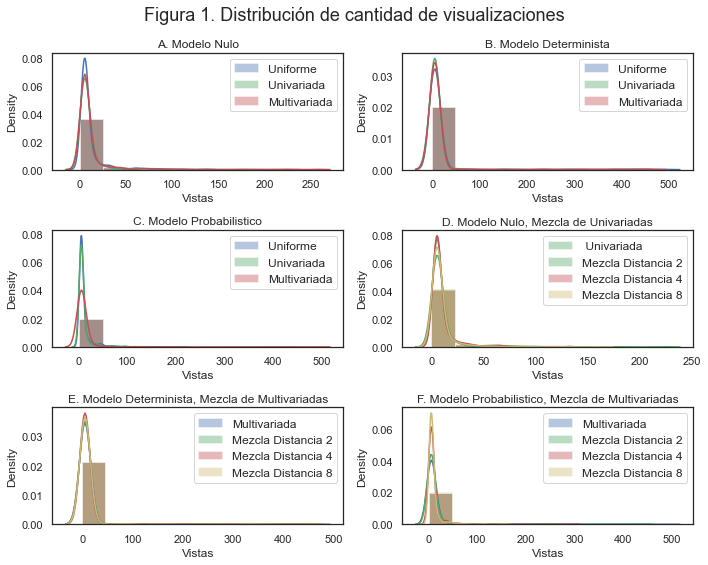

In [281]:
# fig, axes = plt.subplots(3, 2, figsize=(18,18)) 
fig, axes = plt.subplots(3, 2, figsize=(10,8)) 
fig.suptitle('Figura 1. Distribución de cantidad de visualizaciones', fontsize=18)

# Nulo
val_min = min(min(UniformeNulo.Vistas),min(UnivariadaNulo.Vistas),min(MultivariadaNulo.Vistas))
val_max = max(max(UniformeNulo.Vistas),max(UnivariadaNulo.Vistas),max(MultivariadaNulo.Vistas))
sns.distplot(UniformeNulo.Vistas,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaNulo.Vistas,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaNulo.Vistas,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,0].legend(loc='best', fontsize=12)
axes[0,0].title.set_text("A. Modelo Nulo")

# Determinista
val_min = min(min(UniformeDeterminista.Vistas),min(UnivariadaDeterminista.Vistas),min(MultivariadaDeterminista.Vistas))
val_max = max(max(UniformeDeterminista.Vistas),max(UnivariadaDeterminista.Vistas),max(MultivariadaDeterminista.Vistas))
sns.distplot(UniformeDeterminista.Vistas,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaDeterminista.Vistas,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaDeterminista.Vistas,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,1].legend(loc='best', fontsize=12)
axes[0,1].title.set_text("B. Modelo Determinista")

# Probabilistica
val_min = min(min(UniformeProbabilistica.Vistas),min(UnivariadaProbabilistica.Vistas),min(MultivariadaProbabilistica.Vistas))
val_max = max(max(UniformeProbabilistica.Vistas),max(UnivariadaProbabilistica.Vistas),max(MultivariadaProbabilistica.Vistas))
sns.distplot(UniformeProbabilistica.Vistas,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaProbabilistica.Vistas,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaProbabilistica.Vistas,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[1,0].legend(loc='best', fontsize=12)
axes[1,0].title.set_text("C. Modelo Probabilistico")

# Univariada Mezclas Nulo
val_min = min(min(UnivariadaNulo.Vistas),min(UnivariadaNuloMezcla2.Vistas),min(UnivariadaNuloMezcla4.Vistas), min(UnivariadaNuloMezcla8.Vistas))
val_max = max(max(UnivariadaNulo.Vistas),max(UnivariadaNuloMezcla2.Vistas),max(UnivariadaNuloMezcla4.Vistas), max(UnivariadaNuloMezcla8.Vistas))
sns.distplot(UnivariadaNulo.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = ' Univariada')
sns.distplot(UnivariadaNuloMezcla2.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(UnivariadaNuloMezcla4.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(UnivariadaNuloMezcla8.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[1,1].legend(loc='best', fontsize=12)
axes[1,1].title.set_text("D. Modelo Nulo, Mezcla de Univariadas")

# Multivariada Mezclas Determinista
val_min = min(min(MultivariadaDeterminista.Vistas),min(MultivariadaDeterministaMezcla2.Vistas),min(MultivariadaDeterministaMezcla4.Vistas), min(MultivariadaDeterministaMezcla8.Vistas))
val_max = max(max(MultivariadaDeterminista.Vistas),max(MultivariadaDeterministaMezcla2.Vistas),max(MultivariadaDeterministaMezcla4.Vistas), max(MultivariadaDeterministaMezcla8.Vistas))
sns.distplot(MultivariadaDeterminista.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Multivariada')
sns.distplot(MultivariadaDeterministaMezcla2.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaDeterministaMezcla4.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaDeterministaMezcla8.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,0].legend(loc='best', fontsize=12)
axes[2,0].title.set_text("E. Modelo Determinista, Mezcla de Multivariadas")

# Multivariada Mezclas Probabilistica
val_min = min(min(MultivariadaProbabilistica.Vistas),min(MultivariadaProbabilisticaMezcla2.Vistas),min(MultivariadaProbabilisticaMezcla4.Vistas), min(MultivariadaProbabilisticaMezcla8.Vistas))
val_max = max(max(MultivariadaProbabilistica.Vistas),max(MultivariadaProbabilisticaMezcla2.Vistas),max(MultivariadaProbabilisticaMezcla4.Vistas), max(MultivariadaProbabilisticaMezcla8.Vistas))
sns.distplot(MultivariadaProbabilistica.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Multivariada')
sns.distplot(MultivariadaProbabilisticaMezcla2.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaProbabilisticaMezcla4.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaProbabilisticaMezcla8.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,1].legend(loc='best', fontsize=12)
axes[2,1].title.set_text("F. Modelo Probabilistico, Mezcla de Multivariadas")


plt.tight_layout()


plt.savefig('F1.png', dpi = 800)

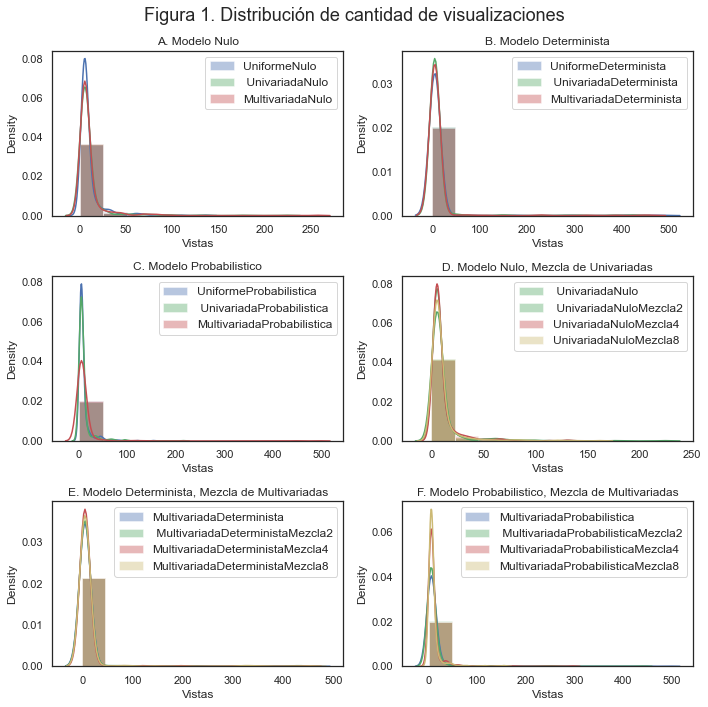

In [283]:
# fig, axes = plt.subplots(3, 2, figsize=(18,18))  CON LOGARITMO
fig, axes = plt.subplots(3, 2, figsize=(10,10)) 
fig.suptitle('Figura 1. Distribución de cantidad de visualizaciones', fontsize=18)

# Nulo
val_min = min(min(UniformeNulo.Vistas),min(UnivariadaNulo.Vistas),min(MultivariadaNulo.Vistas))
val_max = max(max(UniformeNulo.Vistas),max(UnivariadaNulo.Vistas),max(MultivariadaNulo.Vistas))
sns.distplot(UniformeNulo.Vistas,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'UniformeNulo')
sns.distplot(UnivariadaNulo.Vistas,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = ' UnivariadaNulo')
sns.distplot(MultivariadaNulo.Vistas,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'MultivariadaNulo')
axes[0,0].set(xscale="linear")
axes[0,0].legend(loc='best', fontsize=12)
axes[0,0].title.set_text("A. Modelo Nulo")

# Determinista
val_min = min(min(UniformeDeterminista.Vistas),min(UnivariadaDeterminista.Vistas),min(MultivariadaDeterminista.Vistas))
val_max = max(max(UniformeDeterminista.Vistas),max(UnivariadaDeterminista.Vistas),max(MultivariadaDeterminista.Vistas))
sns.distplot(UniformeDeterminista.Vistas,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'UniformeDeterminista')
sns.distplot(UnivariadaDeterminista.Vistas,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = ' UnivariadaDeterminista')
sns.distplot(MultivariadaDeterminista.Vistas,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'MultivariadaDeterminista')
axes[0,1].legend(loc='best', fontsize=12)
axes[0,1].title.set_text("B. Modelo Determinista")

# Probabilistica
val_min = min(min(UniformeProbabilistica.Vistas),min(UnivariadaProbabilistica.Vistas),min(MultivariadaProbabilistica.Vistas))
val_max = max(max(UniformeProbabilistica.Vistas),max(UnivariadaProbabilistica.Vistas),max(MultivariadaProbabilistica.Vistas))
sns.distplot(UniformeProbabilistica.Vistas,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'UniformeProbabilistica')
sns.distplot(UnivariadaProbabilistica.Vistas,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = ' UnivariadaProbabilistica')
sns.distplot(MultivariadaProbabilistica.Vistas,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'MultivariadaProbabilistica')
axes[1,0].legend(loc='best', fontsize=12)
axes[1,0].title.set_text("C. Modelo Probabilistico")

# Univariada Mezclas Nulo
val_min = min(min(UnivariadaNulo.Vistas),min(UnivariadaNuloMezcla2.Vistas),min(UnivariadaNuloMezcla4.Vistas), min(UnivariadaNuloMezcla8.Vistas))
val_max = max(max(UnivariadaNulo.Vistas),max(UnivariadaNuloMezcla2.Vistas),max(UnivariadaNuloMezcla4.Vistas), max(UnivariadaNuloMezcla8.Vistas))
sns.distplot(UnivariadaNulo.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = ' UnivariadaNulo')
sns.distplot(UnivariadaNuloMezcla2.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = ' UnivariadaNuloMezcla2')
sns.distplot(UnivariadaNuloMezcla4.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'UnivariadaNuloMezcla4')
sns.distplot(UnivariadaNuloMezcla8.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'UnivariadaNuloMezcla8')
axes[1,1].legend(loc='best', fontsize=12)
axes[1,1].title.set_text("D. Modelo Nulo, Mezcla de Univariadas")

# Multivariada Mezclas Determinista
val_min = min(min(MultivariadaDeterminista.Vistas),min(MultivariadaDeterministaMezcla2.Vistas),min(MultivariadaDeterministaMezcla4.Vistas), min(MultivariadaDeterministaMezcla8.Vistas))
val_max = max(max(MultivariadaDeterminista.Vistas),max(MultivariadaDeterministaMezcla2.Vistas),max(MultivariadaDeterministaMezcla4.Vistas), max(MultivariadaDeterministaMezcla8.Vistas))
sns.distplot(MultivariadaDeterminista.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'MultivariadaDeterminista')
sns.distplot(MultivariadaDeterministaMezcla2.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = ' MultivariadaDeterministaMezcla2')
sns.distplot(MultivariadaDeterministaMezcla4.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'MultivariadaDeterministaMezcla4')
sns.distplot(MultivariadaDeterministaMezcla8.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'MultivariadaDeterministaMezcla8')
axes[2,0].legend(loc='best', fontsize=12)
axes[2,0].title.set_text("E. Modelo Determinista, Mezcla de Multivariadas")

# Multivariada Mezclas Probabilistica
val_min = min(min(MultivariadaProbabilistica.Vistas),min(MultivariadaProbabilisticaMezcla2.Vistas),min(MultivariadaProbabilisticaMezcla4.Vistas), min(MultivariadaProbabilisticaMezcla8.Vistas))
val_max = max(max(MultivariadaProbabilistica.Vistas),max(MultivariadaProbabilisticaMezcla2.Vistas),max(MultivariadaProbabilisticaMezcla4.Vistas), max(MultivariadaProbabilisticaMezcla8.Vistas))
sns.distplot(MultivariadaProbabilistica.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'MultivariadaProbabilistica')
sns.distplot(MultivariadaProbabilisticaMezcla2.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = ' MultivariadaProbabilisticaMezcla2')
sns.distplot(MultivariadaProbabilisticaMezcla4.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'MultivariadaProbabilisticaMezcla4')
sns.distplot(MultivariadaProbabilisticaMezcla8.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'MultivariadaProbabilisticaMezcla8')
axes[2,1].legend(loc='best', fontsize=12)
axes[2,1].title.set_text("F. Modelo Probabilistico, Mezcla de Multivariadas")


plt.tight_layout()


plt.savefig('F1.png', dpi = 800)

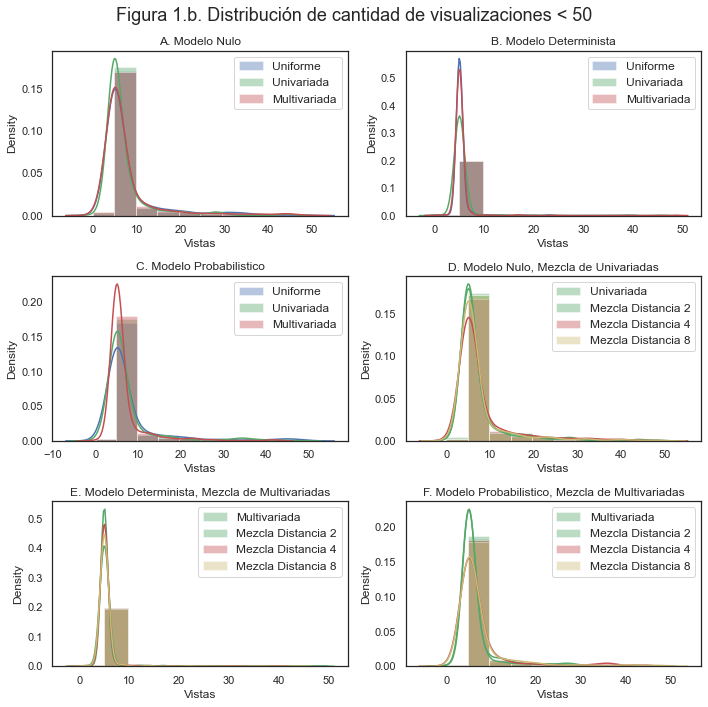

In [329]:
# fig, axes = plt.subplots(3, 2, figsize=(18,18))  CON LOGARITMO
fig, axes = plt.subplots(3, 2, figsize=(10,10)) 
fig.suptitle('Figura 1.b. Distribución de cantidad de visualizaciones < 50', fontsize=18)

# Nulo
UniformeNuloPosFiltrado = UniformeNulo[UniformeNulo.Vistas < 50]
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.Vistas < 50]
MultivariadaNuloPosFiltrado = MultivariadaNulo[MultivariadaNulo.Vistas < 50]
val_min=min(min(UniformeNuloPosFiltrado.Vistas),min(UnivariadaNuloPosFiltrado.Vistas),min(MultivariadaNuloPosFiltrado.Vistas))
val_max=max(max(UniformeNuloPosFiltrado.Vistas),max(UnivariadaNuloPosFiltrado.Vistas),max(MultivariadaNuloPosFiltrado.Vistas))
sns.distplot(UniformeNuloPosFiltrado.Vistas,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaNuloPosFiltrado.Vistas,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaNuloPosFiltrado.Vistas,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,0].legend(loc='best', fontsize=12)
axes[0,0].title.set_text("A. Modelo Nulo")

# Determinista
UniformeDeterministaPosFiltrado = UniformeDeterminista[UniformeDeterminista.Vistas < 50]
UnivariadaDeterministaPosFiltrado = UnivariadaDeterminista[UnivariadaDeterminista.Vistas < 50]
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.Vistas < 50]
val_min = min(min(UniformeDeterministaPosFiltrado.Vistas),min(UnivariadaDeterministaPosFiltrado.Vistas),min(MultivariadaDeterministaPosFiltrado.Vistas))
val_max = max(max(UniformeDeterministaPosFiltrado.Vistas),max(UnivariadaDeterministaPosFiltrado.Vistas),max(MultivariadaDeterministaPosFiltrado.Vistas))
sns.distplot(UniformeDeterministaPosFiltrado.Vistas,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaDeterministaPosFiltrado.Vistas,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaDeterministaPosFiltrado.Vistas,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,1].legend(loc='best', fontsize=12)
axes[0,1].title.set_text("B. Modelo Determinista")

# Probabilistica
UniformeProbabilisticaPosFiltrado = UniformeProbabilistica[UniformeProbabilistica.Vistas < 50]
UnivariadaProbabilisticaPosFiltrado = UnivariadaProbabilistica[UnivariadaProbabilistica.Vistas < 50]
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.Vistas < 50]
val_min = min(min(UniformeProbabilisticaPosFiltrado.Vistas),min(UnivariadaProbabilisticaPosFiltrado.Vistas),min(MultivariadaProbabilisticaPosFiltrado.Vistas))
val_max = max(max(UniformeProbabilisticaPosFiltrado.Vistas),max(UnivariadaProbabilisticaPosFiltrado.Vistas),max(MultivariadaProbabilisticaPosFiltrado.Vistas))
sns.distplot(UniformeProbabilisticaPosFiltrado.Vistas,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaProbabilisticaPosFiltrado.Vistas,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaProbabilisticaPosFiltrado.Vistas,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[1,0].legend(loc='best', fontsize=12)
axes[1,0].title.set_text("C. Modelo Probabilistico")

# Univariada Mezclas Nulo
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.Vistas < 50]
UnivariadaNuloMezcla2PosFiltrado = UnivariadaNuloMezcla2[UnivariadaNuloMezcla2.Vistas < 50]
UnivariadaNuloMezcla4PosFiltrado = UnivariadaNuloMezcla4[UnivariadaNuloMezcla4.Vistas < 50]
UnivariadaNuloMezcla8PosFiltrado = UnivariadaNuloMezcla8[UnivariadaNuloMezcla8.Vistas < 50]
val_min = min(min(UnivariadaNuloPosFiltrado.Vistas),min(UnivariadaNuloMezcla2PosFiltrado.Vistas),min(UnivariadaNuloMezcla4PosFiltrado.Vistas), min(UnivariadaNuloMezcla8PosFiltrado.Vistas))
val_max = max(max(UnivariadaNuloPosFiltrado.Vistas),max(UnivariadaNuloMezcla2PosFiltrado.Vistas),max(UnivariadaNuloMezcla4PosFiltrado.Vistas), max(UnivariadaNuloMezcla8PosFiltrado.Vistas))
sns.distplot(UnivariadaNuloPosFiltrado.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(UnivariadaNuloMezcla2PosFiltrado.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(UnivariadaNuloMezcla4PosFiltrado.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(UnivariadaNuloMezcla8PosFiltrado.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[1,1].legend(loc='best', fontsize=12)
axes[1,1].title.set_text("D. Modelo Nulo, Mezcla de Univariadas")

# Multivariada Mezclas Determinista
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.Vistas < 50]
MultivariadaDeterministaMezcla2PosFiltrado = MultivariadaDeterministaMezcla2[MultivariadaDeterministaMezcla2.Vistas < 50]
MultivariadaDeterministaMezcla4PosFiltrado = MultivariadaDeterministaMezcla4[MultivariadaDeterministaMezcla4.Vistas < 50]
MultivariadaDeterministaMezcla8PosFiltrado = MultivariadaDeterministaMezcla8[MultivariadaDeterministaMezcla8.Vistas < 50]
val_min = min(min(MultivariadaDeterministaPosFiltrado.Vistas),min(MultivariadaDeterministaMezcla2PosFiltrado.Vistas),min(MultivariadaDeterministaMezcla4PosFiltrado.Vistas), min(MultivariadaDeterministaMezcla8PosFiltrado.Vistas))
val_max = max(max(MultivariadaDeterministaPosFiltrado.Vistas),max(MultivariadaDeterministaMezcla2PosFiltrado.Vistas),max(MultivariadaDeterministaMezcla4PosFiltrado.Vistas), max(MultivariadaDeterministaMezcla8PosFiltrado.Vistas))
sns.distplot(MultivariadaDeterministaPosFiltrado.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaDeterministaMezcla2PosFiltrado.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaDeterministaMezcla4PosFiltrado.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaDeterministaMezcla8PosFiltrado.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,0].legend(loc='best', fontsize=12)
axes[2,0].title.set_text("E. Modelo Determinista, Mezcla de Multivariadas")

# Multivariada Mezclas Probabilistica
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.Vistas < 50]
MultivariadaProbabilisticaMezcla2PosFiltrado = MultivariadaProbabilisticaMezcla2[MultivariadaProbabilisticaMezcla2.Vistas < 50]
MultivariadaProbabilisticaMezcla4PosFiltrado = MultivariadaProbabilisticaMezcla4[MultivariadaProbabilisticaMezcla4.Vistas < 50]
MultivariadaProbabilisticaMezcla8PosFiltrado = MultivariadaProbabilisticaMezcla8[MultivariadaProbabilisticaMezcla8.Vistas < 50]
val_min = min(min(MultivariadaProbabilisticaPosFiltrado.Vistas),min(MultivariadaProbabilisticaMezcla2PosFiltrado.Vistas),min(MultivariadaProbabilisticaMezcla4PosFiltrado.Vistas), min(MultivariadaProbabilisticaMezcla8PosFiltrado.Vistas))
val_max = max(max(MultivariadaProbabilisticaPosFiltrado.Vistas),max(MultivariadaProbabilisticaMezcla2PosFiltrado.Vistas),max(MultivariadaProbabilisticaMezcla4PosFiltrado.Vistas), max(MultivariadaProbabilisticaMezcla8PosFiltrado.Vistas))
sns.distplot(MultivariadaProbabilisticaPosFiltrado.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaProbabilisticaMezcla2PosFiltrado.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaProbabilisticaMezcla4PosFiltrado.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaProbabilisticaMezcla8PosFiltrado.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,1].legend(loc='best', fontsize=12)
axes[2,1].title.set_text("F. Modelo Probabilistico, Mezcla de Multivariadas")


plt.tight_layout()


plt.savefig('F1b.png', dpi = 800)



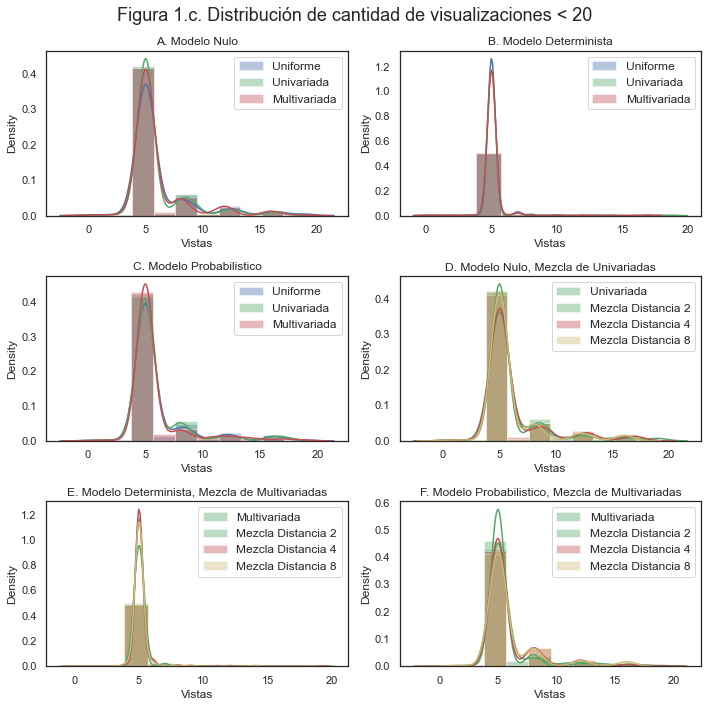

In [330]:
# fig, axes = plt.subplots(3, 2, figsize=(18,18))  CON LOGARITMO
fig, axes = plt.subplots(3, 2, figsize=(10,10)) 
fig.suptitle('Figura 1.c. Distribución de cantidad de visualizaciones < 20', fontsize=18)

# Nulo
UniformeNuloPosFiltrado = UniformeNulo[UniformeNulo.Vistas < 20]
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.Vistas < 20]
MultivariadaNuloPosFiltrado = MultivariadaNulo[MultivariadaNulo.Vistas < 20]
val_min=min(min(UniformeNuloPosFiltrado.Vistas),min(UnivariadaNuloPosFiltrado.Vistas),min(MultivariadaNuloPosFiltrado.Vistas))
val_max=max(max(UniformeNuloPosFiltrado.Vistas),max(UnivariadaNuloPosFiltrado.Vistas),max(MultivariadaNuloPosFiltrado.Vistas))
sns.distplot(UniformeNuloPosFiltrado.Vistas,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaNuloPosFiltrado.Vistas,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaNuloPosFiltrado.Vistas,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,0].legend(loc='best', fontsize=12)
axes[0,0].title.set_text("A. Modelo Nulo")

# Determinista
UniformeDeterministaPosFiltrado = UniformeDeterminista[UniformeDeterminista.Vistas < 20]
UnivariadaDeterministaPosFiltrado = UnivariadaDeterminista[UnivariadaDeterminista.Vistas < 20]
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.Vistas < 20]
val_min = min(min(UniformeDeterministaPosFiltrado.Vistas),min(UnivariadaDeterministaPosFiltrado.Vistas),min(MultivariadaDeterministaPosFiltrado.Vistas))
val_max = max(max(UniformeDeterministaPosFiltrado.Vistas),max(UnivariadaDeterministaPosFiltrado.Vistas),max(MultivariadaDeterministaPosFiltrado.Vistas))
sns.distplot(UniformeDeterministaPosFiltrado.Vistas,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaDeterministaPosFiltrado.Vistas,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaDeterministaPosFiltrado.Vistas,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,1].legend(loc='best', fontsize=12)
axes[0,1].title.set_text("B. Modelo Determinista")

# Probabilistica
UniformeProbabilisticaPosFiltrado = UniformeProbabilistica[UniformeProbabilistica.Vistas < 20]
UnivariadaProbabilisticaPosFiltrado = UnivariadaProbabilistica[UnivariadaProbabilistica.Vistas < 20]
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.Vistas < 20]
val_min = min(min(UniformeProbabilisticaPosFiltrado.Vistas),min(UnivariadaProbabilisticaPosFiltrado.Vistas),min(MultivariadaProbabilisticaPosFiltrado.Vistas))
val_max = max(max(UniformeProbabilisticaPosFiltrado.Vistas),max(UnivariadaProbabilisticaPosFiltrado.Vistas),max(MultivariadaProbabilisticaPosFiltrado.Vistas))
sns.distplot(UniformeProbabilisticaPosFiltrado.Vistas,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaProbabilisticaPosFiltrado.Vistas,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaProbabilisticaPosFiltrado.Vistas,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[1,0].legend(loc='best', fontsize=12)
axes[1,0].title.set_text("C. Modelo Probabilistico")

# Univariada Mezclas Nulo
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.Vistas < 20]
UnivariadaNuloMezcla2PosFiltrado = UnivariadaNuloMezcla2[UnivariadaNuloMezcla2.Vistas < 20]
UnivariadaNuloMezcla4PosFiltrado = UnivariadaNuloMezcla4[UnivariadaNuloMezcla4.Vistas < 20]
UnivariadaNuloMezcla8PosFiltrado = UnivariadaNuloMezcla8[UnivariadaNuloMezcla8.Vistas < 20]
val_min = min(min(UnivariadaNuloPosFiltrado.Vistas),min(UnivariadaNuloMezcla2PosFiltrado.Vistas),min(UnivariadaNuloMezcla4PosFiltrado.Vistas), min(UnivariadaNuloMezcla8PosFiltrado.Vistas))
val_max = max(max(UnivariadaNuloPosFiltrado.Vistas),max(UnivariadaNuloMezcla2PosFiltrado.Vistas),max(UnivariadaNuloMezcla4PosFiltrado.Vistas), max(UnivariadaNuloMezcla8PosFiltrado.Vistas))
sns.distplot(UnivariadaNuloPosFiltrado.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(UnivariadaNuloMezcla2PosFiltrado.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(UnivariadaNuloMezcla4PosFiltrado.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(UnivariadaNuloMezcla8PosFiltrado.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[1,1].legend(loc='best', fontsize=12)
axes[1,1].title.set_text("D. Modelo Nulo, Mezcla de Univariadas")

# Multivariada Mezclas Determinista
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.Vistas < 20]
MultivariadaDeterministaMezcla2PosFiltrado = MultivariadaDeterministaMezcla2[MultivariadaDeterministaMezcla2.Vistas < 20]
MultivariadaDeterministaMezcla4PosFiltrado = MultivariadaDeterministaMezcla4[MultivariadaDeterministaMezcla4.Vistas < 20]
MultivariadaDeterministaMezcla8PosFiltrado = MultivariadaDeterministaMezcla8[MultivariadaDeterministaMezcla8.Vistas < 20]
val_min = min(min(MultivariadaDeterministaPosFiltrado.Vistas),min(MultivariadaDeterministaMezcla2PosFiltrado.Vistas),min(MultivariadaDeterministaMezcla4PosFiltrado.Vistas), min(MultivariadaDeterministaMezcla8PosFiltrado.Vistas))
val_max = max(max(MultivariadaDeterministaPosFiltrado.Vistas),max(MultivariadaDeterministaMezcla2PosFiltrado.Vistas),max(MultivariadaDeterministaMezcla4PosFiltrado.Vistas), max(MultivariadaDeterministaMezcla8PosFiltrado.Vistas))
sns.distplot(MultivariadaDeterministaPosFiltrado.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaDeterministaMezcla2PosFiltrado.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaDeterministaMezcla4PosFiltrado.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaDeterministaMezcla8PosFiltrado.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,0].legend(loc='best', fontsize=12)
axes[2,0].title.set_text("E. Modelo Determinista, Mezcla de Multivariadas")

# Multivariada Mezclas Probabilistica
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.Vistas < 20]
MultivariadaProbabilisticaMezcla2PosFiltrado = MultivariadaProbabilisticaMezcla2[MultivariadaProbabilisticaMezcla2.Vistas < 20]
MultivariadaProbabilisticaMezcla4PosFiltrado = MultivariadaProbabilisticaMezcla4[MultivariadaProbabilisticaMezcla4.Vistas < 20]
MultivariadaProbabilisticaMezcla8PosFiltrado = MultivariadaProbabilisticaMezcla8[MultivariadaProbabilisticaMezcla8.Vistas < 20]
val_min = min(min(MultivariadaProbabilisticaPosFiltrado.Vistas),min(MultivariadaProbabilisticaMezcla2PosFiltrado.Vistas),min(MultivariadaProbabilisticaMezcla4PosFiltrado.Vistas), min(MultivariadaProbabilisticaMezcla8PosFiltrado.Vistas))
val_max = max(max(MultivariadaProbabilisticaPosFiltrado.Vistas),max(MultivariadaProbabilisticaMezcla2PosFiltrado.Vistas),max(MultivariadaProbabilisticaMezcla4PosFiltrado.Vistas), max(MultivariadaProbabilisticaMezcla8PosFiltrado.Vistas))
sns.distplot(MultivariadaProbabilisticaPosFiltrado.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaProbabilisticaMezcla2PosFiltrado.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaProbabilisticaMezcla4PosFiltrado.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaProbabilisticaMezcla8PosFiltrado.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,1].legend(loc='best', fontsize=12)
axes[2,1].title.set_text("F. Modelo Probabilistico, Mezcla de Multivariadas")


plt.tight_layout()


plt.savefig('F1c.png', dpi = 800)



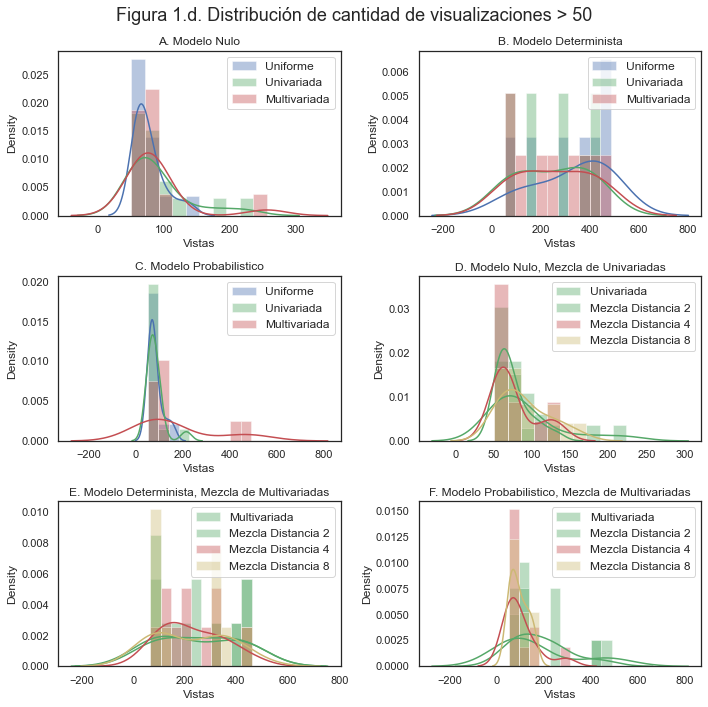

In [331]:
# fig, axes = plt.subplots(3, 2, figsize=(18,18))  CON LOGARITMO
fig, axes = plt.subplots(3, 2, figsize=(10,10)) 
fig.suptitle('Figura 1.d. Distribución de cantidad de visualizaciones > 50', fontsize=18)

# Nulo
UniformeNuloPosFiltrado = UniformeNulo[UniformeNulo.Vistas > 50]
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.Vistas > 50]
MultivariadaNuloPosFiltrado = MultivariadaNulo[MultivariadaNulo.Vistas > 50]
val_min=min(min(UniformeNuloPosFiltrado.Vistas),min(UnivariadaNuloPosFiltrado.Vistas),min(MultivariadaNuloPosFiltrado.Vistas))
val_max=max(max(UniformeNuloPosFiltrado.Vistas),max(UnivariadaNuloPosFiltrado.Vistas),max(MultivariadaNuloPosFiltrado.Vistas))
sns.distplot(UniformeNuloPosFiltrado.Vistas,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaNuloPosFiltrado.Vistas,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaNuloPosFiltrado.Vistas,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,0].legend(loc='best', fontsize=12)
axes[0,0].title.set_text("A. Modelo Nulo")

# Determinista
UniformeDeterministaPosFiltrado = UniformeDeterminista[UniformeDeterminista.Vistas > 50]
UnivariadaDeterministaPosFiltrado = UnivariadaDeterminista[UnivariadaDeterminista.Vistas > 50]
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.Vistas > 50]
val_min = min(min(UniformeDeterministaPosFiltrado.Vistas),min(UnivariadaDeterministaPosFiltrado.Vistas),min(MultivariadaDeterministaPosFiltrado.Vistas))
val_max = max(max(UniformeDeterministaPosFiltrado.Vistas),max(UnivariadaDeterministaPosFiltrado.Vistas),max(MultivariadaDeterministaPosFiltrado.Vistas))
sns.distplot(UniformeDeterministaPosFiltrado.Vistas,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaDeterministaPosFiltrado.Vistas,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaDeterministaPosFiltrado.Vistas,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,1].legend(loc='best', fontsize=12)
axes[0,1].title.set_text("B. Modelo Determinista")

# Probabilistica
UniformeProbabilisticaPosFiltrado = UniformeProbabilistica[UniformeProbabilistica.Vistas > 50]
UnivariadaProbabilisticaPosFiltrado = UnivariadaProbabilistica[UnivariadaProbabilistica.Vistas > 50]
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.Vistas > 50]
val_min = min(min(UniformeProbabilisticaPosFiltrado.Vistas),min(UnivariadaProbabilisticaPosFiltrado.Vistas),min(MultivariadaProbabilisticaPosFiltrado.Vistas))
val_max = max(max(UniformeProbabilisticaPosFiltrado.Vistas),max(UnivariadaProbabilisticaPosFiltrado.Vistas),max(MultivariadaProbabilisticaPosFiltrado.Vistas))
sns.distplot(UniformeProbabilisticaPosFiltrado.Vistas,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaProbabilisticaPosFiltrado.Vistas,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaProbabilisticaPosFiltrado.Vistas,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[1,0].legend(loc='best', fontsize=12)
axes[1,0].title.set_text("C. Modelo Probabilistico")

# Univariada Mezclas Nulo
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.Vistas > 50]
UnivariadaNuloMezcla2PosFiltrado = UnivariadaNuloMezcla2[UnivariadaNuloMezcla2.Vistas > 50]
UnivariadaNuloMezcla4PosFiltrado = UnivariadaNuloMezcla4[UnivariadaNuloMezcla4.Vistas > 50]
UnivariadaNuloMezcla8PosFiltrado = UnivariadaNuloMezcla8[UnivariadaNuloMezcla8.Vistas > 50]
val_min = min(min(UnivariadaNuloPosFiltrado.Vistas),min(UnivariadaNuloMezcla2PosFiltrado.Vistas),min(UnivariadaNuloMezcla4PosFiltrado.Vistas), min(UnivariadaNuloMezcla8PosFiltrado.Vistas))
val_max = max(max(UnivariadaNuloPosFiltrado.Vistas),max(UnivariadaNuloMezcla2PosFiltrado.Vistas),max(UnivariadaNuloMezcla4PosFiltrado.Vistas), max(UnivariadaNuloMezcla8PosFiltrado.Vistas))
sns.distplot(UnivariadaNuloPosFiltrado.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(UnivariadaNuloMezcla2PosFiltrado.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(UnivariadaNuloMezcla4PosFiltrado.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(UnivariadaNuloMezcla8PosFiltrado.Vistas,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[1,1].legend(loc='best', fontsize=12)
axes[1,1].title.set_text("D. Modelo Nulo, Mezcla de Univariadas")

# Multivariada Mezclas Determinista
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.Vistas > 50]
MultivariadaDeterministaMezcla2PosFiltrado = MultivariadaDeterministaMezcla2[MultivariadaDeterministaMezcla2.Vistas > 50]
MultivariadaDeterministaMezcla4PosFiltrado = MultivariadaDeterministaMezcla4[MultivariadaDeterministaMezcla4.Vistas > 50]
MultivariadaDeterministaMezcla8PosFiltrado = MultivariadaDeterministaMezcla8[MultivariadaDeterministaMezcla8.Vistas > 50]
val_min = min(min(MultivariadaDeterministaPosFiltrado.Vistas),min(MultivariadaDeterministaMezcla2PosFiltrado.Vistas),min(MultivariadaDeterministaMezcla4PosFiltrado.Vistas), min(MultivariadaDeterministaMezcla8PosFiltrado.Vistas))
val_max = max(max(MultivariadaDeterministaPosFiltrado.Vistas),max(MultivariadaDeterministaMezcla2PosFiltrado.Vistas),max(MultivariadaDeterministaMezcla4PosFiltrado.Vistas), max(MultivariadaDeterministaMezcla8PosFiltrado.Vistas))
sns.distplot(MultivariadaDeterministaPosFiltrado.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaDeterministaMezcla2PosFiltrado.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaDeterministaMezcla4PosFiltrado.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaDeterministaMezcla8PosFiltrado.Vistas,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,0].legend(loc='best', fontsize=12)
axes[2,0].title.set_text("E. Modelo Determinista, Mezcla de Multivariadas")

# Multivariada Mezclas Probabilistica
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.Vistas > 50]
MultivariadaProbabilisticaMezcla2PosFiltrado = MultivariadaProbabilisticaMezcla2[MultivariadaProbabilisticaMezcla2.Vistas > 50]
MultivariadaProbabilisticaMezcla4PosFiltrado = MultivariadaProbabilisticaMezcla4[MultivariadaProbabilisticaMezcla4.Vistas > 50]
MultivariadaProbabilisticaMezcla8PosFiltrado = MultivariadaProbabilisticaMezcla8[MultivariadaProbabilisticaMezcla8.Vistas > 50]
val_min = min(min(MultivariadaProbabilisticaPosFiltrado.Vistas),min(MultivariadaProbabilisticaMezcla2PosFiltrado.Vistas),min(MultivariadaProbabilisticaMezcla4PosFiltrado.Vistas), min(MultivariadaProbabilisticaMezcla8PosFiltrado.Vistas))
val_max = max(max(MultivariadaProbabilisticaPosFiltrado.Vistas),max(MultivariadaProbabilisticaMezcla2PosFiltrado.Vistas),max(MultivariadaProbabilisticaMezcla4PosFiltrado.Vistas), max(MultivariadaProbabilisticaMezcla8PosFiltrado.Vistas))
sns.distplot(MultivariadaProbabilisticaPosFiltrado.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaProbabilisticaMezcla2PosFiltrado.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaProbabilisticaMezcla4PosFiltrado.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaProbabilisticaMezcla8PosFiltrado.Vistas,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,1].legend(loc='best', fontsize=12)
axes[2,1].title.set_text("F. Modelo Probabilistico, Mezcla de Multivariadas")


plt.tight_layout()


plt.savefig('F1d.png', dpi = 800)



# Figura 2.a. Distribución de cantidad de votos positivos

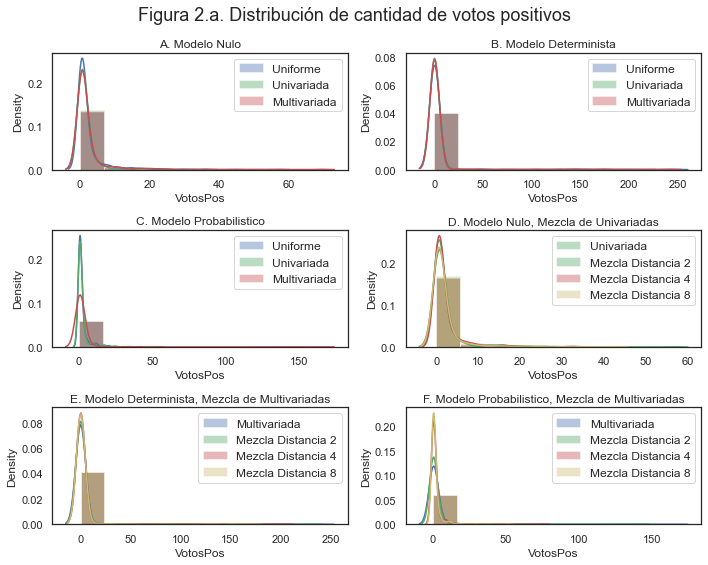

In [328]:
fig, axes = plt.subplots(3, 2, figsize=(10, 8)) 
fig.suptitle('Figura 2.a. Distribución de cantidad de votos positivos', fontsize=18)

# Nulo
val_min = min(min(UniformeNulo.VotosPos),min(UnivariadaNulo.VotosPos),min(MultivariadaNulo.VotosPos))
val_max = max(max(UniformeNulo.VotosPos),max(UnivariadaNulo.VotosPos),max(MultivariadaNulo.VotosPos))
sns.distplot(UniformeNulo.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaNulo.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaNulo.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,0].legend(loc='best', fontsize=12)
axes[0,0].title.set_text("A. Modelo Nulo")

# Determinista
val_min = min(min(UniformeDeterminista.VotosPos),min(UnivariadaDeterminista.VotosPos),min(MultivariadaDeterminista.VotosPos))
val_max = max(max(UniformeDeterminista.VotosPos),max(UnivariadaDeterminista.VotosPos),max(MultivariadaDeterminista.VotosPos))
sns.distplot(UniformeDeterminista.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaDeterminista.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaDeterminista.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,1].legend(loc='best', fontsize=12)
axes[0,1].title.set_text("B. Modelo Determinista")

# Probabilistica
val_min = min(min(UniformeProbabilistica.VotosPos),min(UnivariadaProbabilistica.VotosPos),min(MultivariadaProbabilistica.VotosPos))
val_max = max(max(UniformeProbabilistica.VotosPos),max(UnivariadaProbabilistica.VotosPos),max(MultivariadaProbabilistica.VotosPos))
sns.distplot(UniformeProbabilistica.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaProbabilistica.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaProbabilistica.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[1,0].legend(loc='best', fontsize=12)
axes[1,0].title.set_text("C. Modelo Probabilistico")

# Univariada Mezclas Nulo
val_min = min(min(UnivariadaNulo.VotosPos),min(UnivariadaNuloMezcla2.VotosPos),min(UnivariadaNuloMezcla4.VotosPos), min(UnivariadaNuloMezcla8.VotosPos))
val_max = max(max(UnivariadaNulo.VotosPos),max(UnivariadaNuloMezcla2.VotosPos),max(UnivariadaNuloMezcla4.VotosPos), max(UnivariadaNuloMezcla8.VotosPos))
sns.distplot(UnivariadaNulo.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(UnivariadaNuloMezcla2.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(UnivariadaNuloMezcla4.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(UnivariadaNuloMezcla8.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[1,1].legend(loc='best', fontsize=12)
axes[1,1].title.set_text("D. Modelo Nulo, Mezcla de Univariadas")

# Multivariada Mezclas Determinista
val_min = min(min(MultivariadaDeterminista.VotosPos),min(MultivariadaDeterministaMezcla2.VotosPos),min(MultivariadaDeterministaMezcla4.VotosPos), min(MultivariadaDeterministaMezcla8.VotosPos))
val_max = max(max(MultivariadaDeterminista.VotosPos),max(MultivariadaDeterministaMezcla2.VotosPos),max(MultivariadaDeterministaMezcla4.VotosPos), max(MultivariadaDeterministaMezcla8.VotosPos))
sns.distplot(MultivariadaDeterminista.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Multivariada')
sns.distplot(MultivariadaDeterministaMezcla2.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaDeterministaMezcla4.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaDeterministaMezcla8.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,0].legend(loc='best', fontsize=12)
axes[2,0].title.set_text("E. Modelo Determinista, Mezcla de Multivariadas")

# Multivariada Mezclas Probabilistica
val_min = min(min(MultivariadaProbabilistica.VotosPos),min(MultivariadaProbabilisticaMezcla2.VotosPos),min(MultivariadaProbabilisticaMezcla4.VotosPos), min(MultivariadaProbabilisticaMezcla8.VotosPos))
val_max = max(max(MultivariadaProbabilistica.VotosPos),max(MultivariadaProbabilisticaMezcla2.VotosPos),max(MultivariadaProbabilisticaMezcla4.VotosPos), max(MultivariadaProbabilisticaMezcla8.VotosPos))
sns.distplot(MultivariadaProbabilistica.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Multivariada')
sns.distplot(MultivariadaProbabilisticaMezcla2.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaProbabilisticaMezcla4.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaProbabilisticaMezcla8.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,1].legend(loc='best', fontsize=12)
axes[2,1].title.set_text("F. Modelo Probabilistico, Mezcla de Multivariadas")


plt.tight_layout()


plt.savefig('F2a.png', dpi = 800)

# Figura 2.b Distribución de cantidad de votos positivos > 0

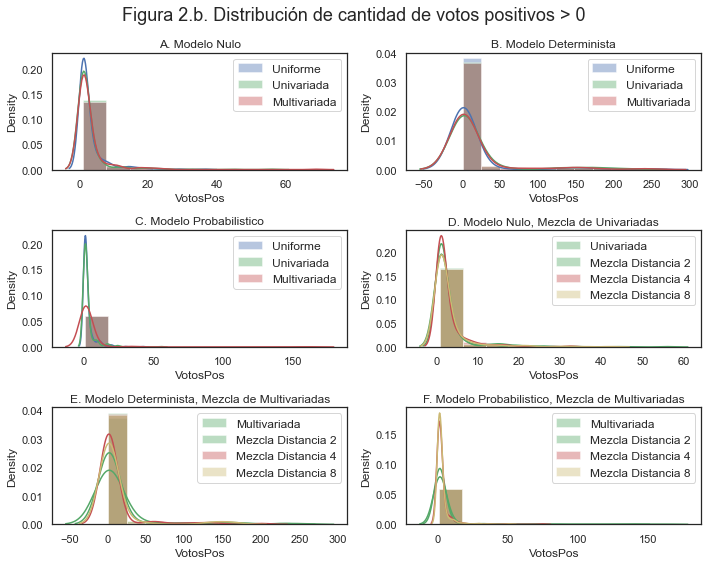

In [327]:
fig, axes = plt.subplots(3, 2, figsize=(10,8)) 
fig.suptitle('Figura 2.b. Distribución de cantidad de votos positivos > 0', fontsize=18)

# Nulo
UniformeNuloPosFiltrado = UniformeNulo[UniformeNulo.VotosPos > 0]
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.VotosPos > 0]
MultivariadaNuloPosFiltrado = MultivariadaNulo[MultivariadaNulo.VotosPos > 0]
val_min=min(min(UniformeNuloPosFiltrado.VotosPos),min(UnivariadaNuloPosFiltrado.VotosPos),min(MultivariadaNuloPosFiltrado.VotosPos))
val_max=max(max(UniformeNuloPosFiltrado.VotosPos),max(UnivariadaNuloPosFiltrado.VotosPos),max(MultivariadaNuloPosFiltrado.VotosPos))
sns.distplot(UniformeNuloPosFiltrado.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaNuloPosFiltrado.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaNuloPosFiltrado.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,0].legend(loc='best', fontsize=12)
axes[0,0].title.set_text("A. Modelo Nulo")

# Determinista
UniformeDeterministaPosFiltrado = UniformeDeterminista[UniformeDeterminista.VotosPos > 0]
UnivariadaDeterministaPosFiltrado = UnivariadaDeterminista[UnivariadaDeterminista.VotosPos > 0]
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.VotosPos > 0]
val_min = min(min(UniformeDeterministaPosFiltrado.VotosPos),min(UnivariadaDeterministaPosFiltrado.VotosPos),min(MultivariadaDeterministaPosFiltrado.VotosPos))
val_max = max(max(UniformeDeterministaPosFiltrado.VotosPos),max(UnivariadaDeterministaPosFiltrado.VotosPos),max(MultivariadaDeterministaPosFiltrado.VotosPos))
sns.distplot(UniformeDeterministaPosFiltrado.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaDeterministaPosFiltrado.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaDeterministaPosFiltrado.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,1].legend(loc='best', fontsize=12)
axes[0,1].title.set_text("B. Modelo Determinista")

# Probabilistica
UniformeProbabilisticaPosFiltrado = UniformeProbabilistica[UniformeProbabilistica.VotosPos > 0]
UnivariadaProbabilisticaPosFiltrado = UnivariadaProbabilistica[UnivariadaProbabilistica.VotosPos > 0]
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.VotosPos > 0]
val_min = min(min(UniformeProbabilisticaPosFiltrado.VotosPos),min(UnivariadaProbabilisticaPosFiltrado.VotosPos),min(MultivariadaProbabilisticaPosFiltrado.VotosPos))
val_max = max(max(UniformeProbabilisticaPosFiltrado.VotosPos),max(UnivariadaProbabilisticaPosFiltrado.VotosPos),max(MultivariadaProbabilisticaPosFiltrado.VotosPos))
sns.distplot(UniformeProbabilisticaPosFiltrado.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaProbabilisticaPosFiltrado.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaProbabilisticaPosFiltrado.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[1,0].legend(loc='best', fontsize=12)
axes[1,0].title.set_text("C. Modelo Probabilistico")

# Univariada Mezclas Nulo
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.VotosPos > 0]
UnivariadaNuloMezcla2PosFiltrado = UnivariadaNuloMezcla2[UnivariadaNuloMezcla2.VotosPos > 0]
UnivariadaNuloMezcla4PosFiltrado = UnivariadaNuloMezcla4[UnivariadaNuloMezcla4.VotosPos > 0]
UnivariadaNuloMezcla8PosFiltrado = UnivariadaNuloMezcla8[UnivariadaNuloMezcla8.VotosPos > 0]
val_min = min(min(UnivariadaNuloPosFiltrado.VotosPos),min(UnivariadaNuloMezcla2PosFiltrado.VotosPos),min(UnivariadaNuloMezcla4PosFiltrado.VotosPos), min(UnivariadaNuloMezcla8PosFiltrado.VotosPos))
val_max = max(max(UnivariadaNuloPosFiltrado.VotosPos),max(UnivariadaNuloMezcla2PosFiltrado.VotosPos),max(UnivariadaNuloMezcla4PosFiltrado.VotosPos), max(UnivariadaNuloMezcla8PosFiltrado.VotosPos))
sns.distplot(UnivariadaNuloPosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(UnivariadaNuloMezcla2PosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(UnivariadaNuloMezcla4PosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(UnivariadaNuloMezcla8PosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[1,1].legend(loc='best', fontsize=12)
axes[1,1].title.set_text("D. Modelo Nulo, Mezcla de Univariadas")

# Multivariada Mezclas Determinista
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.VotosPos > 0]
MultivariadaDeterministaMezcla2PosFiltrado = MultivariadaDeterministaMezcla2[MultivariadaDeterministaMezcla2.VotosPos > 0]
MultivariadaDeterministaMezcla4PosFiltrado = MultivariadaDeterministaMezcla4[MultivariadaDeterministaMezcla4.VotosPos > 0]
MultivariadaDeterministaMezcla8PosFiltrado = MultivariadaDeterministaMezcla8[MultivariadaDeterministaMezcla8.VotosPos > 0]
val_min = min(min(MultivariadaDeterministaPosFiltrado.VotosPos),min(MultivariadaDeterministaMezcla2PosFiltrado.VotosPos),min(MultivariadaDeterministaMezcla4PosFiltrado.VotosPos), min(MultivariadaDeterministaMezcla8PosFiltrado.VotosPos))
val_max = max(max(MultivariadaDeterministaPosFiltrado.VotosPos),max(MultivariadaDeterministaMezcla2PosFiltrado.VotosPos),max(MultivariadaDeterministaMezcla4PosFiltrado.VotosPos), max(MultivariadaDeterministaMezcla8PosFiltrado.VotosPos))
sns.distplot(MultivariadaDeterministaPosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaDeterministaMezcla2PosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaDeterministaMezcla4PosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaDeterministaMezcla8PosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,0].legend(loc='best', fontsize=12)
axes[2,0].title.set_text("E. Modelo Determinista, Mezcla de Multivariadas")

# Multivariada Mezclas Probabilistica
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.VotosPos > 0]
MultivariadaProbabilisticaMezcla2PosFiltrado = MultivariadaProbabilisticaMezcla2[MultivariadaProbabilisticaMezcla2.VotosPos > 0]
MultivariadaProbabilisticaMezcla4PosFiltrado = MultivariadaProbabilisticaMezcla4[MultivariadaProbabilisticaMezcla4.VotosPos > 0]
MultivariadaProbabilisticaMezcla8PosFiltrado = MultivariadaProbabilisticaMezcla8[MultivariadaProbabilisticaMezcla8.VotosPos > 0]
val_min = min(min(MultivariadaProbabilisticaPosFiltrado.VotosPos),min(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosPos),min(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosPos), min(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosPos))
val_max = max(max(MultivariadaProbabilisticaPosFiltrado.VotosPos),max(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosPos),max(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosPos), max(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosPos))
sns.distplot(MultivariadaProbabilisticaPosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,1].legend(loc='best', fontsize=12)
axes[2,1].title.set_text("F. Modelo Probabilistico, Mezcla de Multivariadas")


plt.tight_layout()


plt.savefig('F2b.png', dpi = 800)

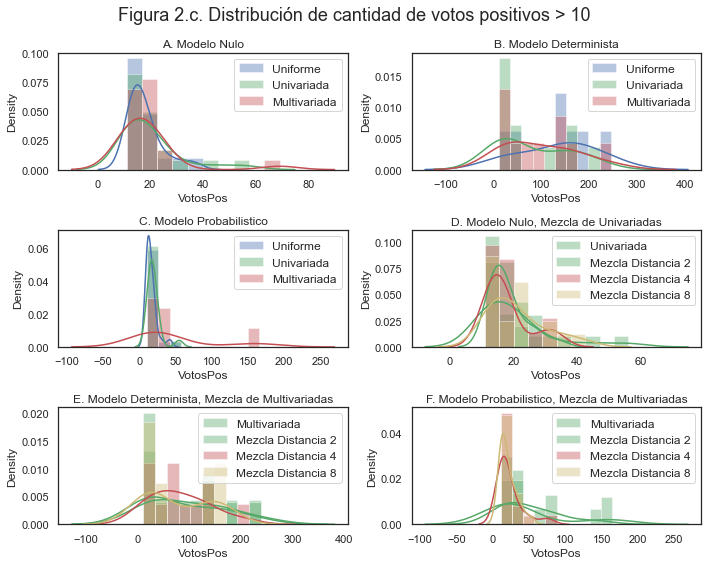

In [321]:
fig, axes = plt.subplots(3, 2, figsize=(10,8)) 
fig.suptitle('Figura 2.c. Distribución de cantidad de votos positivos > 10', fontsize=18)

# Nulo
UniformeNuloPosFiltrado = UniformeNulo[UniformeNulo.VotosPos > 10]
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.VotosPos > 10]
MultivariadaNuloPosFiltrado = MultivariadaNulo[MultivariadaNulo.VotosPos > 10]
val_min=min(min(UniformeNuloPosFiltrado.VotosPos),min(UnivariadaNuloPosFiltrado.VotosPos),min(MultivariadaNuloPosFiltrado.VotosPos))
val_max=max(max(UniformeNuloPosFiltrado.VotosPos),max(UnivariadaNuloPosFiltrado.VotosPos),max(MultivariadaNuloPosFiltrado.VotosPos))
sns.distplot(UniformeNuloPosFiltrado.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaNuloPosFiltrado.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaNuloPosFiltrado.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,0].legend(loc='best', fontsize=12)
axes[0,0].title.set_text("A. Modelo Nulo")

# Determinista
UniformeDeterministaPosFiltrado = UniformeDeterminista[UniformeDeterminista.VotosPos > 10]
UnivariadaDeterministaPosFiltrado = UnivariadaDeterminista[UnivariadaDeterminista.VotosPos > 10]
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.VotosPos > 10]
val_min = min(min(UniformeDeterministaPosFiltrado.VotosPos),min(UnivariadaDeterministaPosFiltrado.VotosPos),min(MultivariadaDeterministaPosFiltrado.VotosPos))
val_max = max(max(UniformeDeterministaPosFiltrado.VotosPos),max(UnivariadaDeterministaPosFiltrado.VotosPos),max(MultivariadaDeterministaPosFiltrado.VotosPos))
sns.distplot(UniformeDeterministaPosFiltrado.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaDeterministaPosFiltrado.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaDeterministaPosFiltrado.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,1].legend(loc='best', fontsize=12)
axes[0,1].title.set_text("B. Modelo Determinista")

# Probabilistica
UniformeProbabilisticaPosFiltrado = UniformeProbabilistica[UniformeProbabilistica.VotosPos > 10]
UnivariadaProbabilisticaPosFiltrado = UnivariadaProbabilistica[UnivariadaProbabilistica.VotosPos > 10]
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.VotosPos > 10]
val_min = min(min(UniformeProbabilisticaPosFiltrado.VotosPos),min(UnivariadaProbabilisticaPosFiltrado.VotosPos),min(MultivariadaProbabilisticaPosFiltrado.VotosPos))
val_max = max(max(UniformeProbabilisticaPosFiltrado.VotosPos),max(UnivariadaProbabilisticaPosFiltrado.VotosPos),max(MultivariadaProbabilisticaPosFiltrado.VotosPos))
sns.distplot(UniformeProbabilisticaPosFiltrado.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaProbabilisticaPosFiltrado.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaProbabilisticaPosFiltrado.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[1,0].legend(loc='best', fontsize=12)
axes[1,0].title.set_text("C. Modelo Probabilistico")

# Univariada Mezclas Nulo
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.VotosPos > 10]
UnivariadaNuloMezcla2PosFiltrado = UnivariadaNuloMezcla2[UnivariadaNuloMezcla2.VotosPos > 10]
UnivariadaNuloMezcla4PosFiltrado = UnivariadaNuloMezcla4[UnivariadaNuloMezcla4.VotosPos > 10]
UnivariadaNuloMezcla8PosFiltrado = UnivariadaNuloMezcla8[UnivariadaNuloMezcla8.VotosPos > 10]
val_min = min(min(UnivariadaNuloPosFiltrado.VotosPos),min(UnivariadaNuloMezcla2PosFiltrado.VotosPos),min(UnivariadaNuloMezcla4PosFiltrado.VotosPos), min(UnivariadaNuloMezcla8PosFiltrado.VotosPos))
val_max = max(max(UnivariadaNuloPosFiltrado.VotosPos),max(UnivariadaNuloMezcla2PosFiltrado.VotosPos),max(UnivariadaNuloMezcla4PosFiltrado.VotosPos), max(UnivariadaNuloMezcla8PosFiltrado.VotosPos))
sns.distplot(UnivariadaNuloPosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(UnivariadaNuloMezcla2PosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(UnivariadaNuloMezcla4PosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(UnivariadaNuloMezcla8PosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[1,1].legend(loc='best', fontsize=12)
axes[1,1].title.set_text("D. Modelo Nulo, Mezcla de Univariadas")

# Multivariada Mezclas Determinista
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.VotosPos > 10]
MultivariadaDeterministaMezcla2PosFiltrado = MultivariadaDeterministaMezcla2[MultivariadaDeterministaMezcla2.VotosPos > 10]
MultivariadaDeterministaMezcla4PosFiltrado = MultivariadaDeterministaMezcla4[MultivariadaDeterministaMezcla4.VotosPos > 10]
MultivariadaDeterministaMezcla8PosFiltrado = MultivariadaDeterministaMezcla8[MultivariadaDeterministaMezcla8.VotosPos > 10]
val_min = min(min(MultivariadaDeterministaPosFiltrado.VotosPos),min(MultivariadaDeterministaMezcla2PosFiltrado.VotosPos),min(MultivariadaDeterministaMezcla4PosFiltrado.VotosPos), min(MultivariadaDeterministaMezcla8PosFiltrado.VotosPos))
val_max = max(max(MultivariadaDeterministaPosFiltrado.VotosPos),max(MultivariadaDeterministaMezcla2PosFiltrado.VotosPos),max(MultivariadaDeterministaMezcla4PosFiltrado.VotosPos), max(MultivariadaDeterministaMezcla8PosFiltrado.VotosPos))
sns.distplot(MultivariadaDeterministaPosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaDeterministaMezcla2PosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaDeterministaMezcla4PosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaDeterministaMezcla8PosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,0].legend(loc='best', fontsize=12)
axes[2,0].title.set_text("E. Modelo Determinista, Mezcla de Multivariadas")

# Multivariada Mezclas Probabilistica
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.VotosPos > 10]
MultivariadaProbabilisticaMezcla2PosFiltrado = MultivariadaProbabilisticaMezcla2[MultivariadaProbabilisticaMezcla2.VotosPos > 10]
MultivariadaProbabilisticaMezcla4PosFiltrado = MultivariadaProbabilisticaMezcla4[MultivariadaProbabilisticaMezcla4.VotosPos > 10]
MultivariadaProbabilisticaMezcla8PosFiltrado = MultivariadaProbabilisticaMezcla8[MultivariadaProbabilisticaMezcla8.VotosPos > 10]
val_min = min(min(MultivariadaProbabilisticaPosFiltrado.VotosPos),min(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosPos),min(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosPos), min(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosPos))
val_max = max(max(MultivariadaProbabilisticaPosFiltrado.VotosPos),max(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosPos),max(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosPos), max(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosPos))
sns.distplot(MultivariadaProbabilisticaPosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,1].legend(loc='best', fontsize=12)
axes[2,1].title.set_text("F. Modelo Probabilistico, Mezcla de Multivariadas")


plt.tight_layout()


plt.savefig('F2c.png', dpi = 800)

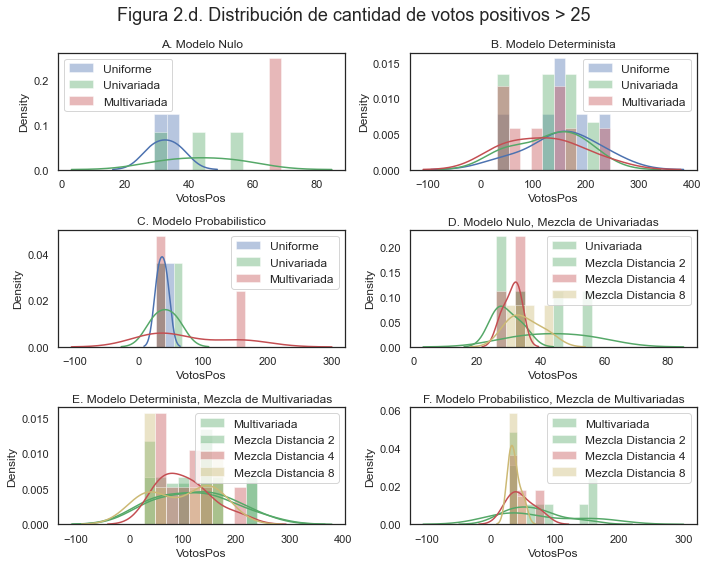

In [322]:
fig, axes = plt.subplots(3, 2, figsize=(10,8)) 
fig.suptitle('Figura 2.d. Distribución de cantidad de votos positivos > 25', fontsize=18)

# Nulo
UniformeNuloPosFiltrado = UniformeNulo[UniformeNulo.VotosPos > 25]
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.VotosPos > 25]
MultivariadaNuloPosFiltrado = MultivariadaNulo[MultivariadaNulo.VotosPos > 25]
val_min=min(min(UniformeNuloPosFiltrado.VotosPos),min(UnivariadaNuloPosFiltrado.VotosPos),min(MultivariadaNuloPosFiltrado.VotosPos))
val_max=max(max(UniformeNuloPosFiltrado.VotosPos),max(UnivariadaNuloPosFiltrado.VotosPos),max(MultivariadaNuloPosFiltrado.VotosPos))
sns.distplot(UniformeNuloPosFiltrado.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaNuloPosFiltrado.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaNuloPosFiltrado.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,0].legend(loc='best', fontsize=12)
axes[0,0].title.set_text("A. Modelo Nulo")

# Determinista
UniformeDeterministaPosFiltrado = UniformeDeterminista[UniformeDeterminista.VotosPos > 25]
UnivariadaDeterministaPosFiltrado = UnivariadaDeterminista[UnivariadaDeterminista.VotosPos > 25]
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.VotosPos > 25]
val_min = min(min(UniformeDeterministaPosFiltrado.VotosPos),min(UnivariadaDeterministaPosFiltrado.VotosPos),min(MultivariadaDeterministaPosFiltrado.VotosPos))
val_max = max(max(UniformeDeterministaPosFiltrado.VotosPos),max(UnivariadaDeterministaPosFiltrado.VotosPos),max(MultivariadaDeterministaPosFiltrado.VotosPos))
sns.distplot(UniformeDeterministaPosFiltrado.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaDeterministaPosFiltrado.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaDeterministaPosFiltrado.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,1].legend(loc='best', fontsize=12)
axes[0,1].title.set_text("B. Modelo Determinista")

# Probabilistica
UniformeProbabilisticaPosFiltrado = UniformeProbabilistica[UniformeProbabilistica.VotosPos > 25]
UnivariadaProbabilisticaPosFiltrado = UnivariadaProbabilistica[UnivariadaProbabilistica.VotosPos > 25]
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.VotosPos > 25]
val_min = min(min(UniformeProbabilisticaPosFiltrado.VotosPos),min(UnivariadaProbabilisticaPosFiltrado.VotosPos),min(MultivariadaProbabilisticaPosFiltrado.VotosPos))
val_max = max(max(UniformeProbabilisticaPosFiltrado.VotosPos),max(UnivariadaProbabilisticaPosFiltrado.VotosPos),max(MultivariadaProbabilisticaPosFiltrado.VotosPos))
sns.distplot(UniformeProbabilisticaPosFiltrado.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaProbabilisticaPosFiltrado.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaProbabilisticaPosFiltrado.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[1,0].legend(loc='best', fontsize=12)
axes[1,0].title.set_text("C. Modelo Probabilistico")

# Univariada Mezclas Nulo
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.VotosPos > 25]
UnivariadaNuloMezcla2PosFiltrado = UnivariadaNuloMezcla2[UnivariadaNuloMezcla2.VotosPos > 25]
UnivariadaNuloMezcla4PosFiltrado = UnivariadaNuloMezcla4[UnivariadaNuloMezcla4.VotosPos > 25]
UnivariadaNuloMezcla8PosFiltrado = UnivariadaNuloMezcla8[UnivariadaNuloMezcla8.VotosPos > 25]
val_min = min(min(UnivariadaNuloPosFiltrado.VotosPos),min(UnivariadaNuloMezcla2PosFiltrado.VotosPos),min(UnivariadaNuloMezcla4PosFiltrado.VotosPos), min(UnivariadaNuloMezcla8PosFiltrado.VotosPos))
val_max = max(max(UnivariadaNuloPosFiltrado.VotosPos),max(UnivariadaNuloMezcla2PosFiltrado.VotosPos),max(UnivariadaNuloMezcla4PosFiltrado.VotosPos), max(UnivariadaNuloMezcla8PosFiltrado.VotosPos))
sns.distplot(UnivariadaNuloPosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(UnivariadaNuloMezcla2PosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(UnivariadaNuloMezcla4PosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(UnivariadaNuloMezcla8PosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[1,1].legend(loc='best', fontsize=12)
axes[1,1].title.set_text("D. Modelo Nulo, Mezcla de Univariadas")

# Multivariada Mezclas Determinista
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.VotosPos > 25]
MultivariadaDeterministaMezcla2PosFiltrado = MultivariadaDeterministaMezcla2[MultivariadaDeterministaMezcla2.VotosPos > 25]
MultivariadaDeterministaMezcla4PosFiltrado = MultivariadaDeterministaMezcla4[MultivariadaDeterministaMezcla4.VotosPos > 25]
MultivariadaDeterministaMezcla8PosFiltrado = MultivariadaDeterministaMezcla8[MultivariadaDeterministaMezcla8.VotosPos > 25]
val_min = min(min(MultivariadaDeterministaPosFiltrado.VotosPos),min(MultivariadaDeterministaMezcla2PosFiltrado.VotosPos),min(MultivariadaDeterministaMezcla4PosFiltrado.VotosPos), min(MultivariadaDeterministaMezcla8PosFiltrado.VotosPos))
val_max = max(max(MultivariadaDeterministaPosFiltrado.VotosPos),max(MultivariadaDeterministaMezcla2PosFiltrado.VotosPos),max(MultivariadaDeterministaMezcla4PosFiltrado.VotosPos), max(MultivariadaDeterministaMezcla8PosFiltrado.VotosPos))
sns.distplot(MultivariadaDeterministaPosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaDeterministaMezcla2PosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaDeterministaMezcla4PosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaDeterministaMezcla8PosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,0].legend(loc='best', fontsize=12)
axes[2,0].title.set_text("E. Modelo Determinista, Mezcla de Multivariadas")

# Multivariada Mezclas Probabilistica
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.VotosPos > 25]
MultivariadaProbabilisticaMezcla2PosFiltrado = MultivariadaProbabilisticaMezcla2[MultivariadaProbabilisticaMezcla2.VotosPos > 25]
MultivariadaProbabilisticaMezcla4PosFiltrado = MultivariadaProbabilisticaMezcla4[MultivariadaProbabilisticaMezcla4.VotosPos > 25]
MultivariadaProbabilisticaMezcla8PosFiltrado = MultivariadaProbabilisticaMezcla8[MultivariadaProbabilisticaMezcla8.VotosPos > 25]
val_min = min(min(MultivariadaProbabilisticaPosFiltrado.VotosPos),min(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosPos),min(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosPos), min(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosPos))
val_max = max(max(MultivariadaProbabilisticaPosFiltrado.VotosPos),max(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosPos),max(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosPos), max(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosPos))
sns.distplot(MultivariadaProbabilisticaPosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,1].legend(loc='best', fontsize=12)
axes[2,1].title.set_text("F. Modelo Probabilistico, Mezcla de Multivariadas")


plt.tight_layout()


plt.savefig('F2d.png', dpi = 800)

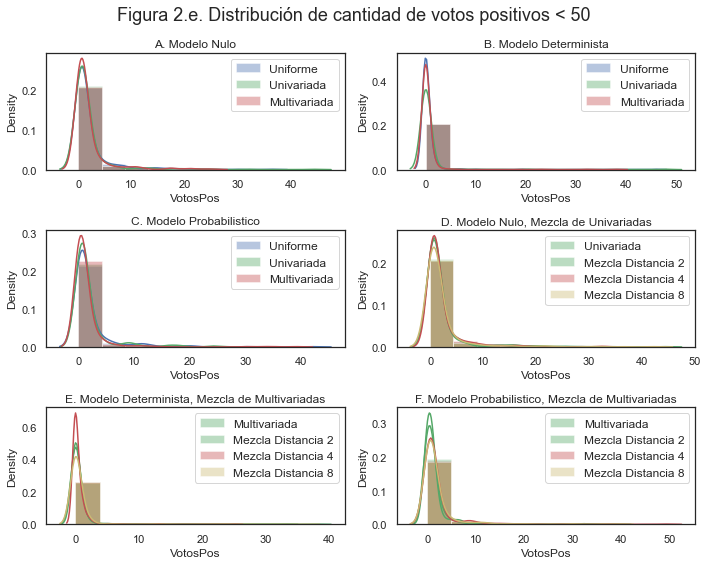

In [324]:
fig, axes = plt.subplots(3, 2, figsize=(10,8)) 
fig.suptitle('Figura 2.e. Distribución de cantidad de votos positivos < 50', fontsize=18)

# Nulo
UniformeNuloPosFiltrado = UniformeNulo[UniformeNulo.VotosPos < 50]
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.VotosPos < 50]
MultivariadaNuloPosFiltrado = MultivariadaNulo[MultivariadaNulo.VotosPos < 50]
val_min=min(min(UniformeNuloPosFiltrado.VotosPos),min(UnivariadaNuloPosFiltrado.VotosPos),min(MultivariadaNuloPosFiltrado.VotosPos))
val_max=max(max(UniformeNuloPosFiltrado.VotosPos),max(UnivariadaNuloPosFiltrado.VotosPos),max(MultivariadaNuloPosFiltrado.VotosPos))
sns.distplot(UniformeNuloPosFiltrado.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaNuloPosFiltrado.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaNuloPosFiltrado.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,0].legend(loc='best', fontsize=12)
axes[0,0].title.set_text("A. Modelo Nulo")

# Determinista
UniformeDeterministaPosFiltrado = UniformeDeterminista[UniformeDeterminista.VotosPos < 50]
UnivariadaDeterministaPosFiltrado = UnivariadaDeterminista[UnivariadaDeterminista.VotosPos < 50]
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.VotosPos < 50]
val_min = min(min(UniformeDeterministaPosFiltrado.VotosPos),min(UnivariadaDeterministaPosFiltrado.VotosPos),min(MultivariadaDeterministaPosFiltrado.VotosPos))
val_max = max(max(UniformeDeterministaPosFiltrado.VotosPos),max(UnivariadaDeterministaPosFiltrado.VotosPos),max(MultivariadaDeterministaPosFiltrado.VotosPos))
sns.distplot(UniformeDeterministaPosFiltrado.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaDeterministaPosFiltrado.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaDeterministaPosFiltrado.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,1].legend(loc='best', fontsize=12)
axes[0,1].title.set_text("B. Modelo Determinista")

# Probabilistica
UniformeProbabilisticaPosFiltrado = UniformeProbabilistica[UniformeProbabilistica.VotosPos < 50]
UnivariadaProbabilisticaPosFiltrado = UnivariadaProbabilistica[UnivariadaProbabilistica.VotosPos < 50]
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.VotosPos < 50]
val_min = min(min(UniformeProbabilisticaPosFiltrado.VotosPos),min(UnivariadaProbabilisticaPosFiltrado.VotosPos),min(MultivariadaProbabilisticaPosFiltrado.VotosPos))
val_max = max(max(UniformeProbabilisticaPosFiltrado.VotosPos),max(UnivariadaProbabilisticaPosFiltrado.VotosPos),max(MultivariadaProbabilisticaPosFiltrado.VotosPos))
sns.distplot(UniformeProbabilisticaPosFiltrado.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaProbabilisticaPosFiltrado.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaProbabilisticaPosFiltrado.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[1,0].legend(loc='best', fontsize=12)
axes[1,0].title.set_text("C. Modelo Probabilistico")

# Univariada Mezclas Nulo
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.VotosPos < 50]
UnivariadaNuloMezcla2PosFiltrado = UnivariadaNuloMezcla2[UnivariadaNuloMezcla2.VotosPos < 50]
UnivariadaNuloMezcla4PosFiltrado = UnivariadaNuloMezcla4[UnivariadaNuloMezcla4.VotosPos < 50]
UnivariadaNuloMezcla8PosFiltrado = UnivariadaNuloMezcla8[UnivariadaNuloMezcla8.VotosPos < 50]
val_min = min(min(UnivariadaNuloPosFiltrado.VotosPos),min(UnivariadaNuloMezcla2PosFiltrado.VotosPos),min(UnivariadaNuloMezcla4PosFiltrado.VotosPos), min(UnivariadaNuloMezcla8PosFiltrado.VotosPos))
val_max = max(max(UnivariadaNuloPosFiltrado.VotosPos),max(UnivariadaNuloMezcla2PosFiltrado.VotosPos),max(UnivariadaNuloMezcla4PosFiltrado.VotosPos), max(UnivariadaNuloMezcla8PosFiltrado.VotosPos))
sns.distplot(UnivariadaNuloPosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(UnivariadaNuloMezcla2PosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(UnivariadaNuloMezcla4PosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(UnivariadaNuloMezcla8PosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[1,1].legend(loc='best', fontsize=12)
axes[1,1].title.set_text("D. Modelo Nulo, Mezcla de Univariadas")

# Multivariada Mezclas Determinista
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.VotosPos < 50]
MultivariadaDeterministaMezcla2PosFiltrado = MultivariadaDeterministaMezcla2[MultivariadaDeterministaMezcla2.VotosPos < 50]
MultivariadaDeterministaMezcla4PosFiltrado = MultivariadaDeterministaMezcla4[MultivariadaDeterministaMezcla4.VotosPos < 50]
MultivariadaDeterministaMezcla8PosFiltrado = MultivariadaDeterministaMezcla8[MultivariadaDeterministaMezcla8.VotosPos < 50]
val_min = min(min(MultivariadaDeterministaPosFiltrado.VotosPos),min(MultivariadaDeterministaMezcla2PosFiltrado.VotosPos),min(MultivariadaDeterministaMezcla4PosFiltrado.VotosPos), min(MultivariadaDeterministaMezcla8PosFiltrado.VotosPos))
val_max = max(max(MultivariadaDeterministaPosFiltrado.VotosPos),max(MultivariadaDeterministaMezcla2PosFiltrado.VotosPos),max(MultivariadaDeterministaMezcla4PosFiltrado.VotosPos), max(MultivariadaDeterministaMezcla8PosFiltrado.VotosPos))
sns.distplot(MultivariadaDeterministaPosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaDeterministaMezcla2PosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaDeterministaMezcla4PosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaDeterministaMezcla8PosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,0].legend(loc='best', fontsize=12)
axes[2,0].title.set_text("E. Modelo Determinista, Mezcla de Multivariadas")

# Multivariada Mezclas Probabilistica
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.VotosPos < 50]
MultivariadaProbabilisticaMezcla2PosFiltrado = MultivariadaProbabilisticaMezcla2[MultivariadaProbabilisticaMezcla2.VotosPos < 50]
MultivariadaProbabilisticaMezcla4PosFiltrado = MultivariadaProbabilisticaMezcla4[MultivariadaProbabilisticaMezcla4.VotosPos < 50]
MultivariadaProbabilisticaMezcla8PosFiltrado = MultivariadaProbabilisticaMezcla8[MultivariadaProbabilisticaMezcla8.VotosPos < 50]
val_min = min(min(MultivariadaProbabilisticaPosFiltrado.VotosPos),min(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosPos),min(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosPos), min(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosPos))
val_max = max(max(MultivariadaProbabilisticaPosFiltrado.VotosPos),max(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosPos),max(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosPos), max(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosPos))
sns.distplot(MultivariadaProbabilisticaPosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,1].legend(loc='best', fontsize=12)
axes[2,1].title.set_text("F. Modelo Probabilistico, Mezcla de Multivariadas")


plt.tight_layout()


plt.savefig('F2e.png', dpi = 800)

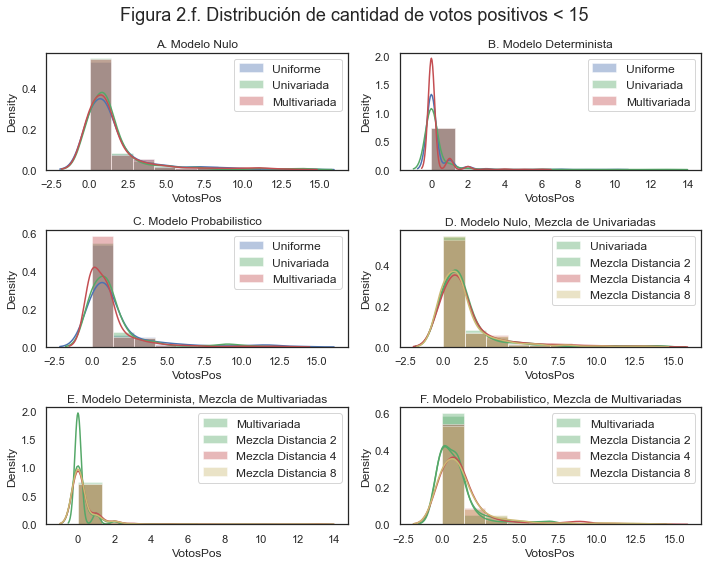

In [326]:
fig, axes = plt.subplots(3, 2, figsize=(10,8)) 
fig.suptitle('Figura 2.f. Distribución de cantidad de votos positivos < 15', fontsize=18)

# Nulo
UniformeNuloPosFiltrado = UniformeNulo[UniformeNulo.VotosPos < 15]
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.VotosPos < 15]
MultivariadaNuloPosFiltrado = MultivariadaNulo[MultivariadaNulo.VotosPos < 15]
val_min=min(min(UniformeNuloPosFiltrado.VotosPos),min(UnivariadaNuloPosFiltrado.VotosPos),min(MultivariadaNuloPosFiltrado.VotosPos))
val_max=max(max(UniformeNuloPosFiltrado.VotosPos),max(UnivariadaNuloPosFiltrado.VotosPos),max(MultivariadaNuloPosFiltrado.VotosPos))
sns.distplot(UniformeNuloPosFiltrado.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaNuloPosFiltrado.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaNuloPosFiltrado.VotosPos,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,0].legend(loc='best', fontsize=12)
axes[0,0].title.set_text("A. Modelo Nulo")

# Determinista
UniformeDeterministaPosFiltrado = UniformeDeterminista[UniformeDeterminista.VotosPos < 15]
UnivariadaDeterministaPosFiltrado = UnivariadaDeterminista[UnivariadaDeterminista.VotosPos < 15]
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.VotosPos < 15]
val_min = min(min(UniformeDeterministaPosFiltrado.VotosPos),min(UnivariadaDeterministaPosFiltrado.VotosPos),min(MultivariadaDeterministaPosFiltrado.VotosPos))
val_max = max(max(UniformeDeterministaPosFiltrado.VotosPos),max(UnivariadaDeterministaPosFiltrado.VotosPos),max(MultivariadaDeterministaPosFiltrado.VotosPos))
sns.distplot(UniformeDeterministaPosFiltrado.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaDeterministaPosFiltrado.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaDeterministaPosFiltrado.VotosPos,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,1].legend(loc='best', fontsize=12)
axes[0,1].title.set_text("B. Modelo Determinista")

# Probabilistica
UniformeProbabilisticaPosFiltrado = UniformeProbabilistica[UniformeProbabilistica.VotosPos < 15]
UnivariadaProbabilisticaPosFiltrado = UnivariadaProbabilistica[UnivariadaProbabilistica.VotosPos < 15]
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.VotosPos < 15]
val_min = min(min(UniformeProbabilisticaPosFiltrado.VotosPos),min(UnivariadaProbabilisticaPosFiltrado.VotosPos),min(MultivariadaProbabilisticaPosFiltrado.VotosPos))
val_max = max(max(UniformeProbabilisticaPosFiltrado.VotosPos),max(UnivariadaProbabilisticaPosFiltrado.VotosPos),max(MultivariadaProbabilisticaPosFiltrado.VotosPos))
sns.distplot(UniformeProbabilisticaPosFiltrado.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaProbabilisticaPosFiltrado.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaProbabilisticaPosFiltrado.VotosPos,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[1,0].legend(loc='best', fontsize=12)
axes[1,0].title.set_text("C. Modelo Probabilistico")

# Univariada Mezclas Nulo
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.VotosPos < 15]
UnivariadaNuloMezcla2PosFiltrado = UnivariadaNuloMezcla2[UnivariadaNuloMezcla2.VotosPos < 15]
UnivariadaNuloMezcla4PosFiltrado = UnivariadaNuloMezcla4[UnivariadaNuloMezcla4.VotosPos < 15]
UnivariadaNuloMezcla8PosFiltrado = UnivariadaNuloMezcla8[UnivariadaNuloMezcla8.VotosPos < 15]
val_min = min(min(UnivariadaNuloPosFiltrado.VotosPos),min(UnivariadaNuloMezcla2PosFiltrado.VotosPos),min(UnivariadaNuloMezcla4PosFiltrado.VotosPos), min(UnivariadaNuloMezcla8PosFiltrado.VotosPos))
val_max = max(max(UnivariadaNuloPosFiltrado.VotosPos),max(UnivariadaNuloMezcla2PosFiltrado.VotosPos),max(UnivariadaNuloMezcla4PosFiltrado.VotosPos), max(UnivariadaNuloMezcla8PosFiltrado.VotosPos))
sns.distplot(UnivariadaNuloPosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(UnivariadaNuloMezcla2PosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(UnivariadaNuloMezcla4PosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(UnivariadaNuloMezcla8PosFiltrado.VotosPos,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[1,1].legend(loc='best', fontsize=12)
axes[1,1].title.set_text("D. Modelo Nulo, Mezcla de Univariadas")

# Multivariada Mezclas Determinista
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.VotosPos < 15]
MultivariadaDeterministaMezcla2PosFiltrado = MultivariadaDeterministaMezcla2[MultivariadaDeterministaMezcla2.VotosPos < 15]
MultivariadaDeterministaMezcla4PosFiltrado = MultivariadaDeterministaMezcla4[MultivariadaDeterministaMezcla4.VotosPos < 15]
MultivariadaDeterministaMezcla8PosFiltrado = MultivariadaDeterministaMezcla8[MultivariadaDeterministaMezcla8.VotosPos < 15]
val_min = min(min(MultivariadaDeterministaPosFiltrado.VotosPos),min(MultivariadaDeterministaMezcla2PosFiltrado.VotosPos),min(MultivariadaDeterministaMezcla4PosFiltrado.VotosPos), min(MultivariadaDeterministaMezcla8PosFiltrado.VotosPos))
val_max = max(max(MultivariadaDeterministaPosFiltrado.VotosPos),max(MultivariadaDeterministaMezcla2PosFiltrado.VotosPos),max(MultivariadaDeterministaMezcla4PosFiltrado.VotosPos), max(MultivariadaDeterministaMezcla8PosFiltrado.VotosPos))
sns.distplot(MultivariadaDeterministaPosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaDeterministaMezcla2PosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaDeterministaMezcla4PosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaDeterministaMezcla8PosFiltrado.VotosPos,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,0].legend(loc='best', fontsize=12)
axes[2,0].title.set_text("E. Modelo Determinista, Mezcla de Multivariadas")

# Multivariada Mezclas Probabilistica
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.VotosPos < 15]
MultivariadaProbabilisticaMezcla2PosFiltrado = MultivariadaProbabilisticaMezcla2[MultivariadaProbabilisticaMezcla2.VotosPos < 15]
MultivariadaProbabilisticaMezcla4PosFiltrado = MultivariadaProbabilisticaMezcla4[MultivariadaProbabilisticaMezcla4.VotosPos < 15]
MultivariadaProbabilisticaMezcla8PosFiltrado = MultivariadaProbabilisticaMezcla8[MultivariadaProbabilisticaMezcla8.VotosPos < 15]
val_min = min(min(MultivariadaProbabilisticaPosFiltrado.VotosPos),min(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosPos),min(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosPos), min(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosPos))
val_max = max(max(MultivariadaProbabilisticaPosFiltrado.VotosPos),max(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosPos),max(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosPos), max(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosPos))
sns.distplot(MultivariadaProbabilisticaPosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosPos,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,1].legend(loc='best', fontsize=12)
axes[2,1].title.set_text("F. Modelo Probabilistico, Mezcla de Multivariadas")


plt.tight_layout()


plt.savefig('F2f.png', dpi = 800)

# Figura 3.a. Distribución de cantidad de votos negativos

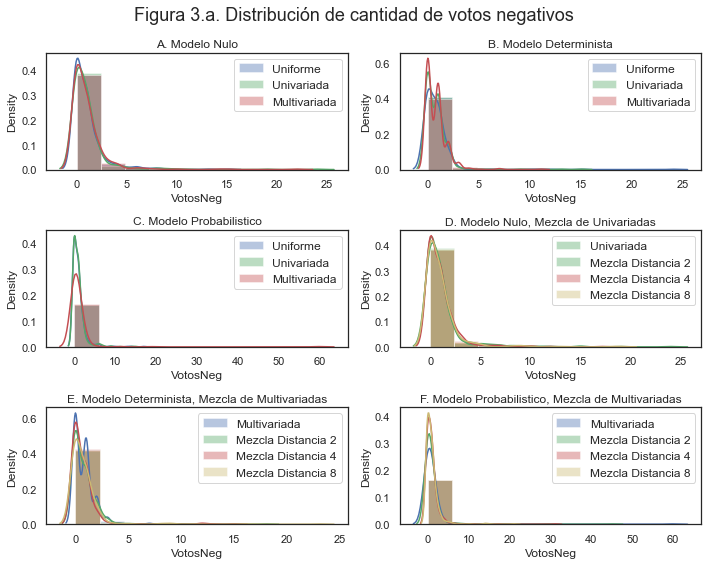

In [320]:
# fig, ax = plt.subplots(9, 1, figsize=(8,55)) 


fig, axes = plt.subplots(3, 2, figsize=(10,8)) 
fig.suptitle('Figura 3.a. Distribución de cantidad de votos negativos', fontsize=18)

# Nulo
val_min = min(min(UniformeNulo.VotosNeg),min(UnivariadaNulo.VotosNeg),min(MultivariadaNulo.VotosNeg))
val_max = max(max(UniformeNulo.VotosNeg),max(UnivariadaNulo.VotosNeg),max(MultivariadaNulo.VotosNeg))
sns.distplot(UniformeNulo.VotosNeg,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaNulo.VotosNeg,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaNulo.VotosNeg,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,0].legend(loc='best', fontsize=12)
axes[0,0].title.set_text("A. Modelo Nulo")

# Determinista
val_min = min(min(UniformeDeterminista.VotosNeg),min(UnivariadaDeterminista.VotosNeg),min(MultivariadaDeterminista.VotosNeg))
val_max = max(max(UniformeDeterminista.VotosNeg),max(UnivariadaDeterminista.VotosNeg),max(MultivariadaDeterminista.VotosNeg))
sns.distplot(UniformeDeterminista.VotosNeg,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaDeterminista.VotosNeg,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaDeterminista.VotosNeg,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,1].legend(loc='best', fontsize=12)
axes[0,1].title.set_text("B. Modelo Determinista")

# Probabilistica
val_min = min(min(UniformeProbabilistica.VotosNeg),min(UnivariadaProbabilistica.VotosNeg),min(MultivariadaProbabilistica.VotosNeg))
val_max = max(max(UniformeProbabilistica.VotosNeg),max(UnivariadaProbabilistica.VotosNeg),max(MultivariadaProbabilistica.VotosNeg))
sns.distplot(UniformeProbabilistica.VotosNeg,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaProbabilistica.VotosNeg,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaProbabilistica.VotosNeg,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[1,0].legend(loc='best', fontsize=12)
axes[1,0].title.set_text("C. Modelo Probabilistico")

# Univariada Mezclas Nulo
val_min = min(min(UnivariadaNulo.VotosNeg),min(UnivariadaNuloMezcla2.VotosNeg),min(UnivariadaNuloMezcla4.VotosNeg), min(UnivariadaNuloMezcla8.VotosNeg))
val_max = max(max(UnivariadaNulo.VotosNeg),max(UnivariadaNuloMezcla2.VotosNeg),max(UnivariadaNuloMezcla4.VotosNeg), max(UnivariadaNuloMezcla8.VotosNeg))
sns.distplot(UnivariadaNulo.VotosNeg,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(UnivariadaNuloMezcla2.VotosNeg,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(UnivariadaNuloMezcla4.VotosNeg,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(UnivariadaNuloMezcla8.VotosNeg,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[1,1].legend(loc='best', fontsize=12)
axes[1,1].title.set_text("D. Modelo Nulo, Mezcla de Univariadas")

# Multivariada Mezclas Determinista
val_min = min(min(MultivariadaDeterminista.VotosNeg),min(MultivariadaDeterministaMezcla2.VotosNeg),min(MultivariadaDeterministaMezcla4.VotosNeg), min(MultivariadaDeterministaMezcla8.VotosNeg))
val_max = max(max(MultivariadaDeterminista.VotosNeg),max(MultivariadaDeterministaMezcla2.VotosNeg),max(MultivariadaDeterministaMezcla4.VotosNeg), max(MultivariadaDeterministaMezcla8.VotosNeg))
sns.distplot(MultivariadaDeterminista.VotosNeg,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Multivariada')
sns.distplot(MultivariadaDeterministaMezcla2.VotosNeg,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaDeterministaMezcla4.VotosNeg,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaDeterministaMezcla8.VotosNeg,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,0].legend(loc='best', fontsize=12)
axes[2,0].title.set_text("E. Modelo Determinista, Mezcla de Multivariadas")

# Multivariada Mezclas Probabilistica
val_min = min(min(MultivariadaProbabilistica.VotosNeg),min(MultivariadaProbabilisticaMezcla2.VotosNeg),min(MultivariadaProbabilisticaMezcla4.VotosNeg), min(MultivariadaProbabilisticaMezcla8.VotosNeg))
val_max = max(max(MultivariadaProbabilistica.VotosNeg),max(MultivariadaProbabilisticaMezcla2.VotosNeg),max(MultivariadaProbabilisticaMezcla4.VotosNeg), max(MultivariadaProbabilisticaMezcla8.VotosNeg))
sns.distplot(MultivariadaProbabilistica.VotosNeg,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Multivariada')
sns.distplot(MultivariadaProbabilisticaMezcla2.VotosNeg,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaProbabilisticaMezcla4.VotosNeg,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaProbabilisticaMezcla8.VotosNeg,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,1].legend(loc='best', fontsize=12)
axes[2,1].title.set_text("F. Modelo Probabilistico, Mezcla de Multivariadas")


plt.tight_layout()


plt.savefig('F3a.png', dpi = 800)

# Figura 3.b. Distribución de cantidad de votos negativos > 0

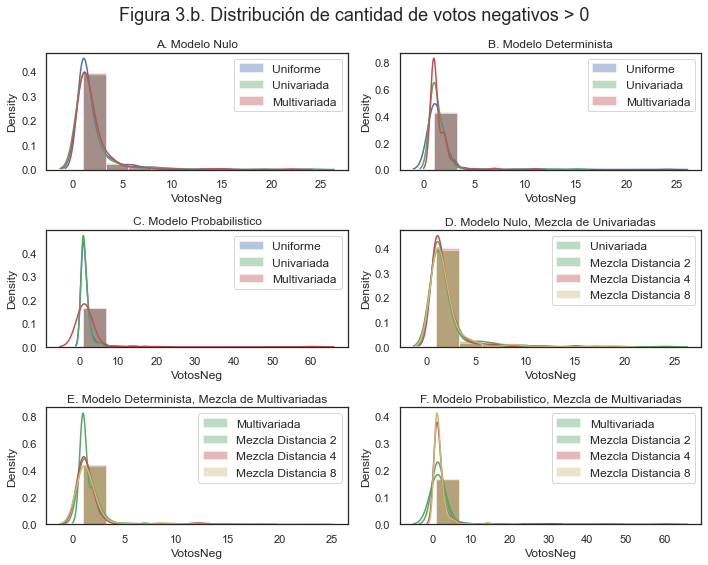

In [319]:
fig, axes = plt.subplots(3, 2, figsize=(10,8)) 
fig.suptitle('Figura 3.b. Distribución de cantidad de votos negativos > 0', fontsize=18)

# Nulo
UniformeNuloPosFiltrado = UniformeNulo[UniformeNulo.VotosNeg > 0]
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.VotosNeg > 0]
MultivariadaNuloPosFiltrado = MultivariadaNulo[MultivariadaNulo.VotosNeg > 0]
val_min=min(min(UniformeNuloPosFiltrado.VotosNeg),min(UnivariadaNuloPosFiltrado.VotosNeg),min(MultivariadaNuloPosFiltrado.VotosNeg))
val_max=max(max(UniformeNuloPosFiltrado.VotosNeg),max(UnivariadaNuloPosFiltrado.VotosNeg),max(MultivariadaNuloPosFiltrado.VotosNeg))
sns.distplot(UniformeNuloPosFiltrado.VotosNeg,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaNuloPosFiltrado.VotosNeg,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaNuloPosFiltrado.VotosNeg,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,0].legend(loc='best', fontsize=12)
axes[0,0].title.set_text("A. Modelo Nulo")

# Determinista
UniformeDeterministaPosFiltrado = UniformeDeterminista[UniformeDeterminista.VotosNeg > 0]
UnivariadaDeterministaPosFiltrado = UnivariadaDeterminista[UnivariadaDeterminista.VotosNeg > 0]
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.VotosNeg > 0]
val_min = min(min(UniformeDeterministaPosFiltrado.VotosNeg),min(UnivariadaDeterministaPosFiltrado.VotosNeg),min(MultivariadaDeterministaPosFiltrado.VotosNeg))
val_max = max(max(UniformeDeterministaPosFiltrado.VotosNeg),max(UnivariadaDeterministaPosFiltrado.VotosNeg),max(MultivariadaDeterministaPosFiltrado.VotosNeg))
sns.distplot(UniformeDeterministaPosFiltrado.VotosNeg,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaDeterministaPosFiltrado.VotosNeg,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaDeterministaPosFiltrado.VotosNeg,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,1].legend(loc='best', fontsize=12)
axes[0,1].title.set_text("B. Modelo Determinista")

# Probabilistica
UniformeProbabilisticaPosFiltrado = UniformeProbabilistica[UniformeProbabilistica.VotosNeg > 0]
UnivariadaProbabilisticaPosFiltrado = UnivariadaProbabilistica[UnivariadaProbabilistica.VotosNeg > 0]
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.VotosNeg > 0]
val_min = min(min(UniformeProbabilisticaPosFiltrado.VotosNeg),min(UnivariadaProbabilisticaPosFiltrado.VotosNeg),min(MultivariadaProbabilisticaPosFiltrado.VotosNeg))
val_max = max(max(UniformeProbabilisticaPosFiltrado.VotosNeg),max(UnivariadaProbabilisticaPosFiltrado.VotosNeg),max(MultivariadaProbabilisticaPosFiltrado.VotosNeg))
sns.distplot(UniformeProbabilisticaPosFiltrado.VotosNeg,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaProbabilisticaPosFiltrado.VotosNeg,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaProbabilisticaPosFiltrado.VotosNeg,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[1,0].legend(loc='best', fontsize=12)
axes[1,0].title.set_text("C. Modelo Probabilistico")

# Univariada Mezclas Nulo
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.VotosNeg > 0]
UnivariadaNuloMezcla2PosFiltrado = UnivariadaNuloMezcla2[UnivariadaNuloMezcla2.VotosNeg > 0]
UnivariadaNuloMezcla4PosFiltrado = UnivariadaNuloMezcla4[UnivariadaNuloMezcla4.VotosNeg > 0]
UnivariadaNuloMezcla8PosFiltrado = UnivariadaNuloMezcla8[UnivariadaNuloMezcla8.VotosNeg > 0]
val_min = min(min(UnivariadaNuloPosFiltrado.VotosNeg),min(UnivariadaNuloMezcla2PosFiltrado.VotosNeg),min(UnivariadaNuloMezcla4PosFiltrado.VotosNeg), min(UnivariadaNuloMezcla8PosFiltrado.VotosNeg))
val_max = max(max(UnivariadaNuloPosFiltrado.VotosNeg),max(UnivariadaNuloMezcla2PosFiltrado.VotosNeg),max(UnivariadaNuloMezcla4PosFiltrado.VotosNeg), max(UnivariadaNuloMezcla8PosFiltrado.VotosNeg))
sns.distplot(UnivariadaNuloPosFiltrado.VotosNeg,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(UnivariadaNuloMezcla2PosFiltrado.VotosNeg,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(UnivariadaNuloMezcla4PosFiltrado.VotosNeg,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(UnivariadaNuloMezcla8PosFiltrado.VotosNeg,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[1,1].legend(loc='best', fontsize=12)
axes[1,1].title.set_text("D. Modelo Nulo, Mezcla de Univariadas")

# Multivariada Mezclas Determinista
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.VotosNeg > 0]
MultivariadaDeterministaMezcla2PosFiltrado = MultivariadaDeterministaMezcla2[MultivariadaDeterministaMezcla2.VotosNeg > 0]
MultivariadaDeterministaMezcla4PosFiltrado = MultivariadaDeterministaMezcla4[MultivariadaDeterministaMezcla4.VotosNeg > 0]
MultivariadaDeterministaMezcla8PosFiltrado = MultivariadaDeterministaMezcla8[MultivariadaDeterministaMezcla8.VotosNeg > 0]
val_min = min(min(MultivariadaDeterministaPosFiltrado.VotosNeg),min(MultivariadaDeterministaMezcla2PosFiltrado.VotosNeg),min(MultivariadaDeterministaMezcla4PosFiltrado.VotosNeg), min(MultivariadaDeterministaMezcla8PosFiltrado.VotosNeg))
val_max = max(max(MultivariadaDeterministaPosFiltrado.VotosNeg),max(MultivariadaDeterministaMezcla2PosFiltrado.VotosNeg),max(MultivariadaDeterministaMezcla4PosFiltrado.VotosNeg), max(MultivariadaDeterministaMezcla8PosFiltrado.VotosNeg))
sns.distplot(MultivariadaDeterministaPosFiltrado.VotosNeg,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaDeterministaMezcla2PosFiltrado.VotosNeg,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaDeterministaMezcla4PosFiltrado.VotosNeg,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaDeterministaMezcla8PosFiltrado.VotosNeg,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,0].legend(loc='best', fontsize=12)
axes[2,0].title.set_text("E. Modelo Determinista, Mezcla de Multivariadas")

# Multivariada Mezclas Probabilistica
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.VotosNeg > 0]
MultivariadaProbabilisticaMezcla2PosFiltrado = MultivariadaProbabilisticaMezcla2[MultivariadaProbabilisticaMezcla2.VotosNeg > 0]
MultivariadaProbabilisticaMezcla4PosFiltrado = MultivariadaProbabilisticaMezcla4[MultivariadaProbabilisticaMezcla4.VotosNeg > 0]
MultivariadaProbabilisticaMezcla8PosFiltrado = MultivariadaProbabilisticaMezcla8[MultivariadaProbabilisticaMezcla8.VotosNeg > 0]
val_min = min(min(MultivariadaProbabilisticaPosFiltrado.VotosNeg),min(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosNeg),min(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosNeg), min(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosNeg))
val_max = max(max(MultivariadaProbabilisticaPosFiltrado.VotosNeg),max(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosNeg),max(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosNeg), max(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosNeg))
sns.distplot(MultivariadaProbabilisticaPosFiltrado.VotosNeg,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosNeg,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosNeg,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosNeg,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,1].legend(loc='best', fontsize=12)
axes[2,1].title.set_text("F. Modelo Probabilistico, Mezcla de Multivariadas")


plt.tight_layout()


plt.savefig('F3b.png', dpi = 800)

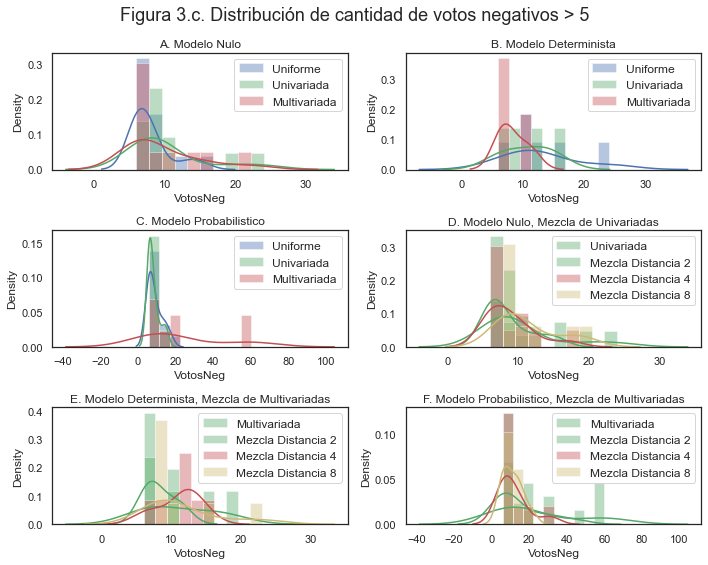

In [317]:
fig, axes = plt.subplots(3, 2, figsize=(10,8)) 
fig.suptitle('Figura 3.c. Distribución de cantidad de votos negativos > 5', fontsize=18)

# Nulo
UniformeNuloPosFiltrado = UniformeNulo[UniformeNulo.VotosNeg > 5]
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.VotosNeg > 5]
MultivariadaNuloPosFiltrado = MultivariadaNulo[MultivariadaNulo.VotosNeg > 5]
val_min=min(min(UniformeNuloPosFiltrado.VotosNeg),min(UnivariadaNuloPosFiltrado.VotosNeg),min(MultivariadaNuloPosFiltrado.VotosNeg))
val_max=max(max(UniformeNuloPosFiltrado.VotosNeg),max(UnivariadaNuloPosFiltrado.VotosNeg),max(MultivariadaNuloPosFiltrado.VotosNeg))
sns.distplot(UniformeNuloPosFiltrado.VotosNeg,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaNuloPosFiltrado.VotosNeg,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaNuloPosFiltrado.VotosNeg,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,0].legend(loc='best', fontsize=12)
axes[0,0].title.set_text("A. Modelo Nulo")

# Determinista
UniformeDeterministaPosFiltrado = UniformeDeterminista[UniformeDeterminista.VotosNeg > 5]
UnivariadaDeterministaPosFiltrado = UnivariadaDeterminista[UnivariadaDeterminista.VotosNeg > 5]
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.VotosNeg > 5]
val_min = min(min(UniformeDeterministaPosFiltrado.VotosNeg),min(UnivariadaDeterministaPosFiltrado.VotosNeg),min(MultivariadaDeterministaPosFiltrado.VotosNeg))
val_max = max(max(UniformeDeterministaPosFiltrado.VotosNeg),max(UnivariadaDeterministaPosFiltrado.VotosNeg),max(MultivariadaDeterministaPosFiltrado.VotosNeg))
sns.distplot(UniformeDeterministaPosFiltrado.VotosNeg,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaDeterministaPosFiltrado.VotosNeg,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaDeterministaPosFiltrado.VotosNeg,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,1].legend(loc='best', fontsize=12)
axes[0,1].title.set_text("B. Modelo Determinista")

# Probabilistica
UniformeProbabilisticaPosFiltrado = UniformeProbabilistica[UniformeProbabilistica.VotosNeg > 5]
UnivariadaProbabilisticaPosFiltrado = UnivariadaProbabilistica[UnivariadaProbabilistica.VotosNeg > 5]
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.VotosNeg > 5]
val_min = min(min(UniformeProbabilisticaPosFiltrado.VotosNeg),min(UnivariadaProbabilisticaPosFiltrado.VotosNeg),min(MultivariadaProbabilisticaPosFiltrado.VotosNeg))
val_max = max(max(UniformeProbabilisticaPosFiltrado.VotosNeg),max(UnivariadaProbabilisticaPosFiltrado.VotosNeg),max(MultivariadaProbabilisticaPosFiltrado.VotosNeg))
sns.distplot(UniformeProbabilisticaPosFiltrado.VotosNeg,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaProbabilisticaPosFiltrado.VotosNeg,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaProbabilisticaPosFiltrado.VotosNeg,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[1,0].legend(loc='best', fontsize=12)
axes[1,0].title.set_text("C. Modelo Probabilistico")

# Univariada Mezclas Nulo
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.VotosNeg > 5]
UnivariadaNuloMezcla2PosFiltrado = UnivariadaNuloMezcla2[UnivariadaNuloMezcla2.VotosNeg > 5]
UnivariadaNuloMezcla4PosFiltrado = UnivariadaNuloMezcla4[UnivariadaNuloMezcla4.VotosNeg > 5]
UnivariadaNuloMezcla8PosFiltrado = UnivariadaNuloMezcla8[UnivariadaNuloMezcla8.VotosNeg > 5]
val_min = min(min(UnivariadaNuloPosFiltrado.VotosNeg),min(UnivariadaNuloMezcla2PosFiltrado.VotosNeg),min(UnivariadaNuloMezcla4PosFiltrado.VotosNeg), min(UnivariadaNuloMezcla8PosFiltrado.VotosNeg))
val_max = max(max(UnivariadaNuloPosFiltrado.VotosNeg),max(UnivariadaNuloMezcla2PosFiltrado.VotosNeg),max(UnivariadaNuloMezcla4PosFiltrado.VotosNeg), max(UnivariadaNuloMezcla8PosFiltrado.VotosNeg))
sns.distplot(UnivariadaNuloPosFiltrado.VotosNeg,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(UnivariadaNuloMezcla2PosFiltrado.VotosNeg,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(UnivariadaNuloMezcla4PosFiltrado.VotosNeg,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(UnivariadaNuloMezcla8PosFiltrado.VotosNeg,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[1,1].legend(loc='best', fontsize=12)
axes[1,1].title.set_text("D. Modelo Nulo, Mezcla de Univariadas")

# Multivariada Mezclas Determinista
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.VotosNeg > 5]
MultivariadaDeterministaMezcla2PosFiltrado = MultivariadaDeterministaMezcla2[MultivariadaDeterministaMezcla2.VotosNeg > 5]
MultivariadaDeterministaMezcla4PosFiltrado = MultivariadaDeterministaMezcla4[MultivariadaDeterministaMezcla4.VotosNeg > 5]
MultivariadaDeterministaMezcla8PosFiltrado = MultivariadaDeterministaMezcla8[MultivariadaDeterministaMezcla8.VotosNeg > 5]
val_min = min(min(MultivariadaDeterministaPosFiltrado.VotosNeg),min(MultivariadaDeterministaMezcla2PosFiltrado.VotosNeg),min(MultivariadaDeterministaMezcla4PosFiltrado.VotosNeg), min(MultivariadaDeterministaMezcla8PosFiltrado.VotosNeg))
val_max = max(max(MultivariadaDeterministaPosFiltrado.VotosNeg),max(MultivariadaDeterministaMezcla2PosFiltrado.VotosNeg),max(MultivariadaDeterministaMezcla4PosFiltrado.VotosNeg), max(MultivariadaDeterministaMezcla8PosFiltrado.VotosNeg))
sns.distplot(MultivariadaDeterministaPosFiltrado.VotosNeg,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaDeterministaMezcla2PosFiltrado.VotosNeg,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaDeterministaMezcla4PosFiltrado.VotosNeg,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaDeterministaMezcla8PosFiltrado.VotosNeg,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,0].legend(loc='best', fontsize=12)
axes[2,0].title.set_text("E. Modelo Determinista, Mezcla de Multivariadas")

# Multivariada Mezclas Probabilistica
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.VotosNeg > 5]
MultivariadaProbabilisticaMezcla2PosFiltrado = MultivariadaProbabilisticaMezcla2[MultivariadaProbabilisticaMezcla2.VotosNeg > 5]
MultivariadaProbabilisticaMezcla4PosFiltrado = MultivariadaProbabilisticaMezcla4[MultivariadaProbabilisticaMezcla4.VotosNeg > 5]
MultivariadaProbabilisticaMezcla8PosFiltrado = MultivariadaProbabilisticaMezcla8[MultivariadaProbabilisticaMezcla8.VotosNeg > 5]
val_min = min(min(MultivariadaProbabilisticaPosFiltrado.VotosNeg),min(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosNeg),min(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosNeg), min(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosNeg))
val_max = max(max(MultivariadaProbabilisticaPosFiltrado.VotosNeg),max(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosNeg),max(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosNeg), max(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosNeg))
sns.distplot(MultivariadaProbabilisticaPosFiltrado.VotosNeg,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosNeg,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosNeg,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosNeg,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,1].legend(loc='best', fontsize=12)
axes[2,1].title.set_text("F. Modelo Probabilistico, Mezcla de Multivariadas")


plt.tight_layout()


plt.savefig('F3b5.png', dpi = 800)

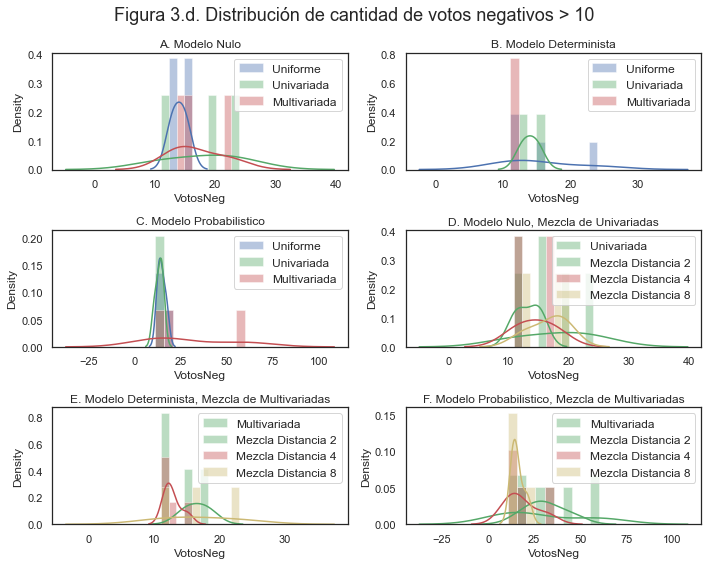

In [318]:
fig, axes = plt.subplots(3, 2, figsize=(10,8)) 
fig.suptitle('Figura 3.d. Distribución de cantidad de votos negativos > 10', fontsize=18)

# Nulo
UniformeNuloPosFiltrado = UniformeNulo[UniformeNulo.VotosNeg > 10]
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.VotosNeg > 10]
MultivariadaNuloPosFiltrado = MultivariadaNulo[MultivariadaNulo.VotosNeg > 10]
val_min=min(min(UniformeNuloPosFiltrado.VotosNeg),min(UnivariadaNuloPosFiltrado.VotosNeg),min(MultivariadaNuloPosFiltrado.VotosNeg))
val_max=max(max(UniformeNuloPosFiltrado.VotosNeg),max(UnivariadaNuloPosFiltrado.VotosNeg),max(MultivariadaNuloPosFiltrado.VotosNeg))
sns.distplot(UniformeNuloPosFiltrado.VotosNeg,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaNuloPosFiltrado.VotosNeg,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaNuloPosFiltrado.VotosNeg,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,0].legend(loc='best', fontsize=12)
axes[0,0].title.set_text("A. Modelo Nulo")

# Determinista
UniformeDeterministaPosFiltrado = UniformeDeterminista[UniformeDeterminista.VotosNeg > 10]
UnivariadaDeterministaPosFiltrado = UnivariadaDeterminista[UnivariadaDeterminista.VotosNeg > 10]
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.VotosNeg > 10]
val_min = min(min(UniformeDeterministaPosFiltrado.VotosNeg),min(UnivariadaDeterministaPosFiltrado.VotosNeg),min(MultivariadaDeterministaPosFiltrado.VotosNeg))
val_max = max(max(UniformeDeterministaPosFiltrado.VotosNeg),max(UnivariadaDeterministaPosFiltrado.VotosNeg),max(MultivariadaDeterministaPosFiltrado.VotosNeg))
sns.distplot(UniformeDeterministaPosFiltrado.VotosNeg,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaDeterministaPosFiltrado.VotosNeg,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaDeterministaPosFiltrado.VotosNeg,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,1].legend(loc='best', fontsize=12)
axes[0,1].title.set_text("B. Modelo Determinista")

# Probabilistica
UniformeProbabilisticaPosFiltrado = UniformeProbabilistica[UniformeProbabilistica.VotosNeg > 10]
UnivariadaProbabilisticaPosFiltrado = UnivariadaProbabilistica[UnivariadaProbabilistica.VotosNeg > 10]
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.VotosNeg > 10]
val_min = min(min(UniformeProbabilisticaPosFiltrado.VotosNeg),min(UnivariadaProbabilisticaPosFiltrado.VotosNeg),min(MultivariadaProbabilisticaPosFiltrado.VotosNeg))
val_max = max(max(UniformeProbabilisticaPosFiltrado.VotosNeg),max(UnivariadaProbabilisticaPosFiltrado.VotosNeg),max(MultivariadaProbabilisticaPosFiltrado.VotosNeg))
sns.distplot(UniformeProbabilisticaPosFiltrado.VotosNeg,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaProbabilisticaPosFiltrado.VotosNeg,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(MultivariadaProbabilisticaPosFiltrado.VotosNeg,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[1,0].legend(loc='best', fontsize=12)
axes[1,0].title.set_text("C. Modelo Probabilistico")

# Univariada Mezclas Nulo
UnivariadaNuloPosFiltrado = UnivariadaNulo[UnivariadaNulo.VotosNeg > 10]
UnivariadaNuloMezcla2PosFiltrado = UnivariadaNuloMezcla2[UnivariadaNuloMezcla2.VotosNeg > 10]
UnivariadaNuloMezcla4PosFiltrado = UnivariadaNuloMezcla4[UnivariadaNuloMezcla4.VotosNeg > 10]
UnivariadaNuloMezcla8PosFiltrado = UnivariadaNuloMezcla8[UnivariadaNuloMezcla8.VotosNeg > 10]
val_min = min(min(UnivariadaNuloPosFiltrado.VotosNeg),min(UnivariadaNuloMezcla2PosFiltrado.VotosNeg),min(UnivariadaNuloMezcla4PosFiltrado.VotosNeg), min(UnivariadaNuloMezcla8PosFiltrado.VotosNeg))
val_max = max(max(UnivariadaNuloPosFiltrado.VotosNeg),max(UnivariadaNuloMezcla2PosFiltrado.VotosNeg),max(UnivariadaNuloMezcla4PosFiltrado.VotosNeg), max(UnivariadaNuloMezcla8PosFiltrado.VotosNeg))
sns.distplot(UnivariadaNuloPosFiltrado.VotosNeg,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(UnivariadaNuloMezcla2PosFiltrado.VotosNeg,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(UnivariadaNuloMezcla4PosFiltrado.VotosNeg,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(UnivariadaNuloMezcla8PosFiltrado.VotosNeg,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[1,1].legend(loc='best', fontsize=12)
axes[1,1].title.set_text("D. Modelo Nulo, Mezcla de Univariadas")

# Multivariada Mezclas Determinista
MultivariadaDeterministaPosFiltrado = MultivariadaDeterminista[MultivariadaDeterminista.VotosNeg > 10]
MultivariadaDeterministaMezcla2PosFiltrado = MultivariadaDeterministaMezcla2[MultivariadaDeterministaMezcla2.VotosNeg > 10]
MultivariadaDeterministaMezcla4PosFiltrado = MultivariadaDeterministaMezcla4[MultivariadaDeterministaMezcla4.VotosNeg > 10]
MultivariadaDeterministaMezcla8PosFiltrado = MultivariadaDeterministaMezcla8[MultivariadaDeterministaMezcla8.VotosNeg > 10]
val_min = min(min(MultivariadaDeterministaPosFiltrado.VotosNeg),min(MultivariadaDeterministaMezcla2PosFiltrado.VotosNeg),min(MultivariadaDeterministaMezcla4PosFiltrado.VotosNeg), min(MultivariadaDeterministaMezcla8PosFiltrado.VotosNeg))
val_max = max(max(MultivariadaDeterministaPosFiltrado.VotosNeg),max(MultivariadaDeterministaMezcla2PosFiltrado.VotosNeg),max(MultivariadaDeterministaMezcla4PosFiltrado.VotosNeg), max(MultivariadaDeterministaMezcla8PosFiltrado.VotosNeg))
sns.distplot(MultivariadaDeterministaPosFiltrado.VotosNeg,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaDeterministaMezcla2PosFiltrado.VotosNeg,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaDeterministaMezcla4PosFiltrado.VotosNeg,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaDeterministaMezcla8PosFiltrado.VotosNeg,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,0].legend(loc='best', fontsize=12)
axes[2,0].title.set_text("E. Modelo Determinista, Mezcla de Multivariadas")

# Multivariada Mezclas Probabilistica
MultivariadaProbabilisticaPosFiltrado = MultivariadaProbabilistica[MultivariadaProbabilistica.VotosNeg > 10]
MultivariadaProbabilisticaMezcla2PosFiltrado = MultivariadaProbabilisticaMezcla2[MultivariadaProbabilisticaMezcla2.VotosNeg > 10]
MultivariadaProbabilisticaMezcla4PosFiltrado = MultivariadaProbabilisticaMezcla4[MultivariadaProbabilisticaMezcla4.VotosNeg > 10]
MultivariadaProbabilisticaMezcla8PosFiltrado = MultivariadaProbabilisticaMezcla8[MultivariadaProbabilisticaMezcla8.VotosNeg > 10]
val_min = min(min(MultivariadaProbabilisticaPosFiltrado.VotosNeg),min(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosNeg),min(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosNeg), min(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosNeg))
val_max = max(max(MultivariadaProbabilisticaPosFiltrado.VotosNeg),max(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosNeg),max(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosNeg), max(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosNeg))
sns.distplot(MultivariadaProbabilisticaPosFiltrado.VotosNeg,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Multivariada')
sns.distplot(MultivariadaProbabilisticaMezcla2PosFiltrado.VotosNeg,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaProbabilisticaMezcla4PosFiltrado.VotosNeg,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaProbabilisticaMezcla8PosFiltrado.VotosNeg,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,1].legend(loc='best', fontsize=12)
axes[2,1].title.set_text("F. Modelo Probabilistico, Mezcla de Multivariadas")


plt.tight_layout()


plt.savefig('F3d.png', dpi = 800)

# Figura 4. Distribucion de rates

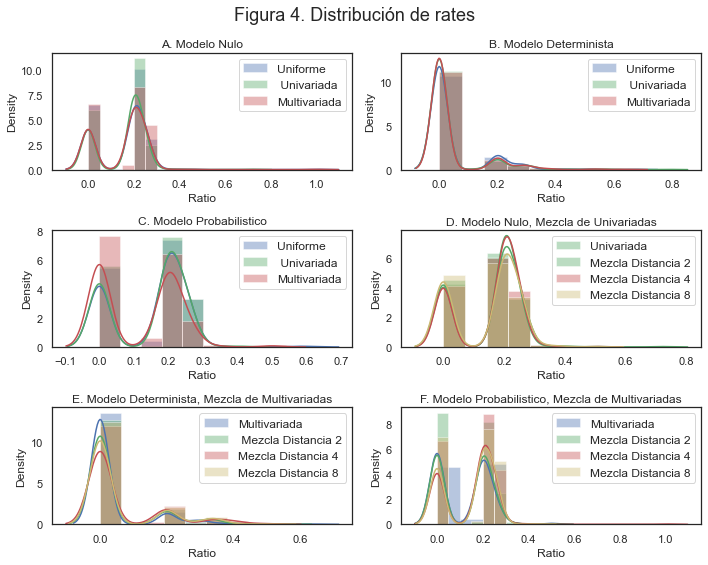

In [298]:
# fig, ax = plt.subplots(9, 1, figsize=(8,55)) 


fig, axes = plt.subplots(3, 2, figsize=(10,8)) 
fig.suptitle('Figura 4. Distribución de rates', fontsize=18)

# Nulo
val_min = min(min(UniformeNulo.Ratio),min(UnivariadaNulo.Ratio),min(MultivariadaNulo.Ratio))
val_max = max(max(UniformeNulo.Ratio),max(UnivariadaNulo.Ratio),max(MultivariadaNulo.Ratio))
sns.distplot(UniformeNulo.Ratio,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaNulo.Ratio,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = ' Univariada')
sns.distplot(MultivariadaNulo.Ratio,ax=axes[0,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,0].legend(loc='best', fontsize=12)
axes[0,0].title.set_text("A. Modelo Nulo")

# Determinista
val_min = min(min(UniformeDeterminista.Ratio),min(UnivariadaDeterminista.Ratio),min(MultivariadaDeterminista.Ratio))
val_max = max(max(UniformeDeterminista.Ratio),max(UnivariadaDeterminista.Ratio),max(MultivariadaDeterminista.Ratio))
sns.distplot(UniformeDeterminista.Ratio,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaDeterminista.Ratio,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = ' Univariada')
sns.distplot(MultivariadaDeterminista.Ratio,ax=axes[0,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[0,1].legend(loc='best', fontsize=12)
axes[0,1].title.set_text("B. Modelo Determinista")

# Probabilistica
val_min = min(min(UniformeProbabilistica.Ratio),min(UnivariadaProbabilistica.Ratio),min(MultivariadaProbabilistica.Ratio))
val_max = max(max(UniformeProbabilistica.Ratio),max(UnivariadaProbabilistica.Ratio),max(MultivariadaProbabilistica.Ratio))
sns.distplot(UniformeProbabilistica.Ratio,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Uniforme')
sns.distplot(UnivariadaProbabilistica.Ratio,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = ' Univariada')
sns.distplot(MultivariadaProbabilistica.Ratio,ax=axes[1,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Multivariada')
axes[1,0].legend(loc='best', fontsize=12)
axes[1,0].title.set_text("C. Modelo Probabilistico")

# Univariada Mezclas Nulo
val_min = min(min(UnivariadaNulo.Ratio),min(UnivariadaNuloMezcla2.Ratio),min(UnivariadaNuloMezcla4.Ratio), min(UnivariadaNuloMezcla8.Ratio))
val_max = max(max(UnivariadaNulo.Ratio),max(UnivariadaNuloMezcla2.Ratio),max(UnivariadaNuloMezcla4.Ratio), max(UnivariadaNuloMezcla8.Ratio))
sns.distplot(UnivariadaNulo.Ratio,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Univariada')
sns.distplot(UnivariadaNuloMezcla2.Ratio,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(UnivariadaNuloMezcla4.Ratio,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(UnivariadaNuloMezcla8.Ratio,ax=axes[1,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[1,1].legend(loc='best', fontsize=12)
axes[1,1].title.set_text("D. Modelo Nulo, Mezcla de Univariadas")

# Multivariada Mezclas Determinista
val_min = min(min(MultivariadaDeterminista.Ratio),min(MultivariadaDeterministaMezcla2.Ratio),min(MultivariadaDeterministaMezcla4.Ratio), min(MultivariadaDeterministaMezcla8.Ratio))
val_max = max(max(MultivariadaDeterminista.Ratio),max(MultivariadaDeterministaMezcla2.Ratio),max(MultivariadaDeterministaMezcla4.Ratio), max(MultivariadaDeterministaMezcla8.Ratio))
sns.distplot(MultivariadaDeterminista.Ratio,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Multivariada')
sns.distplot(MultivariadaDeterministaMezcla2.Ratio,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = ' Mezcla Distancia 2')
sns.distplot(MultivariadaDeterministaMezcla4.Ratio,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaDeterministaMezcla8.Ratio,ax=axes[2,0], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,0].legend(loc='best', fontsize=12)
axes[2,0].title.set_text("E. Modelo Determinista, Mezcla de Multivariadas")

# Multivariada Mezclas Probabilistica
val_min = min(min(MultivariadaProbabilistica.Ratio),min(MultivariadaProbabilisticaMezcla2.Ratio),min(MultivariadaProbabilisticaMezcla4.Ratio), min(MultivariadaProbabilisticaMezcla8.Ratio))
val_max = max(max(MultivariadaProbabilistica.Ratio),max(MultivariadaProbabilisticaMezcla2.Ratio),max(MultivariadaProbabilisticaMezcla4.Ratio), max(MultivariadaProbabilisticaMezcla8.Ratio))
sns.distplot(MultivariadaProbabilistica.Ratio,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color="b", label = 'Multivariada')
sns.distplot(MultivariadaProbabilisticaMezcla2.Ratio,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'g', label = 'Mezcla Distancia 2')
sns.distplot(MultivariadaProbabilisticaMezcla4.Ratio,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'r', label = 'Mezcla Distancia 4')
sns.distplot(MultivariadaProbabilisticaMezcla8.Ratio,ax=axes[2,1], bins=10, hist_kws={'range':(val_min,val_max), 'alpha': 0.4},norm_hist=True, color = 'y', label = 'Mezcla Distancia 8')
axes[2,1].legend(loc='best', fontsize=12)
axes[2,1].title.set_text("F. Modelo Probabilistico, Mezcla de Multivariadas")


plt.tight_layout()


plt.savefig('F4.png', dpi = 800)

In [305]:
print (MultivariadaProbabilisticaMezcla4[MultivariadaProbabilisticaMezcla4.Ratio > 0.7])
print (MultivariadaProbabilisticaMezcla4)

      ID                                            Opinion VotosPos VotosNeg  \
498  498  [1.3987754927929674, 0.7724154924189883, 1.409...        1        0   

    Vistas Ratio  
498      1   1.0  
      ID                                            Opinion VotosPos VotosNeg  \
0      0  [-0.05676941545525305, -0.8154516154872066, -2...        9        5   
1      1  [0.2886079473272385, 0.43656091603293234, 0.57...        0        0   
2      2  [1.548284091242257, 1.725748517434599, 0.57650...       19        7   
3      3  [1.2600299420633132, 1.76303500701286, 0.84762...        1        1   
4      4  [-0.5184537252241201, -1.4880231825519525, -1....       16        6   
..   ...                                                ...      ...      ...   
495  495  [-0.8845734258491897, -1.244933388410641, -1.3...        1        2   
496  496  [2.0262777467909805, 0.8832287771151932, 0.243...        0        0   
497  497  [-0.6013108802569769, 0.017936072408818227, -1...        0  

# Figura 5. Rates vs visualizaciones

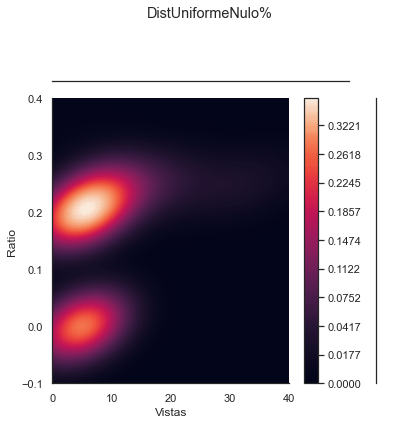

<Figure size 432x288 with 0 Axes>

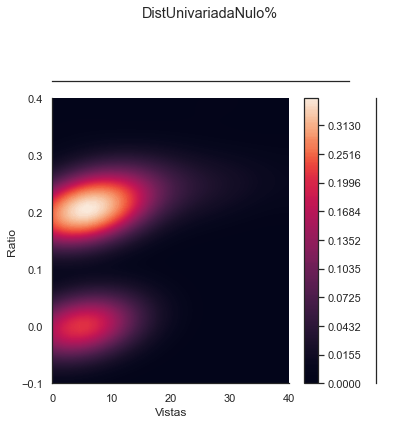

<Figure size 432x288 with 0 Axes>

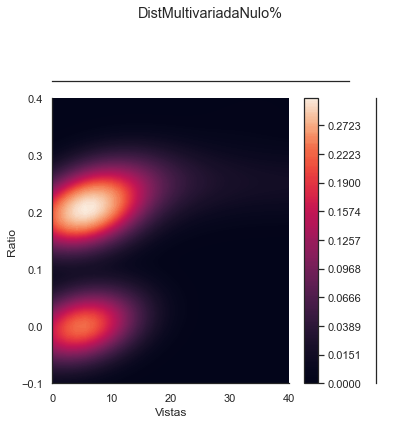

<Figure size 432x288 with 0 Axes>

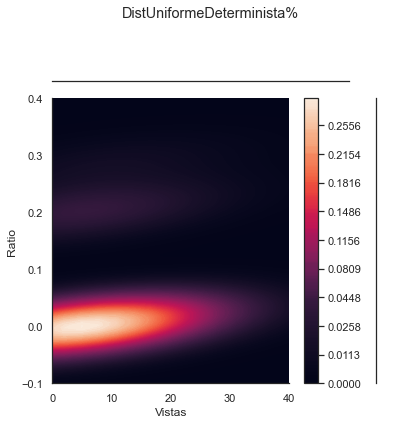

<Figure size 432x288 with 0 Axes>

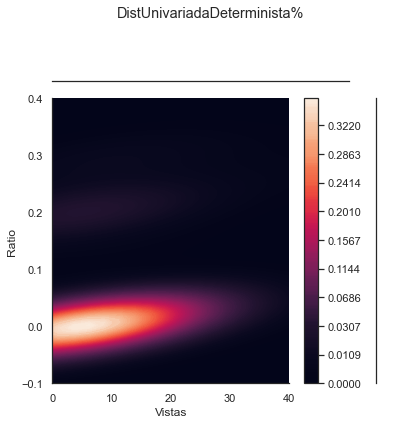

<Figure size 432x288 with 0 Axes>

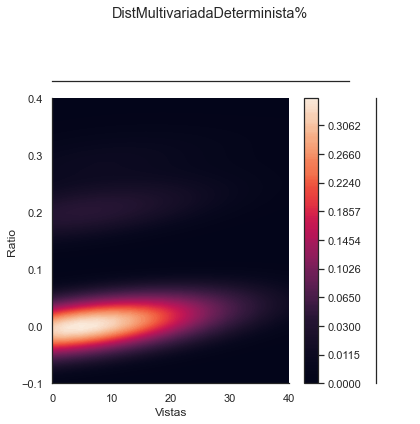

<Figure size 432x288 with 0 Axes>

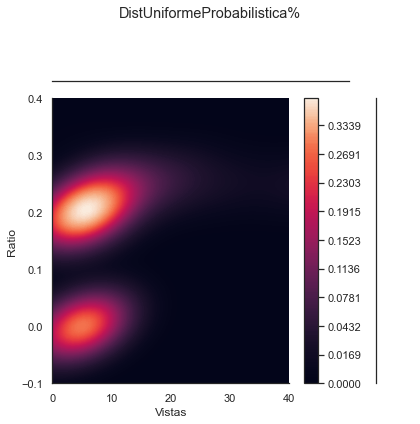

<Figure size 432x288 with 0 Axes>

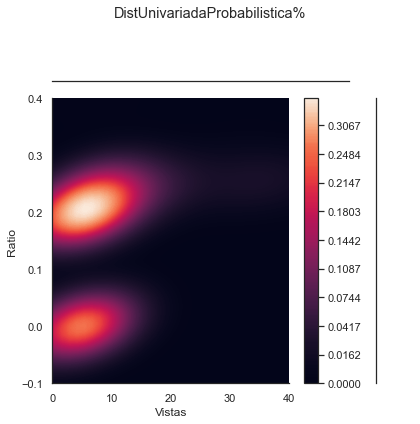

<Figure size 432x288 with 0 Axes>

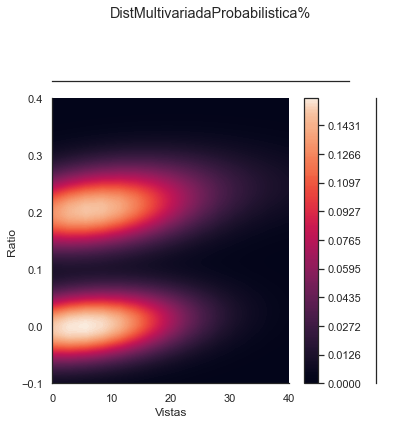

<Figure size 432x288 with 0 Axes>

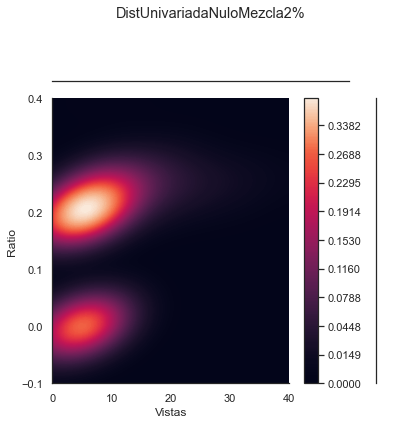

<Figure size 432x288 with 0 Axes>

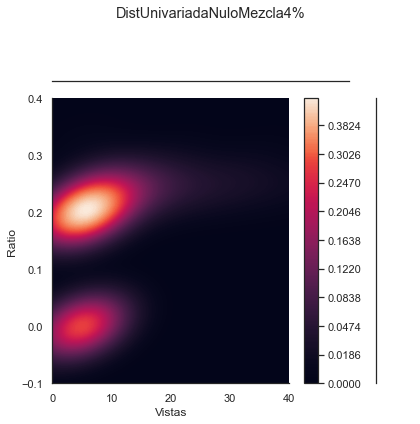

<Figure size 432x288 with 0 Axes>

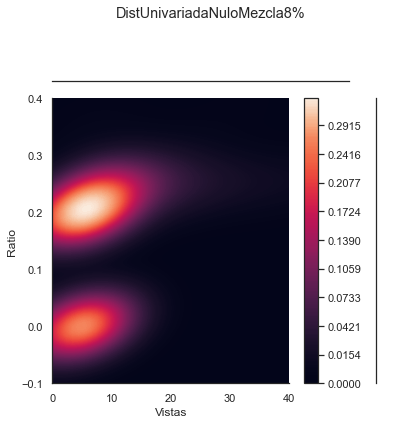

<Figure size 432x288 with 0 Axes>

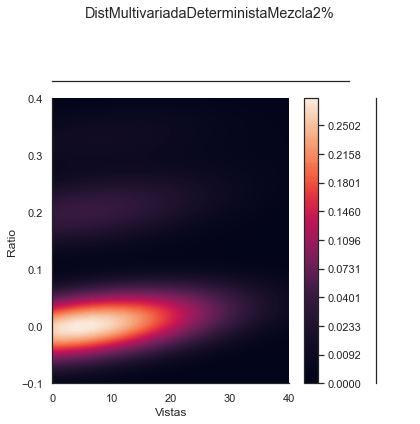

<Figure size 432x288 with 0 Axes>

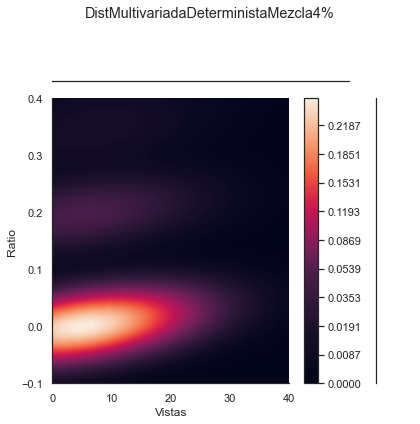

<Figure size 432x288 with 0 Axes>

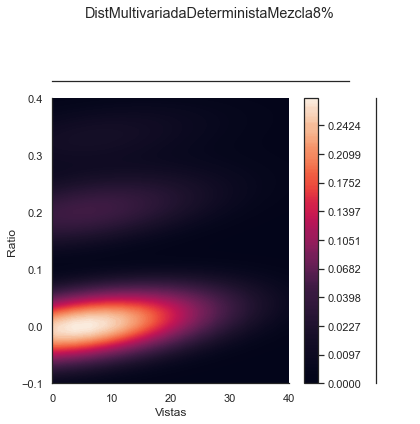

<Figure size 432x288 with 0 Axes>

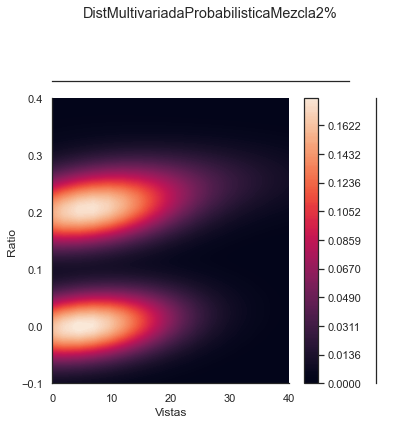

<Figure size 432x288 with 0 Axes>

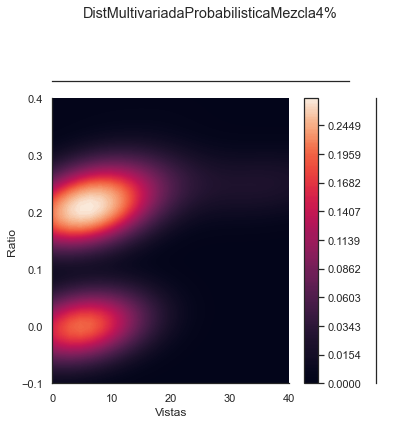

<Figure size 432x288 with 0 Axes>

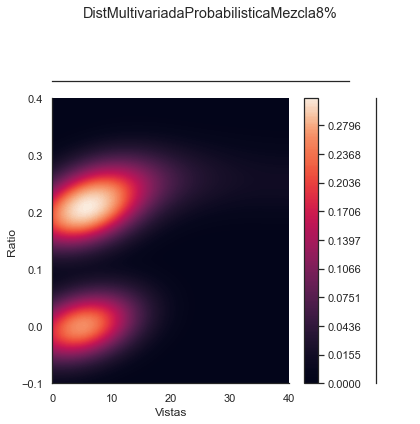

<Figure size 432x288 with 0 Axes>

In [218]:
sns.set_theme(style="white")

DistUniformeNulo = UniformeNulo.copy()
DistUnivariadaNulo = UnivariadaNulo.copy()
DistMultivariadaNulo = MultivariadaNulo.copy()
DistUniformeDeterminista = UniformeDeterminista.copy()
DistUnivariadaDeterminista = UnivariadaDeterminista.copy()
DistMultivariadaDeterminista = MultivariadaDeterminista.copy()
DistUniformeProbabilistica = UniformeProbabilistica.copy()
DistUnivariadaProbabilistica = UnivariadaProbabilistica.copy()
DistMultivariadaProbabilistica = MultivariadaProbabilistica.copy()
DistUnivariadaNuloMezcla2 = UnivariadaNuloMezcla2.copy()
DistUnivariadaNuloMezcla4 = UnivariadaNuloMezcla4.copy()
DistUnivariadaNuloMezcla8 = UnivariadaNuloMezcla8.copy()
DistMultivariadaDeterministaMezcla2 = MultivariadaDeterministaMezcla2.copy()
DistMultivariadaDeterministaMezcla4 = MultivariadaDeterministaMezcla4.copy()
DistMultivariadaDeterministaMezcla8 = MultivariadaDeterministaMezcla8.copy()
DistMultivariadaProbabilisticaMezcla2 = MultivariadaProbabilisticaMezcla2.copy()
DistMultivariadaProbabilisticaMezcla4 = MultivariadaProbabilisticaMezcla4.copy()
DistMultivariadaProbabilisticaMezcla8 = MultivariadaProbabilisticaMezcla8.copy()

Cuenta = 0
Nombres = ['DistUniformeNulo', 'DistUnivariadaNulo', 'DistMultivariadaNulo', 'DistUniformeDeterminista', 'DistUnivariadaDeterminista', 'DistMultivariadaDeterminista', 
          'DistUniformeProbabilistica', 'DistUnivariadaProbabilistica', 'DistMultivariadaProbabilistica', 'DistUnivariadaNuloMezcla2', 'DistUnivariadaNuloMezcla4', 
          'DistUnivariadaNuloMezcla8', 'DistMultivariadaDeterministaMezcla2', 'DistMultivariadaDeterministaMezcla4','DistMultivariadaDeterministaMezcla8', 'DistMultivariadaProbabilisticaMezcla2', 
          'DistMultivariadaProbabilisticaMezcla4', 'DistMultivariadaProbabilisticaMezcla8']

for i in [DistUniformeNulo, DistUnivariadaNulo, DistMultivariadaNulo, DistUniformeDeterminista, DistUnivariadaDeterminista, DistMultivariadaDeterminista, 
          DistUniformeProbabilistica, DistUnivariadaProbabilistica, DistMultivariadaProbabilistica, DistUnivariadaNuloMezcla2, DistUnivariadaNuloMezcla4, 
          DistUnivariadaNuloMezcla8, DistMultivariadaDeterministaMezcla2, DistMultivariadaDeterministaMezcla4, DistMultivariadaDeterministaMezcla8, DistMultivariadaProbabilisticaMezcla2, 
          DistMultivariadaProbabilisticaMezcla4, DistMultivariadaProbabilisticaMezcla8]:
    i['Ratio'] = i['Ratio'].astype(float)
    i['Vistas'] = i['Vistas'].astype(float)
    
    g = sns.JointGrid(data=i, x="Vistas", y="Ratio", space=1, xlim={0,40}, ylim={-0.1,0.4})
    ax = g.plot_joint(sns.kdeplot, fill=True,thresh=0, levels=200, cmap="rocket",cbar=True)
#     plt.title("%s%" %Nombres [Cuenta])
    plt.suptitle("%s%%" %Nombres [Cuenta])
    plt.tight_layout()
    plt.show()
    plt.savefig("%s%%.png" %Nombres [Cuenta])
    Cuenta +=1

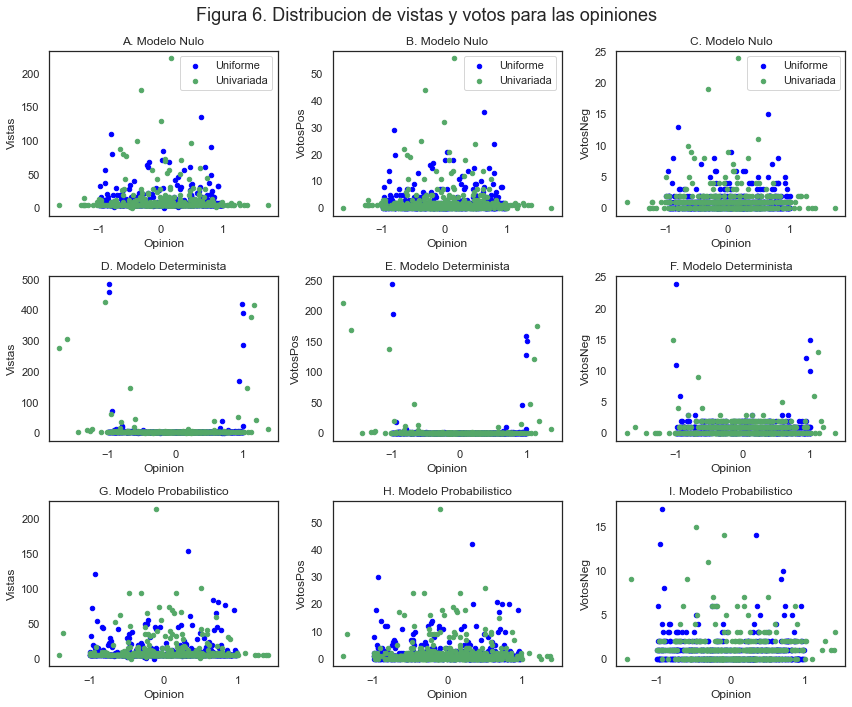

In [308]:
DistUniformeNulo = UniformeNulo.copy()
DistUnivariadaNulo = UnivariadaNulo.copy()

DistUniformeDeterminista = UniformeDeterminista.copy()
DistUnivariadaDeterminista = UnivariadaDeterminista.copy()

DistUniformeProbabilistica = UniformeProbabilistica.copy()
DistUnivariadaProbabilistica = UnivariadaProbabilistica.copy()

DistUnivariadaNuloMezcla2 = UnivariadaNuloMezcla2.copy()
DistUnivariadaNuloMezcla4 = UnivariadaNuloMezcla4.copy()
DistUnivariadaNuloMezcla8 = UnivariadaNuloMezcla8.copy()


DistUnivariadaDeterminista = UnivariadaDeterminista.copy()

Cuenta = 0
Nombres = ['DistUniformeNulo', 'DistUnivariadaNulo', 'DistMultivariadaNulo', 'DistUniformeDeterminista', 'DistUnivariadaDeterminista', 'DistMultivariadaDeterminista', 
          'DistUniformeProbabilistica', 'DistUnivariadaProbabilistica', 'DistMultivariadaProbabilistica', 'DistUnivariadaNuloMezcla2', 'DistUnivariadaNuloMezcla4', 
          'DistUnivariadaNuloMezcla8', 'DistMultivariadaDeterministaMezcla2', 'DistMultivariadaDeterministaMezcla4', 'DistMultivariadaProbabilisticaMezcla2', 
          'DistMultivariadaProbabilisticaMezcla4', 'DistMultivariadaProbabilisticaMezcla8']

for i in [DistUniformeNulo, DistUnivariadaNulo,  DistUniformeDeterminista, DistUnivariadaDeterminista, DistUniformeProbabilistica, 
          DistUnivariadaProbabilistica, DistUnivariadaNuloMezcla2, DistUnivariadaNuloMezcla4, DistUnivariadaNuloMezcla8]:
    for k in i.index:
        i.at [k,'Opinion'] = i.at [k,'Opinion'][0]

fig, axes = plt.subplots(3, 3, figsize=(12,10)) 
fig.suptitle('Figura 6. Distribucion de vistas y votos para las opiniones', fontsize=18)
# fig.suptitle('Figura 7. Distribución de cantidad de votos negativos > 0')

# Modelo Nulo
DistUniformeNulo.plot(kind='scatter',x='Opinion',y='Vistas',color='blue', ax =axes [0,0], label = 'Uniforme')
DistUnivariadaNulo.plot(kind='scatter',x='Opinion',y='Vistas',color='g', ax =axes [0,0], label = 'Univariada')
axes[0,0].title.set_text("A. Modelo Nulo")

DistUniformeNulo.plot(kind='scatter',x='Opinion',y='VotosPos',color='blue', ax =axes [0,1], label = 'Uniforme')
DistUnivariadaNulo.plot(kind='scatter',x='Opinion',y='VotosPos',color='g', ax =axes [0,1], label = 'Univariada')
axes[0,1].title.set_text("B. Modelo Nulo")

DistUniformeNulo.plot(kind='scatter',x='Opinion',y='VotosNeg',color='blue', ax =axes [0,2], label = 'Uniforme')
DistUnivariadaNulo.plot(kind='scatter',x='Opinion',y='VotosNeg',color='g', ax =axes [0,2], label = 'Univariada')
axes[0,2].title.set_text("C. Modelo Nulo")

# Determinista
DistUniformeDeterminista.plot(kind='scatter',x='Opinion',y='Vistas',color='blue', ax =axes [1,0])
DistUnivariadaDeterminista.plot(kind='scatter',x='Opinion',y='Vistas',color='g', ax =axes [1,0])
axes[1,0].title.set_text("D. Modelo Determinista")

DistUniformeDeterminista.plot(kind='scatter',x='Opinion',y='VotosPos',color='blue', ax =axes [1,1])
DistUnivariadaDeterminista.plot(kind='scatter',x='Opinion',y='VotosPos',color='g', ax =axes [1,1])
axes[1,1].title.set_text("E. Modelo Determinista")

DistUniformeDeterminista.plot(kind='scatter',x='Opinion',y='VotosNeg',color='blue', ax =axes [1,2])
DistUnivariadaDeterminista.plot(kind='scatter',x='Opinion',y='VotosNeg',color='g', ax =axes [1,2])
axes[1,2].title.set_text("F. Modelo Determinista")

# Probabilistica
DistUniformeProbabilistica.plot(kind='scatter',x='Opinion',y='Vistas',color='blue', ax =axes [2,0])
DistUnivariadaProbabilistica.plot(kind='scatter',x='Opinion',y='Vistas',color='g', ax =axes [2,0])
axes[2,0].title.set_text("G. Modelo Probabilistico")

DistUniformeProbabilistica.plot(kind='scatter',x='Opinion',y='VotosPos',color='blue', ax =axes [2,1])
DistUnivariadaProbabilistica.plot(kind='scatter',x='Opinion',y='VotosPos',color='g', ax =axes [2,1])
axes[2,1].title.set_text("H. Modelo Probabilistico")

DistUniformeProbabilistica.plot(kind='scatter',x='Opinion',y='VotosNeg',color='blue', ax =axes [2,2])
DistUnivariadaProbabilistica.plot(kind='scatter',x='Opinion',y='VotosNeg',color='g', ax =axes [2,2])
axes[2,2].title.set_text("I. Modelo Probabilistico")


#     # B1. Distribución de votos positivos.
# B1 = DataSave.plot(kind='scatter',x='Opinion',y='VotosPos',color='green')
# plt.title ('B1. Distribución de votos positivos. Distribucion '+ str(Tipo))
# plt.show()
    
#     # B2. Distribución de votos positivos para ideas que tengan mas de 0 votos positivos
# VotosPosFiltrados = DataSave[DataSave.VotosPos > 0]
# B2 = VotosPosFiltrados.plot(kind='scatter',x='Opinion',y='VotosPos',color='green')
# plt.title ('B2. Distribución de votos positivos para ideas que tengan mas de 0 votos positivos. Distribucion '+ str(Tipo))
# plt.show()
    
#     # C1. Distribución de votos negativos.
# C1 = DataSave.plot(kind='scatter',x='Opinion',y='VotosNeg',color='red')
# plt.title ('C1. Distribución de votos negativos. Distribucion '+ str(Tipo))
# plt.show()
    
#     # C2. Distribución de votos negativos para ideas que tengan mas de 0 votos negativos
# VotosNegFiltrados = DataSave[DataSave.VotosNeg > 0]
# C2 = VotosNegFiltrados.plot(kind='scatter',x='Opinion',y='VotosNeg',color='green')
# plt.title ('C2. Distribución de votos negativos para ideas que tengan mas de 0 votos negativos. Distribucion '+ str(Tipo))
# plt.show()
    
#     # D1. Distribución de rates.
# D1 = DataSave.plot(kind='scatter',x='Opinion',y='Ratio',color='orange')
# plt.title ('D1. Distribución de rates. Distribucion '+ str(Tipo))
# plt.show()

plt.tight_layout()


plt.savefig('F6.png', dpi = 800)
    

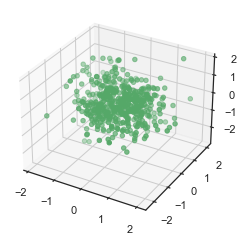

In [231]:
for i in DistMultivariadaDeterminista.index.tolist():
    # Para hacer que la opinion no sea una lista.
    Opinion = DistMultivariadaDeterminista.at [i,'Opinion']
    DistMultivariadaDeterminista.at [i,'OpinionA'] = Opinion [0]
    DistMultivariadaDeterminista.at [i,'OpinionB'] = Opinion [1]
    DistMultivariadaDeterminista.at [i,'OpinionC'] = Opinion [2]
OpinionAList = DistMultivariadaDeterminista.OpinionA.tolist()
OpinionBList = DistMultivariadaDeterminista.OpinionB.tolist()
OpinionCList = DistMultivariadaDeterminista.OpinionC.tolist()
    
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(OpinionAList, OpinionBList, OpinionCList, c='g', marker='o')

In [228]:
print (DistUnivariadaDeterminista.index.tolist())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
print("Tiempo de simulacion")

end = time.time()

print(end - start)